# Continuous $paO_2$ Prediction and Postoperative Complications in

Neurosurgical Patients

Analysis of postoperative complications - normalized $paO_2$ values

Andrea S. Gutmann  
2025-12-17

# 1. Loading required libraries and data

In [1]:
# ======================
# Standard library
# ======================
import csv
import math
import os
import pickle
import platform
import pprint
import random
import sys
import time
from collections import Counter
from datetime import datetime
from pathlib import Path
from time import perf_counter

# ======================
# Third-party libraries
# ======================
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from scipy import stats
from sklearn.linear_model import SGDRegressor

# ======================
# Local / application
# ======================
import session_info
from statistical_functions import *

pp = pprint.PrettyPrinter(indent=4)
np.random.seed(42)

matplotlib.rcParams["figure.dpi"] = 300

sns.set_style('whitegrid')

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

with open(Path(config.get('pickle').get('analysis')), 'rb') as f:
    data = pickle.load(f)

data = data.astype({'max_paO2': float, 'norm_auc_paO2': float, 'norm_auc_pf': float})

complications = config.get("complications_dict").keys()
diagnoses = config.get("diagnoses") + ["other"]

# 2. Prepare data

In [2]:
print(f"Measured: {len(data.loc[data['pao2_type_measured']==True,:]):,}, predicted: {len(data.loc[data['pao2_type_measured']==False,:]):,}, number of surgeries: {len(data.identifier.unique()):,}, number of patients: {len(data.case_number.unique()):,}.")

analysis_df = data.loc[:, ['identifier', 'case_number', 'opdatum',
       'bmi', 'age', 'los', 'already_intubated', 'not_extubated',
       'ops', 'asa', 'time_to_incision',
       'time_to_end', 'mv_time', 'theater', 'sex_male',
       'incision_closure_time', 'creatinine', 'deceased',
       'intervention_count', 'sap_procedures',
       'norm_auc_paO2', 'norm_auc_pf', 'max_paO2'] + list(config.get('procedure_codes')) + list(config.get("complications_dict_short").keys()) + diagnoses].drop_duplicates()


analysis_df = analysis_df.astype({'asa': 'int', 'sex_male': 'int', 'already_intubated': 'int', 'not_extubated': 'int'}).astype({'asa': 'object', 'sex_male': 'object', 'already_intubated': 'object', 'not_extubated': 'object'})

print(f"Total number of patients for analysis: {len(analysis_df):,}.")

Measured: 19,665, predicted: 304,928, number of surgeries: 5,020, number of patients: 5,020.
Total number of patients for analysis: 5,020.

In [3]:
selected_identifiers = list(map(lambda x: x[0], list(sorted(Counter(data["identifier"]).items(),key = lambda x:x[1]))[-5:]))

for identifier in selected_identifiers:
    print(identifier, Counter(data.loc[data["identifier"]==identifier,"pao2_type_measured"]))

zipped = zip(selected_identifiers, [Counter(data.loc[data["identifier"]==identifier,"pao2_type_measured"]) for identifier in selected_identifiers])

max_entry = sorted(zipped, key=lambda x: -x[1][1])[0]

identifier_used = 1019888 # max_entry[0]
print(identifier_used)

matplotlib.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(figsize=(10,4))
y_measured = data.loc[(data["identifier"]==identifier_used)&(data["pao2_type_measured"]==1),"paO2_combined"]
x_measured = data.loc[(data["identifier"]==identifier_used)&(data["pao2_type_measured"]==1),"idx"]
y_predicted = data.loc[(data["identifier"]==identifier_used)&(data["pao2_type_measured"]==0),"paO2_combined"]
x_predicted = data.loc[(data["identifier"]==identifier_used)&(data["pao2_type_measured"]==0),"idx"]

ax.plot(data.loc[(data["identifier"]==identifier_used),"idx"], data.loc[(data["identifier"]==identifier_used),"paO2_combined"], "-")
ax.plot(x_measured, y_measured,"o", color = "red", label="measured $paO_2$ values")
ax.plot(x_predicted, y_predicted,"o", color = "blue", label="predicted $paO_2$ values")

ax.fill_between(data.loc[(data["identifier"]==identifier_used),"idx"],data.loc[(data["identifier"]==identifier_used),"paO2_combined"], 0, alpha=0.6, label="$paO_2$ integral (AUC)")

ax.set_xlabel("5 min interval")
ax.set_ylabel("$paO_2$ in mmHg")

ax.set_xlim(0, max(data.loc[(data["identifier"]==identifier_used),"idx"]))
ax.set_ylim(0)
ax.legend()

plt.savefig(f"plots/pao2_auc_example.png", dpi=300, bbox_inches="tight")
ax.set_title("Measured and predicted $paO_2$ values of a patient")

plt.show()

1378367 Counter({0: 161, 1: 6})
1930358 Counter({0: 157, 1: 10})
485488 Counter({0: 173, 1: 17})
776344 Counter({0: 185, 1: 20})
760577 Counter({0: 246, 1: 21})
1019888

In [5]:
avg_data = (
    data.groupby(['identifier', 'pao2_type_measured'])['paO2_combined']
    .mean()
    .reset_index()
    .pivot(index='identifier', columns='pao2_type_measured', values='paO2_combined')
    .dropna()  # drop patients without both values
)

# Rename columns for clarity
avg_data = avg_data.rename(columns={1: 'Measured', 0: 'Predicted'})
avg_data['Mean'] = avg_data[['Measured', 'Predicted']].mean(axis=1)
avg_data['Difference'] = avg_data['Predicted'] - avg_data['Measured']

mean_diff = avg_data['Difference'].mean()
sd_diff = avg_data['Difference'].std()

# Create joint grid: scatter in middle, KDE on the side
g = sns.JointGrid(
    data=avg_data,
    x="Mean",
    y="Difference",
    height=6
)
g.fig.set_size_inches(7, 4)

# Scatter for Bland–Altman
g.plot_joint(sns.scatterplot, alpha=0.6)

# Add horizontal lines for bias and LoA
g.ax_joint.axhline(mean_diff, color='red', linestyle='--', label=f'Mean bias = {mean_diff:.1f}')
g.ax_joint.axhline(mean_diff + 1.96*sd_diff, color='gray', linestyle='--', label='95% limits of agreement')
g.ax_joint.axhline(mean_diff - 1.96*sd_diff, color='gray', linestyle='--')
g.ax_joint.legend()

# Hide the empty top marginal axis
g.ax_marg_x.remove()

# KDE for marginal distribution of differences
sns.kdeplot(
    y=avg_data["Difference"],
    fill=True, color="skyblue", ax=g.ax_marg_y, alpha=0.6
)

# Labels and title
g.set_axis_labels("Mean of measured and predicted $paO_2$ (mmHg)",
                  "Predicted − Measured $paO_2$ (mmHg)")

plt.savefig(f"plots/bland-altman-density.png", dpi=300, bbox_inches="tight")
g.fig.suptitle("Bland–Altman plot with distribution of differences", y=0.89)

plt.show()

# 3. Analysis

## 3.1 Patient characteristics

Combined $paO_2$ values

In [6]:
# all 
desc_df = data.loc[:,config.get('one_measurements')+config.get('multi_measurements')]

single_meas = (
    desc_df[config.get("one_measurements")]
    .groupby(["identifier"])
    .aggregate("mean")
    .describe(include="all")
    .reindex(sorted(config.get("one_measurements")), axis=1)
)

multiple_meas = (
    desc_df[config.get("multi_measurements")]
    .describe(include="all")
    .reindex(sorted(config.get("multi_measurements")), axis=1)
)

descriptive_df = multiple_meas.join(single_meas).drop("identifier", axis=1)

display(
    descriptive_df.rename(columns=config.get('feature_names')).T.rename_axis("my_idx")
    .sort_values(["count", "my_idx"])
    .round(2)
    .astype({"count": "int"})
)
descriptive_df.rename(columns=config.get('feature_names')).T.rename_axis("my_idx").sort_values(["count", "my_idx"]).round(2).astype({"count": "int"}).to_csv("./data/out/descriptives.csv")

Measured $paO_2$

In [7]:
## measured paO2 
desc_df = data.loc[data['pao2_type_measured']==True,config.get('one_measurements')+config.get('multi_measurements')]

single_meas = (
    desc_df[config.get("one_measurements")]
    .groupby(["identifier"])
    .aggregate("mean")
    .describe(include="all")
    .reindex(sorted(config.get("one_measurements")), axis=1)
)

multiple_meas = (
    desc_df[config.get("multi_measurements")]
    .describe(include="all")
    .reindex(sorted(config.get("multi_measurements")), axis=1)
)

descriptive_df = multiple_meas.join(single_meas).drop("identifier", axis=1)

display(
    descriptive_df.T.rename_axis("my_idx")
    .sort_values(["count", "my_idx"])
    .round(2)
    .astype({"count": "int"})
)

Imputed $paO_2$

In [8]:
## imputed paO2
desc_df = data.loc[data['pao2_type_measured']==False,config.get('one_measurements')+config.get('multi_measurements')]

single_meas = (
    desc_df[config.get("one_measurements")]
    .groupby(["identifier"])
    .aggregate("mean")
    .describe(include="all")
    .reindex(sorted(config.get("one_measurements")), axis=1)
)

multiple_meas = (
    desc_df[config.get("multi_measurements")]
    .describe(include="all")
    .reindex(sorted(config.get("multi_measurements")), axis=1)
)

descriptive_df = multiple_meas.join(single_meas).drop("identifier", axis=1)

display(
    descriptive_df.T.rename_axis("my_idx")
    .sort_values(["count", "my_idx"])
    .round(2)
    .astype({"count": "int"})
)
# descriptive_df.T.rename_axis("my_idx").sort_values(["count", "my_idx"]).round(2).astype({"count": "int"}).to_csv(config.get('csv').get('descriptives'))

### 3.1.1 $paO_2$ Values (mean per patient)

In [9]:
measured1 = data.loc[(data["pao2_type_measured"]==1),:].groupby("identifier").agg({"paO2_combined":"mean"})
measured1["paO2_type"] = "measured"
measured1["timepoint"] = "peri-operative"
predicted1 = data.loc[(data["pao2_type_measured"]==0),:].groupby("identifier").agg({"paO2_combined":"mean"})
predicted1["paO2_type"] = "predicted"
predicted1["timepoint"] = "peri-operative"


plot_data = pd.concat([measured1, predicted1], axis=0)

# measured paO2 
print(f"Descriptives of measured perioperative paO2 values (mean per patient):\n{data.loc[(data['pao2_type_measured']==1),:].groupby('identifier').agg({'paO2_combined':'mean'}).describe().round(2)}")

# predicted paO2
print(f"Descriptives of predicted perioperative paO2 values (mean per patient):\n{data.loc[(data['pao2_type_measured']==0),:].groupby('identifier').agg({'paO2_combined':'mean'}).describe().round(2)}")

# all paO2 TODO contiue here
print(f"Descriptives of all perioperative paO2 values (mean per patient):\n{data.groupby('identifier').agg({'paO2_combined':'mean'}).describe().round(2)}")


pval = compare_median("paO2_combined", plot_data, "paO2_type")

Descriptives of measured perioperative paO2 values (mean per patient):
       paO2_combined
count        5020.00
mean          223.29
std            71.22
min            91.50
25%           173.75
50%           209.33
75%           256.89
max           602.70
Descriptives of predicted perioperative paO2 values (mean per patient):
       paO2_combined
count        5020.00
mean          221.40
std            45.62
min            27.78
25%           189.86
50%           215.70
75%           246.87
max           449.67
Descriptives of all perioperative paO2 values (mean per patient):
       paO2_combined
count        5020.00
mean          221.43
std            46.09
min            37.45
25%           189.60
50%           215.25
75%           247.20
max           455.37
          paO2_combined                  
                 median        mean count
paO2_type                                
measured     209.329167  223.293129  5020
predicted    215.701288  221.400492  5020
p-value: 0.0



No aggregation per patient

In [10]:
pval = compare_median("paO2_combined", data, "pao2_type_measured")

                   paO2_combined                 
                          median     mean   count
pao2_type_measured                               
0                       196.4151 218.0542  304928
1                       191.0000 216.2164   19665
p-value: 0.0

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.02 (very small)

### 3.1.2 Sociodemographics / Descriptive Statistics

In [11]:
for c in ['bmi', 'age', 'los',  'time_to_incision', 'time_to_end', 'mv_time', 'incision_closure_time',]: #'bloodloss_intra', 'bloodloss_peri', 'bloodloss_total']:
    print(f"Descriptives for {c.upper()}:\n{analysis_df[c].describe().round(2)}\n")

print(f"ASA:\n{analysis_df.groupby('asa').agg('count')['identifier']}")
print(f"Sex:\n{analysis_df.groupby('sex_male').agg('count')['identifier']}")
print(f"Deceased:\n{analysis_df.groupby('deceased').agg('count')['identifier']}")
print(return_table(analysis_df, ['asa', 'deceased']))
print(f"Already intubated before surgery:\n{analysis_df.groupby('already_intubated').agg('count')['identifier']}")
print(f"Not extubated after surgery:\n{analysis_df.groupby('not_extubated').agg('count')['identifier']}")

Descriptives for BMI:
count   5020.0000
mean      25.1700
std        4.3900
min       14.8100
25%       22.3100
50%       24.6200
75%       27.4700
max       59.2000
Name: bmi, dtype: float64

Descriptives for AGE:
count   5020.0000
mean      53.9000
std       15.9400
min       18.0000
25%       43.0000
50%       55.0000
75%       66.0000
max       94.0000
Name: age, dtype: float64

Descriptives for LOS:
count   5020.0000
mean      10.9500
std        9.9300
min        1.0000
25%        6.0000
50%        7.0000
75%       12.0000
max      175.0000
Name: los, dtype: float64

Descriptives for TIME_TO_INCISION:
count   5020.0000
mean      83.3700
std       27.1600
min        4.2500
25%       67.0000
50%       82.0000
75%       99.0000
max      222.0000
Name: time_to_incision, dtype: float64

Descriptives for TIME_TO_END:
count   5020.0000
mean      26.0200
std       19.7000
min        0.0300
25%       13.0000
50%       20.0000
75%       32.0000
max      194.0000
Name: time_to_end, dtype: fl

### 3.1.3 Diagnosis, Post-OP Complications, Surgery

In [12]:
print(analysis_df.groupby("intervention_count").count()['identifier'])

print("Diagnoses: ")
diag_dict = {
    d: (
        int(analysis_df[d].sum()),
        f"{round(100/len(analysis_df)*analysis_df[d].sum(),1)} %",
    )
    for d in diagnoses
}
for d, (n, p) in sorted(diag_dict.items(), key=lambda x: -x[1][0]):
    print(f"{d}: {n:,} ({p})")


print(
    f"\nPatients with one underlying disease: {(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() == 1 else 0, axis=1).sum()):,} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() == 1 else 0, axis=1).sum()),1)} %)."
)
print(
    f"Patients with two underlying diseases: {(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() ==2 else 0, axis=1).sum())} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() ==2 else 0, axis=1).sum()),1)} %)."
)
print(
    f"Patients with three underlying diseases: {(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() ==3 else 0, axis=1).sum())} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() ==3 else 0, axis=1).sum()),1)} %)."
)
print(
    f"Patients with four underlying diseases: {(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() ==4 else 0, axis=1).sum())} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[diagnoses].sum() ==4 else 0, axis=1).sum()),1)} %)."
)

# print(f"Complications:\n{analysis_df.loc[:, [el for el in complications]].sum()}")

print("\nComplications: ")
compl_dict = {
    c: (
        int(analysis_df[c].sum()),
        f"{round(100/len(analysis_df)*analysis_df[c].sum(),1)} %",
    )
    for c in complications
}
for c, (n, p) in sorted(compl_dict.items(), key=lambda x: -x[1][0]):
    print(f"{c}: {n:,} ({p})")


print(
    f"\nPatients with one postoperative complication: {(analysis_df.apply(lambda row: 1 if row[complications].sum() == 1 else 0, axis=1).sum()):,} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[complications].sum() == 1 else 0, axis=1).sum()),1)} %)."
)
print(
    f"Patients with two postoperative complications: {(analysis_df.apply(lambda row: 1 if row[complications].sum() ==2 else 0, axis=1).sum())} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[complications].sum() ==2 else 0, axis=1).sum()),1)} %)."
)
print(
    f"Patients with three or more postoperative complications: {(analysis_df.apply(lambda row: 1 if row[complications].sum() >2 else 0, axis=1).sum())} ({round(100/len(analysis_df)*(analysis_df.apply(lambda row: 1 if row[complications].sum() > 2 else 0, axis=1).sum()),1)} %)."
)

intervention_count
1    4794
2     192
3      24
4       6
5       3
7       1
Name: identifier, dtype: int64
Diagnoses: 
benign_neoplasm: 2,009 (40.0 %)
malignant_neoplasm: 963 (19.2 %)
intracranial_hemorrhage: 471 (9.4 %)
cerebral_aneurysm: 422 (8.4 %)
other: 390 (7.8 %)
TBI: 217 (4.3 %)
epilepsy: 204 (4.1 %)
trigeminus: 193 (3.8 %)
SAH: 189 (3.8 %)
neoplasm: 101 (2.0 %)
other_aneurysm_dissection: 27 (0.5 %)

Patients with one underlying disease: 4,863 (96.9 %).
Patients with two underlying diseases: 148 (2.9 %).
Patients with three underlying diseases: 9 (0.2 %).
Patients with four underlying diseases: 0 (0.0 %).

Complications: 
delirium: 235 (4.7 %)
pneumonia: 187 (3.7 %)
stroke: 171 (3.4 %)
pulmonary_embolism: 168 (3.3 %)
cerebral_vasospasm: 126 (2.5 %)
sepsis: 67 (1.3 %)
renal_failure: 55 (1.1 %)
myocardial_infarction: 17 (0.3 %)
liver_failure: 12 (0.2 %)

Patients with one postoperative complication: 590 (11.8 %).
Patients with two postoperative complications: 146 (2.9 %).
Pati

Table 1

In [13]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

table1_data = []

for c, (n,p) in sorted(compl_dict.items(), key=lambda x: -x[1][0]):    
    row = []
    for d, (n,p) in sorted(diag_dict.items(), key=lambda x: -x[1][0]):
        row.append(
            len(analysis_df.loc[(analysis_df[d] == True) & (analysis_df[c] == True), :])
        )
    table1_data.append(row)

table1 = pd.DataFrame(
    table1_data,
    columns=[
        f"{config.get('long_names').get(d)} (N={n:,})"
        for d, (n,p) in sorted(diag_dict.items(), key=lambda x: -x[1][0])
    ],
    index=[
        f"{config.get('long_names').get(c)} (N={n:,})"
        for c, (n,p) in sorted(compl_dict.items(), key=lambda x: -x[1][0])
    ],
)

display(table1.T)
table1.T.to_csv("data/out/diag_comp.csv")

In [14]:
ax = sns.heatmap(table1.T, linewidth=0.5, annot=True, cmap = 'gray_r')
plt.savefig("plots/heatmap.png", dpi=300, bbox_inches="tight")
ax.set_title("Heatmap of postoperative complications per diagnosis")

plt.show()

## 3.2 Differences in $paO_2$ and p/F ratio between sexes

In [15]:
pvalue = compare_median("norm_auc_paO2", analysis_df, "sex_male")
print(f"\nDifferences between male and female in normalized perioperative auc values: {round(pvalue,4)}.\n\n")

median_fio2_df = pd.DataFrame(
    {
        "median_fio2": list(
            data[data["sex_male"] == True]
            .groupby("identifier")["fio2"]
            .median()
            .values
        )
        + list(
            data[data["sex_male"] == False]
            .groupby("identifier")["fio2"]
            .median()
            .values
        ),
        "sex_male": sum(analysis_df["sex_male"] == True) * [True]
        + sum(analysis_df["sex_male"] == False) * [False],
    }
)
compare_median("median_fio2", median_fio2_df, "sex_male")

median_horowitz_df = pd.DataFrame(
    {
        "median_horowitz": list(
            data[data["sex_male"] == True]
            .groupby("identifier")["horowitz"]
            .median()
            .values
        )
        + list(
            data[data["sex_male"] == False]
            .groupby("identifier")["horowitz"]
            .median()
            .values
        ),
        "sex_male": sum(analysis_df["sex_male"] == True) * [True]
        + sum(analysis_df["sex_male"] == False) * [False],
    }
)
compare_median("median_horowitz", median_horowitz_df, "sex_male")

pvalue = compare_median("norm_auc_pf", analysis_df, "sex_male")
print(f"\nDifferences between male and female in normalized perioperative p/F auc values: {round(pvalue,4)}.\n\n")

         norm_auc_paO2               
                median     mean count
sex_male                             
0             221.4527 227.0479  2854
1             206.2754 211.2733  2166
p-value: 0.0

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.35 (small)

Differences between male and female in normalized perioperative auc values: 0.0.


         median_fio2             
              median   mean count
sex_male                         
False         0.4300 0.4540  2854
True          0.4200 0.4391  2166
p-value: 0.0

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.14 (very small)
         median_horowitz               
                  median     mean count
sex_male                               
False           464.6450 461.0330  2854
True            443.7500 444.5865  2166
p-value: 0.0

... Post ho

## 3.3 Differences in $paO_2$ per ASA

Table 1

In [16]:
pvalue = compare_median("norm_auc_paO2", analysis_df, "asa", False)
print(
    f"\nDifferences between ASA classes in normalized perioperative auc values: {round(pvalue,4)}.\n\n"
)

    norm_auc_paO2               
           median     mean count
asa                             
1        227.9127 233.5727   255
2        218.2228 222.7500  2143
3        207.3290 213.7089  2175
4        221.4046 230.7889   414
5        221.1013 252.5793    33

... Post hoc test...
     1    2    3    4   5
1    -  ***  ***    *  NS
2  ***    -  ***   NS  NS
3  ***  ***    -  ***   *
4    *   NS  ***    -  NS
5   NS   NS    *   NS   -
       1      2      3      4      5
1 1.0000 0.0006 0.0000 0.0189 0.9828
2 0.0006 1.0000 0.0000 0.4863 0.2266
3 0.0000 0.0000 1.0000 0.0000 0.0107
4 0.0189 0.4863 0.0000 1.0000 0.3196
5 0.9828 0.2266 0.0107 0.3196 1.0000

1, 2: Effect size: Hedges' g: 0.26 (small)

1, 3: Effect size: Hedges' g: 0.44 (small)

1, 4: Effect size: Hedges' g: 0.05 (very small)

1, 5: Effect size: Hedges' g: 0.4 (small)

2, 3: Effect size: Hedges' g: 0.21 (small)

2, 4: Effect size: Hedges' g: 0.17 (very small)

2, 5: Effect size: Hedges' g: 0.7 (moderate)

3, 4: Effect siz

## 3.4 Postoperative Complications

### 3.4.1 Differences in intervention counts

In [17]:
analysis_df['revision'] = analysis_df["intervention_count"] > 1
pvalue = compare_median("norm_auc_paO2", analysis_df, "revision")
print(f"\nDifferences between patients with and without revision in normalized perioperative auc values: {round(pvalue,4)}.\n\n")

         norm_auc_paO2               
                median     mean count
revision                             
False         214.1682 220.1846  4794
True          210.3895 221.4504   226
p-value: 0.8336
No significance found.

1, 2: Effect size: Hedges' g: 0.03 (very small)

Differences between patients with and without revision in normalized perioperative auc values: 0.8336.



### 3.4.2 Differences in $paO_2$ between deceased and non-deceased patients

In [18]:
pvalue = compare_median("norm_auc_paO2", analysis_df, "deceased")
print(f"\nDifferences between deceased and non-deceased patients in normalized perioperative auc values: {round(pvalue,4)}.\n\n")

for c in complications:
    print(c)
    return_table(analysis_df[analysis_df[c]==True], ['deceased'])

         norm_auc_paO2               
                median     mean count
deceased                             
False         214.0649 220.1125  4931
True          212.2762 227.3925    89
p-value: 0.584
No significance found.

1, 2: Effect size: Hedges' g: 0.16 (very small)

Differences between deceased and non-deceased patients in normalized perioperative auc values: 0.584.


cerebral_vasospasm
Table that is converted to an array:
deceased
False    119
True       7
dtype: int64
Splitted set that is returned based on 1 dimensions:
[array([119]), array([7])]
delirium
Table that is converted to an array:
deceased
False    230
True       5
dtype: int64
Splitted set that is returned based on 1 dimensions:
[array([230]), array([5])]
liver_failure
Table that is converted to an array:
deceased
False    7
True     5
dtype: int64
Splitted set that is returned based on 1 dimensions:
[array([7]), array([5])]
myocardial_infarction
Table that is converted to an array:
deceased
False    14
True   

stratified by diagnosis

In [19]:
for d in diagnoses:
    print(d.upper())
    pvalue = compare_median("norm_auc_paO2", analysis_df.loc[analysis_df[d]==True,:], "deceased", False)
    if pvalue<0.05:
        print(f"\nDifferences between deceased and non-deceased patients with {d} in normalized perioperative auc values: {round(pvalue,4)}.\n__________________________________________\n\n")

BENIGN_NEOPLASM
No significance found.

1, 2: Effect size: Hedges' g: 0.07 (very small)
CEREBRAL_ANEURYSM
No significance found.

1, 2: Effect size: Hedges' g: 1.2 (very large)
EPILEPSY
No significance found.
INTRACRANIAL_HEMORRHAGE
No significance found.

1, 2: Effect size: Hedges' g: 0.02 (very small)
MALIGNANT_NEOPLASM
         norm_auc_paO2               
                median     mean count
deceased                             
False         209.4922 211.6822   949
True          245.0595 253.1452    14

... Post hoc test...
    1   2
1   -  **
2  **   -
       1      2
1 1.0000 0.0011
2 0.0011 1.0000

1, 2: Effect size: Hedges' g: 1.11 (large)

Differences between deceased and non-deceased patients with malignant_neoplasm in normalized perioperative auc values: 0.0011.
__________________________________________


NEOPLASM
No significance found.

1, 2: Effect size: Hedges' g: 0.05 (very small)
SAH
No significance found.

1, 2: Effect size: Hedges' g: 0.13 (very small)
TBI
No signi

### 3.4.3 Length of stay

In [20]:
print(f"Median LOS: {np.mean(analysis_df['los'])}")
analysis_df['los_prolonged'] = False
analysis_df.loc[analysis_df['los']>np.mean(analysis_df['los']),'los_prolonged'] = True

pvalue = compare_median("norm_auc_paO2", analysis_df, "los_prolonged", False)
print(f"\nDifferences between normal and prolonged LOS in normalized perioperative auc values: {round(pvalue,4)}.\n\n")


for c in complications:
    cont_table = pd.crosstab(analysis_df["los_prolonged"], analysis_df[c])
    oddsratio, pvalue = stats.fisher_exact(cont_table)

    print(f"{c}: Odds ratio: {round(oddsratio,2)}, p-value: {round(pvalue,4)} (Fisher's Exact Test)")

    statitic, pvalue, dof, expected_freq = stats.chi2_contingency(cont_table.values)
    print(f"{c}: p-value: {round(pvalue,4)} (Chi-square test)\n")

Median LOS: 10.94601593625498
              norm_auc_paO2               
                     median     mean count
los_prolonged                             
False              213.0671 218.2980  3584
True               217.0908 225.0924  1436

... Post hoc test...
    1   2
1   -  **
2  **   -
       1      2
1 1.0000 0.0028
2 0.0028 1.0000

1, 2: Effect size: Hedges' g: 0.15 (very small)

Differences between normal and prolonged LOS in normalized perioperative auc values: 0.0028.


cerebral_vasospasm: Odds ratio: 8.12, p-value: 0.0 (Fisher's Exact Test)
cerebral_vasospasm: p-value: 0.0 (Chi-square test)

delirium: Odds ratio: 7.43, p-value: 0.0 (Fisher's Exact Test)
delirium: p-value: 0.0 (Chi-square test)

liver_failure: Odds ratio: 12.56, p-value: 0.0001 (Fisher's Exact Test)
liver_failure: p-value: 0.0001 (Chi-square test)

myocardial_infarction: Odds ratio: 8.18, p-value: 0.0001 (Fisher's Exact Test)
myocardial_infarction: p-value: 0.0 (Chi-square test)

pneumonia: Odds ratio: 8

#### 3.4.3.1 LOS per ASA

In [21]:
print("\nPer ASA")
for asa in range(1,6):
    print(f"ASA {asa}")
    pvalue = compare_median("norm_auc_paO2", analysis_df.loc[analysis_df.asa == asa, :], "los_prolonged", False)
    if pvalue<0.05:
        print(f"\nDifferences between normal and prolonged LOS in normalized perioperative auc values for ASA {asa}: {round(pvalue,4)}.\n__________________________________________\n\n")


Per ASA
ASA 1
No significance found.

1, 2: Effect size: Hedges' g: 0.24 (small)
ASA 2
No significance found.

1, 2: Effect size: Hedges' g: 0.03 (very small)
ASA 3
              norm_auc_paO2               
                     median     mean count
los_prolonged                             
False              204.3847 210.5713  1496
True               214.3431 220.6217   679

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.22 (small)

Differences between normal and prolonged LOS in normalized perioperative auc values for ASA 3: 0.0.
__________________________________________


ASA 4
No significance found.

1, 2: Effect size: Hedges' g: 0.21 (small)
ASA 5
No significance found.

1, 2: Effect size: Hedges' g: 0.15 (very small)

#### 3.4.3.2 LOS per sex

In [22]:
print("\nPer sex")
for sex in [True, False]:
    print(f"{ {True: 'Male', False: 'Female'}[sex]} patients:")
    pvalue = compare_median("norm_auc_paO2", analysis_df.loc[analysis_df.sex_male == sex, :], "los_prolonged", False)
    if pvalue<0.05:
        print(f"\nDifferences between normal and prolonged LOS in normalized perioperative auc values for { {True: 'male', False: 'female'}[sex] } patients: {round(pvalue,4)}.\n__________________________________________\n\n")

for sex in [True, False]:
    print(f"{ {True: 'Male', False: 'Female'}[sex]} patients:")
    pvalue = compare_median("norm_auc_pf", analysis_df.loc[analysis_df.sex_male == sex, :], "los_prolonged", False)
    if pvalue<0.05:
        print(f"\nDifferences between normal and prolonged LOS in p/F values for { {True: 'male', False: 'female'}[sex] } patients: {round(pvalue,4)}.\n__________________________________________\n\n")


Per sex
Male patients:
No significance found.

1, 2: Effect size: Hedges' g: 0.13 (very small)
Female patients:
              norm_auc_paO2               
                     median     mean count
los_prolonged                             
False              219.5967 224.4667  2110
True               226.5587 234.3682   744

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0002
2 0.0002 1.0000

1, 2: Effect size: Hedges' g: 0.21 (small)

Differences between normal and prolonged LOS in normalized perioperative auc values for female patients: 0.0002.
__________________________________________


Male patients:
              norm_auc_pf               
                   median     mean count
los_prolonged                           
False            450.1202 450.8796  1474
True             432.4650 434.5907   692

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.19 (

### 3.4.4 Differences in $paO_2$ between post-op Complications (and per sex)

In [23]:
sign_complications = []

for c in complications:
    print(f"\n{c.upper()}")
    print(f"Prevalence: {round(100/analysis_df.shape[0]*analysis_df[analysis_df[c]==True].shape[0],1)} %")
    pvalue = compare_median("norm_auc_paO2", analysis_df, c, False)
    print(f"\nDifferences between patients with and without {c} in normalized perioperative auc values: {round(pvalue,4)}.")

    if pvalue < 0.05:
        sign_complications.append(c)
        for v in [True, False]:
            sex = {True: "male", False: "female"}
            print("\n__________________________________________\n",sex.get(v).upper())
            print(f"Prevalence: {round(100/analysis_df.loc[analysis_df['sex_male']==v,:].shape[0]*analysis_df[(analysis_df[c]==True)&(analysis_df['sex_male']==v)].shape[0],1)} %")
            pvalue = compare_median("norm_auc_paO2", analysis_df.loc[analysis_df["sex_male"]==v,:], c, True)
            if pvalue<0.05:
                print(f"\nDifferences between patients with and without {c} in normalized perioperative auc values for {sex.get(v)} patients: {round(pvalue,4)}.")

    print("\n__________________________________________\n__________________________________________\n\n")

print(f"Significant results were observed in {', '.join(sign_complications)}.")


CEREBRAL_VASOSPASM
Prevalence: 2.5 %
                   norm_auc_paO2               
                          median     mean count
cerebral_vasospasm                             
False                   213.5144 219.3478  4894
True                    251.0453 254.9567   126

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.77 (moderate)

Differences between patients with and without cerebral_vasospasm in normalized perioperative auc values: 0.0.

__________________________________________
 MALE
Prevalence: 2.5 %
                   norm_auc_paO2               
                          median     mean count
cerebral_vasospasm                             
False                   205.8863 210.8583  2112
True                    219.5177 227.5034    54
p-value: 0.1318
No significance found.

1, 2: Effect size: Hedges' g: 0.38 (small)

__________________________________________
 FEMALE
Prevalence: 2.5

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/3849223173.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  analysis_df['paO2_bin'] = analysis_df['paO2_bin'].replace({k:v for k,v in zip(['low', 'mid-low', 'mid', 'mid-high', 'high'], new_labels)})
/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/3849223173.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = analysis_df.groupby('paO2_bin')[list(complications)].mean()

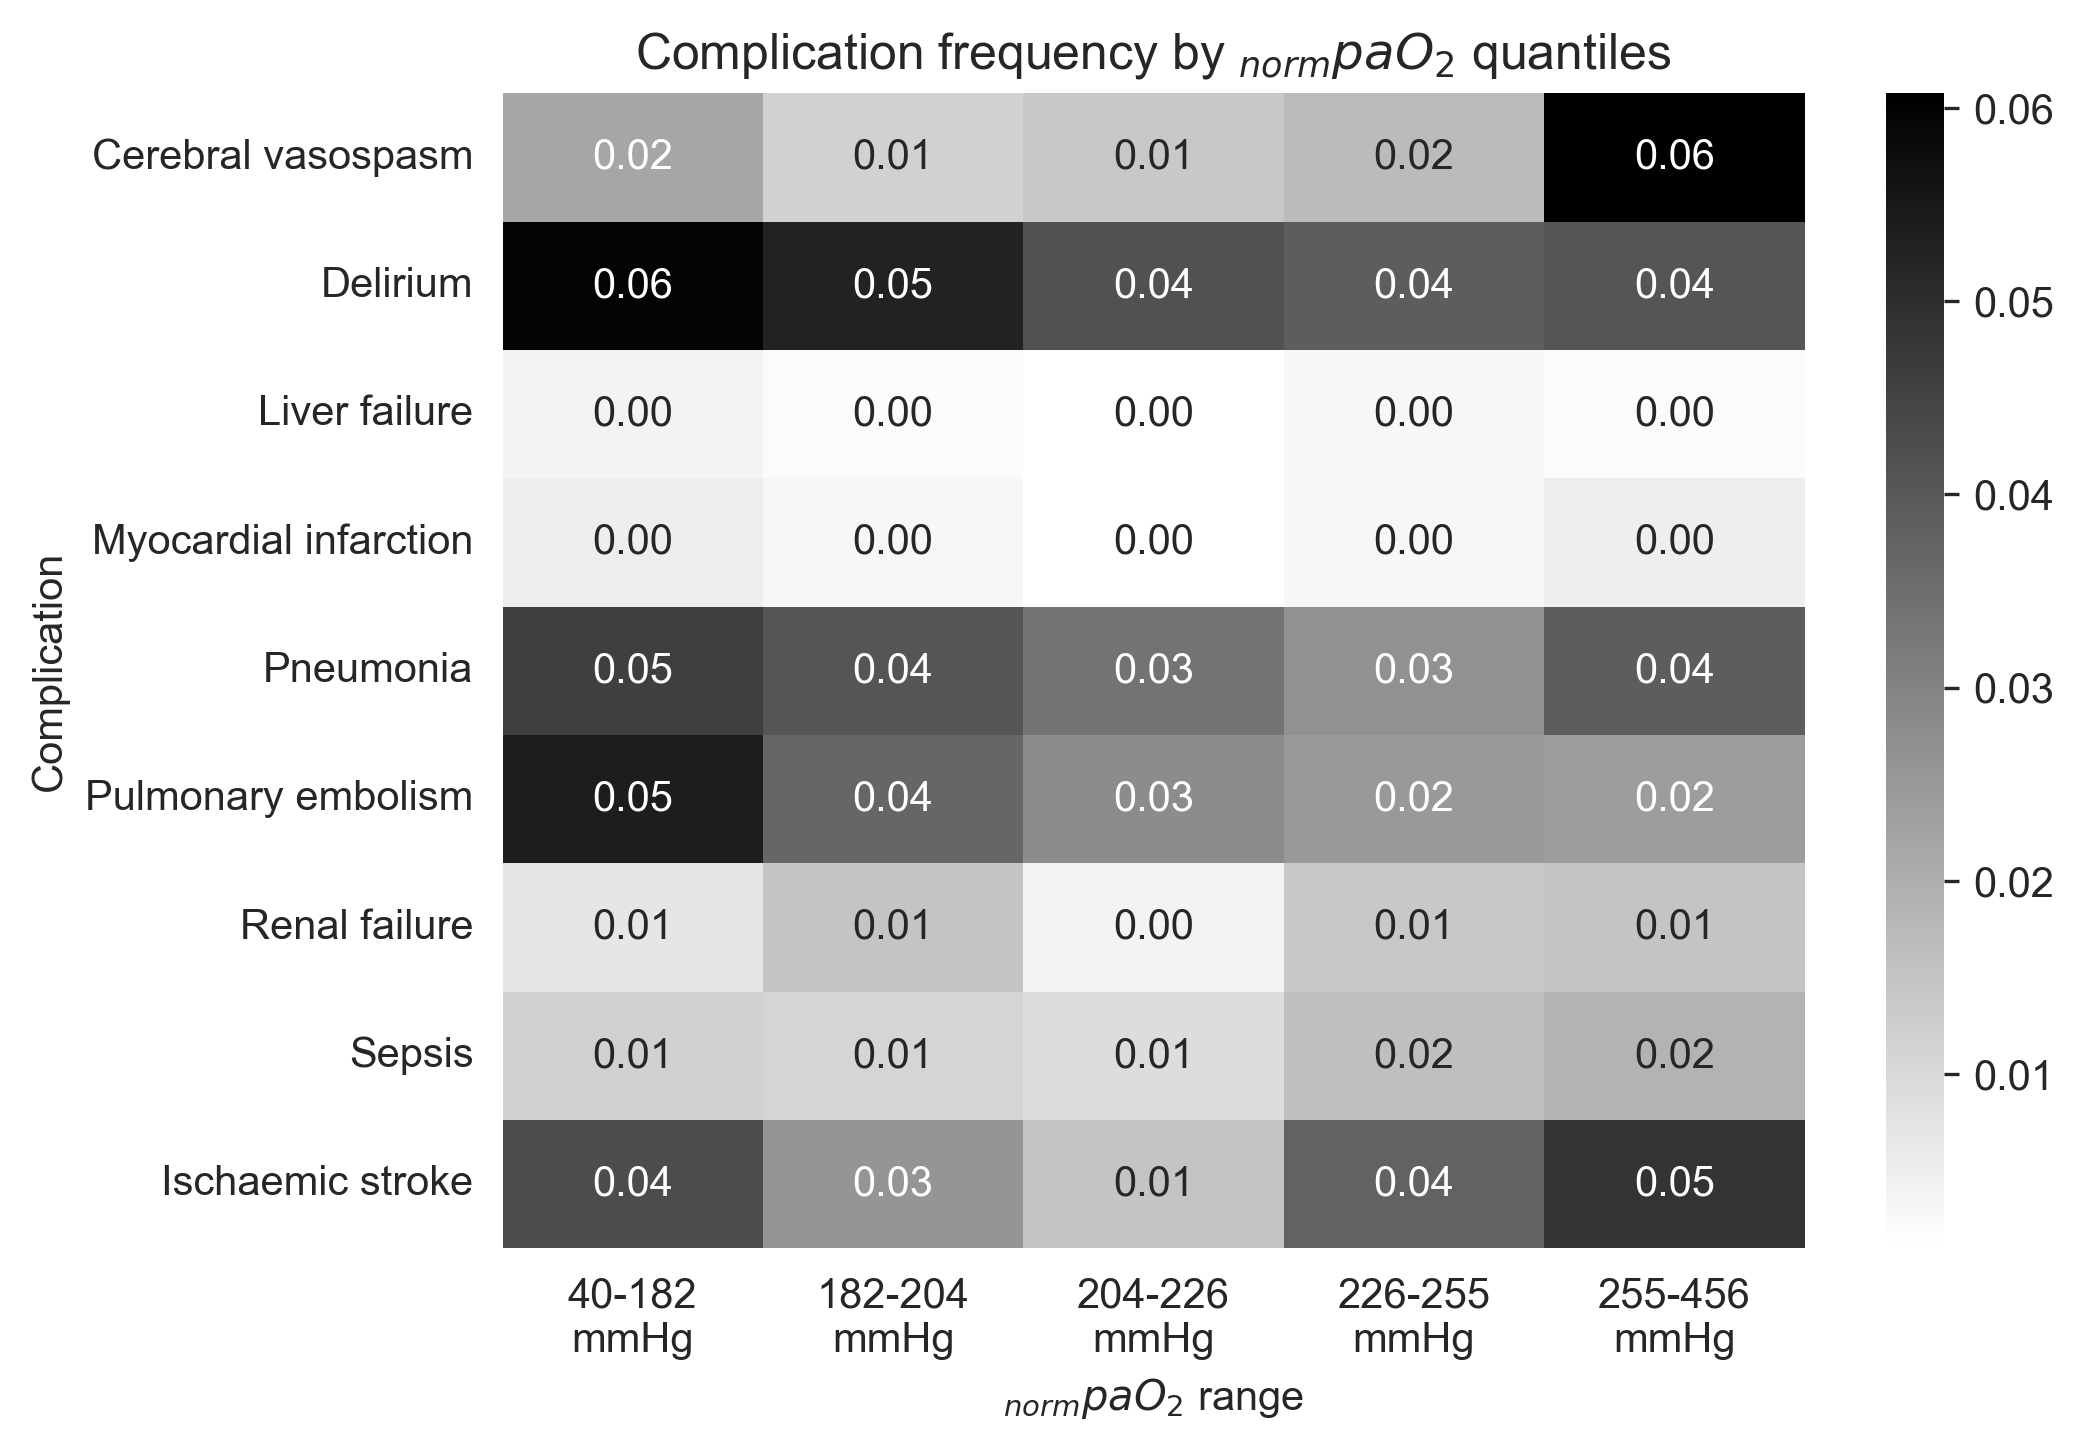

In [24]:
analysis_df['paO2_bin'], edges = pd.qcut(analysis_df['norm_auc_paO2'], q=5, labels=['low', 'mid-low', 'mid', 'mid-high', 'high'], retbins = True)
new_labels = []
for i, label in enumerate(['low', 'mid-low', 'mid', 'mid-high', 'high']):
    new_labels.append(f"""{round(edges[i])}-{round(edges[i+1])}\nmmHg""")

analysis_df['paO2_bin'] = analysis_df['paO2_bin'].replace({k:v for k,v in zip(['low', 'mid-low', 'mid', 'mid-high', 'high'], new_labels)})


comp_rate = analysis_df.groupby('paO2_bin')[list(complications)].mean()

ax = sns.heatmap(comp_rate.T, cmap = 'gray_r', annot=True, fmt=".2f")
ax.set_yticklabels([config.get('long_names')[i] for i in complications])
plt.xlabel("$_{norm}paO_2$ range")
plt.ylabel("Complication")
plt.savefig("plots/complication_frequency.png", dpi=300, bbox_inches="tight")
plt.title("Complication frequency by $_{norm}paO_2$ quantiles")

plt.show()

### 3.4.5 Differences in $paO_2$ between post-op Complications per Diagnosis

[40, 176, 196, 213, 237, 385]

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

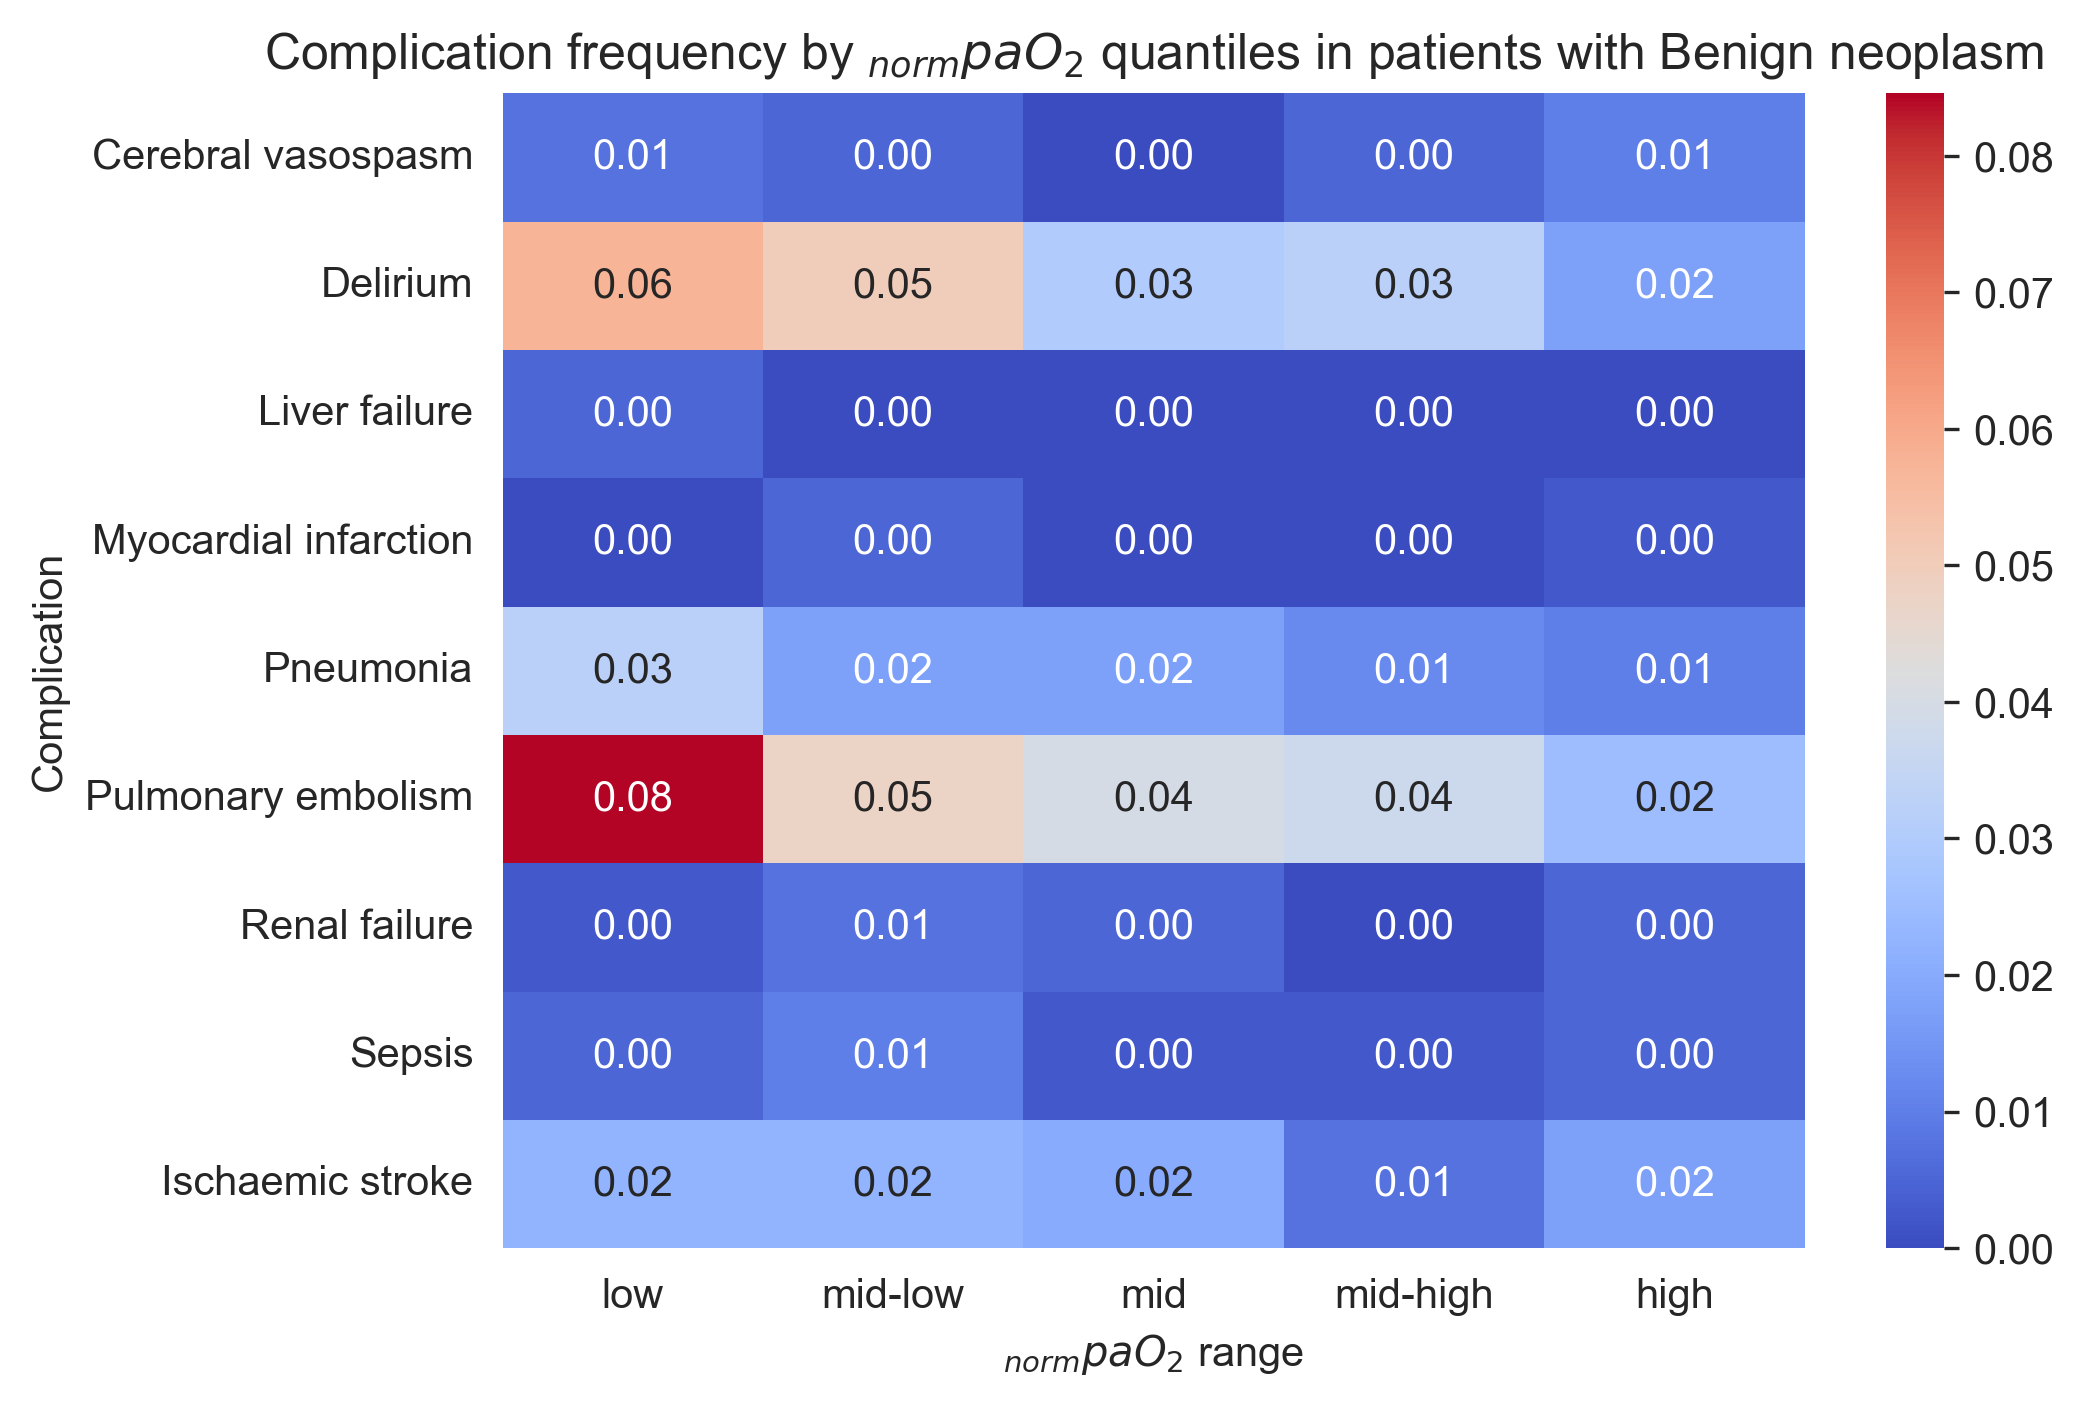


BENIGN_NEOPLASM -- CEREBRAL_VASOSPASM
Prevalence: 0.5 %
No significance found.

1, 2: Effect size: Hedges' g: 0.32 (small)

BENIGN_NEOPLASM -- DELIRIUM
Prevalence: 3.7 %
         norm_auc_paO2               
                median     mean count
delirium                             
False         205.2354 207.3571  1934
True          190.4433 196.1308    75

... Post hoc test...
    1   2
1   -  **
2  **   -
       1      2
1 1.0000 0.0017
2 0.0017 1.0000

1, 2: Effect size: Hedges' g: 0.3 (small)

Differences between patients with and without delirium in normalized perioperative auc values: 0.0017.
__________________________________________



BENIGN_NEOPLASM -- LIVER_FAILURE
Prevalence: 0.1 %
No significance found.

1, 2: Effect size: Hedges' g: 1.21 (very large)

BENIGN_NEOPLASM -- MYOCARDIAL_INFARCTION
Prevalence: 0.1 %
No significance found.

1, 2: Effect size: Hedges' g: 0.09 (very small)

BENIGN_NEOPLASM -- PNEUMONIA
Prevalence: 1.8 %
          norm_auc_paO2               
    

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

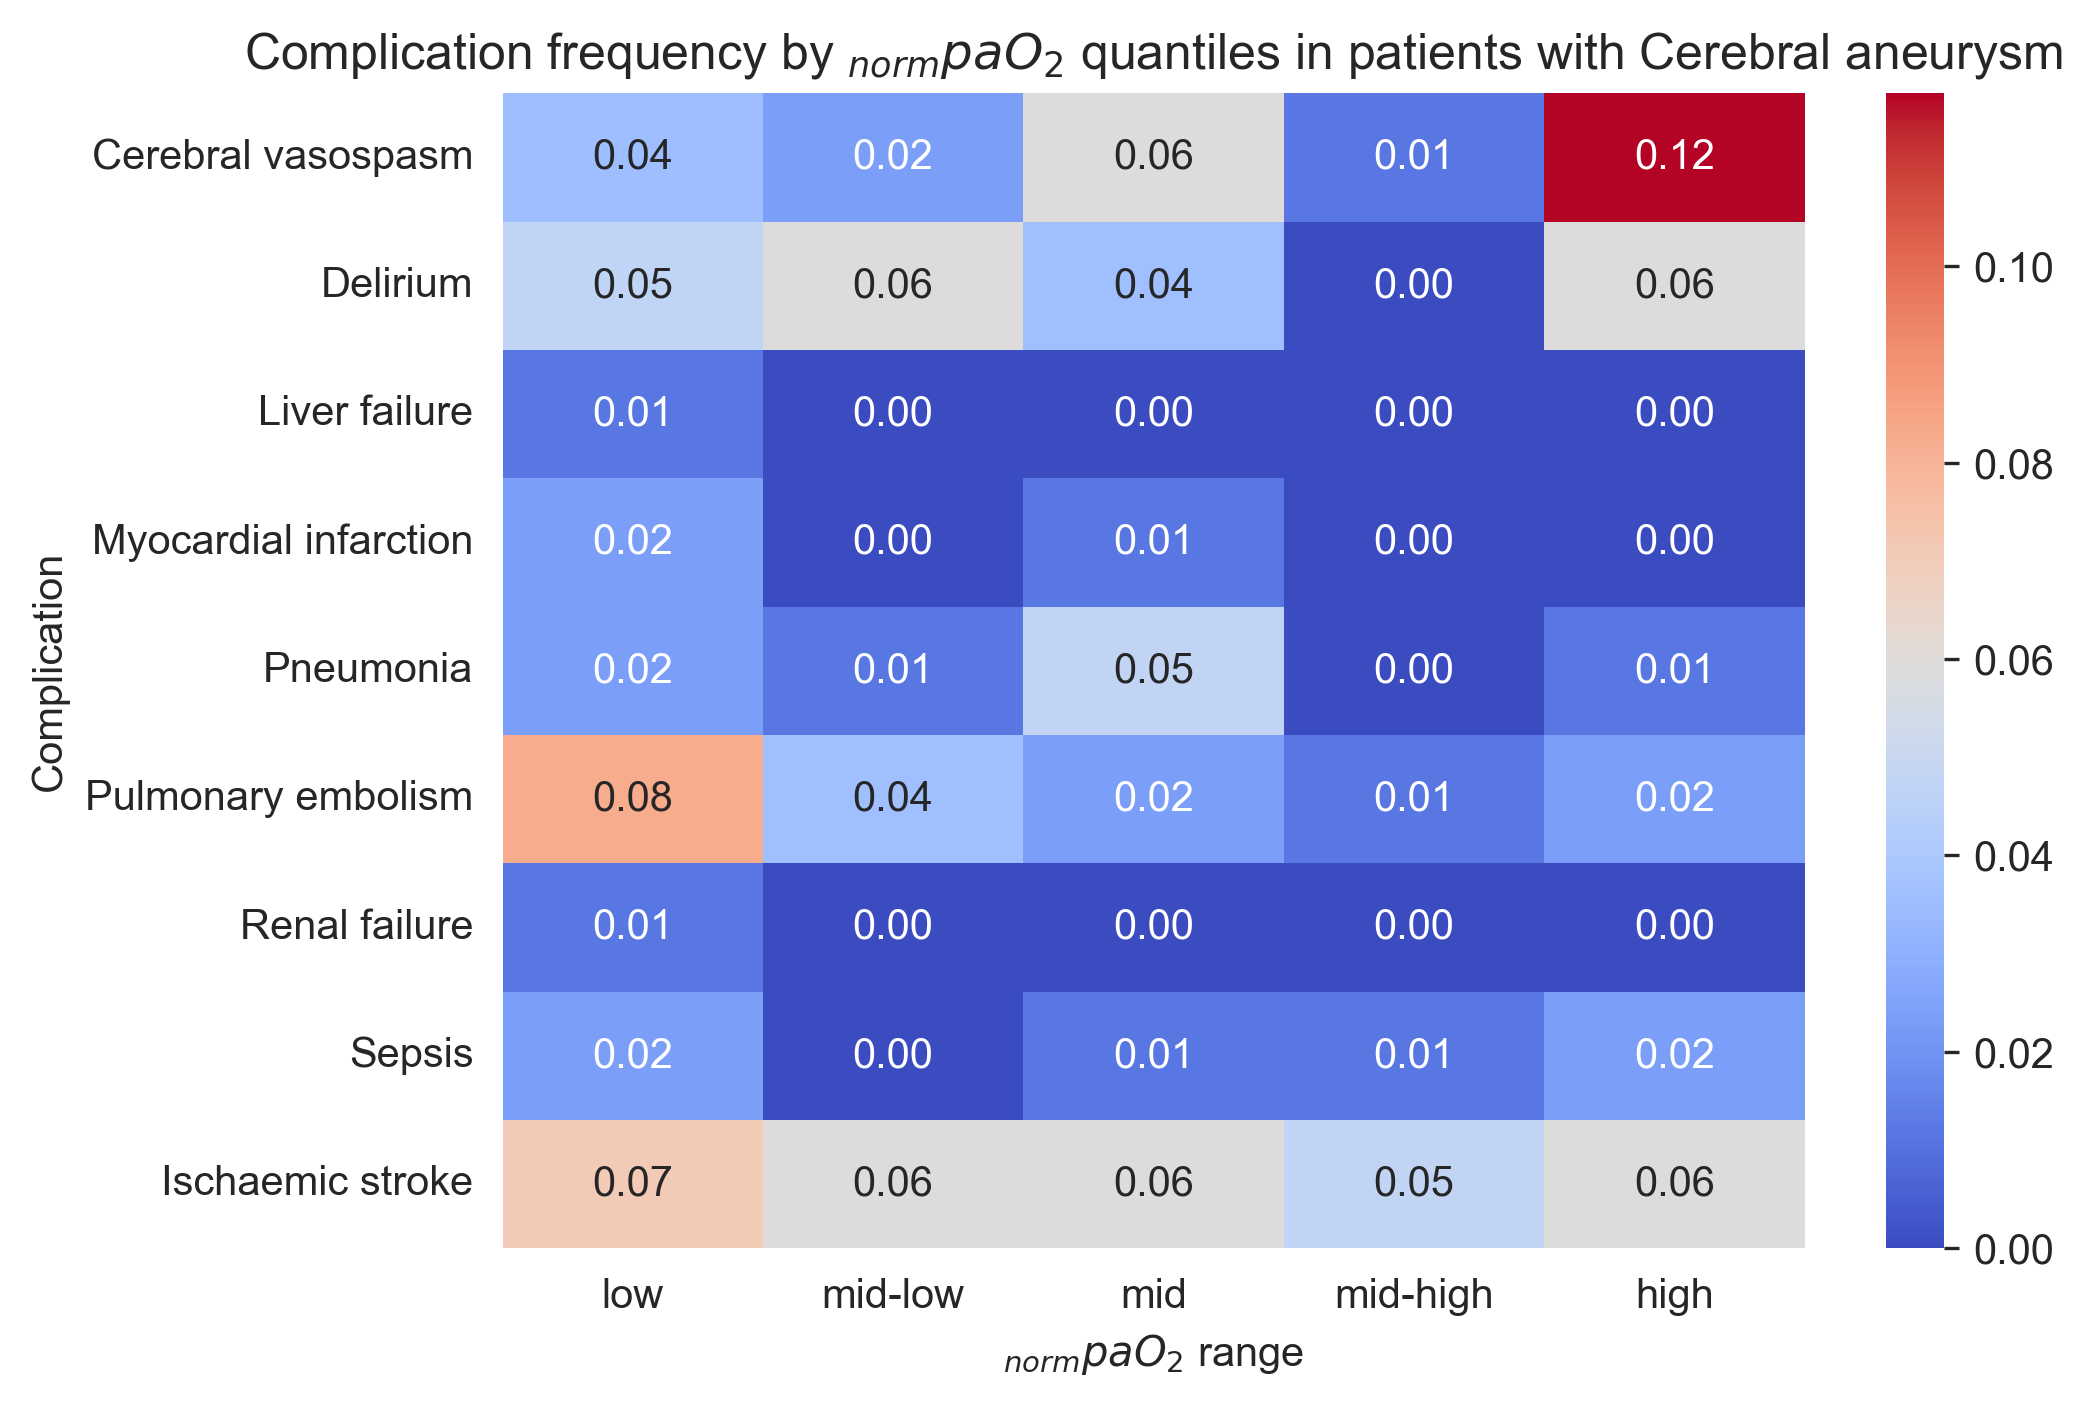


CEREBRAL_ANEURYSM -- CEREBRAL_VASOSPASM
Prevalence: 5.0 %
                   norm_auc_paO2               
                          median     mean count
cerebral_vasospasm                             
False                   273.0480 274.7388   401
True                    285.7723 304.3298    21

... Post hoc test...
    1   2
1   -  **
2  **   -
       1      2
1 1.0000 0.0100
2 0.0100 1.0000

1, 2: Effect size: Hedges' g: 0.74 (moderate)

Differences between patients with and without cerebral_vasospasm in normalized perioperative auc values: 0.01.
__________________________________________



CEREBRAL_ANEURYSM -- DELIRIUM
Prevalence: 4.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.05 (very small)

CEREBRAL_ANEURYSM -- LIVER_FAILURE
Prevalence: 0.2 %
No significance found.

1, 2: Effect size: Hedges' g: 1.2 (very large)

CEREBRAL_ANEURYSM -- MYOCARDIAL_INFARCTION
Prevalence: 0.7 %
No significance found.

1, 2: Effect size: Hedges' g: 0.98 (large)

CEREBRAL_ANEURYSM -- 

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

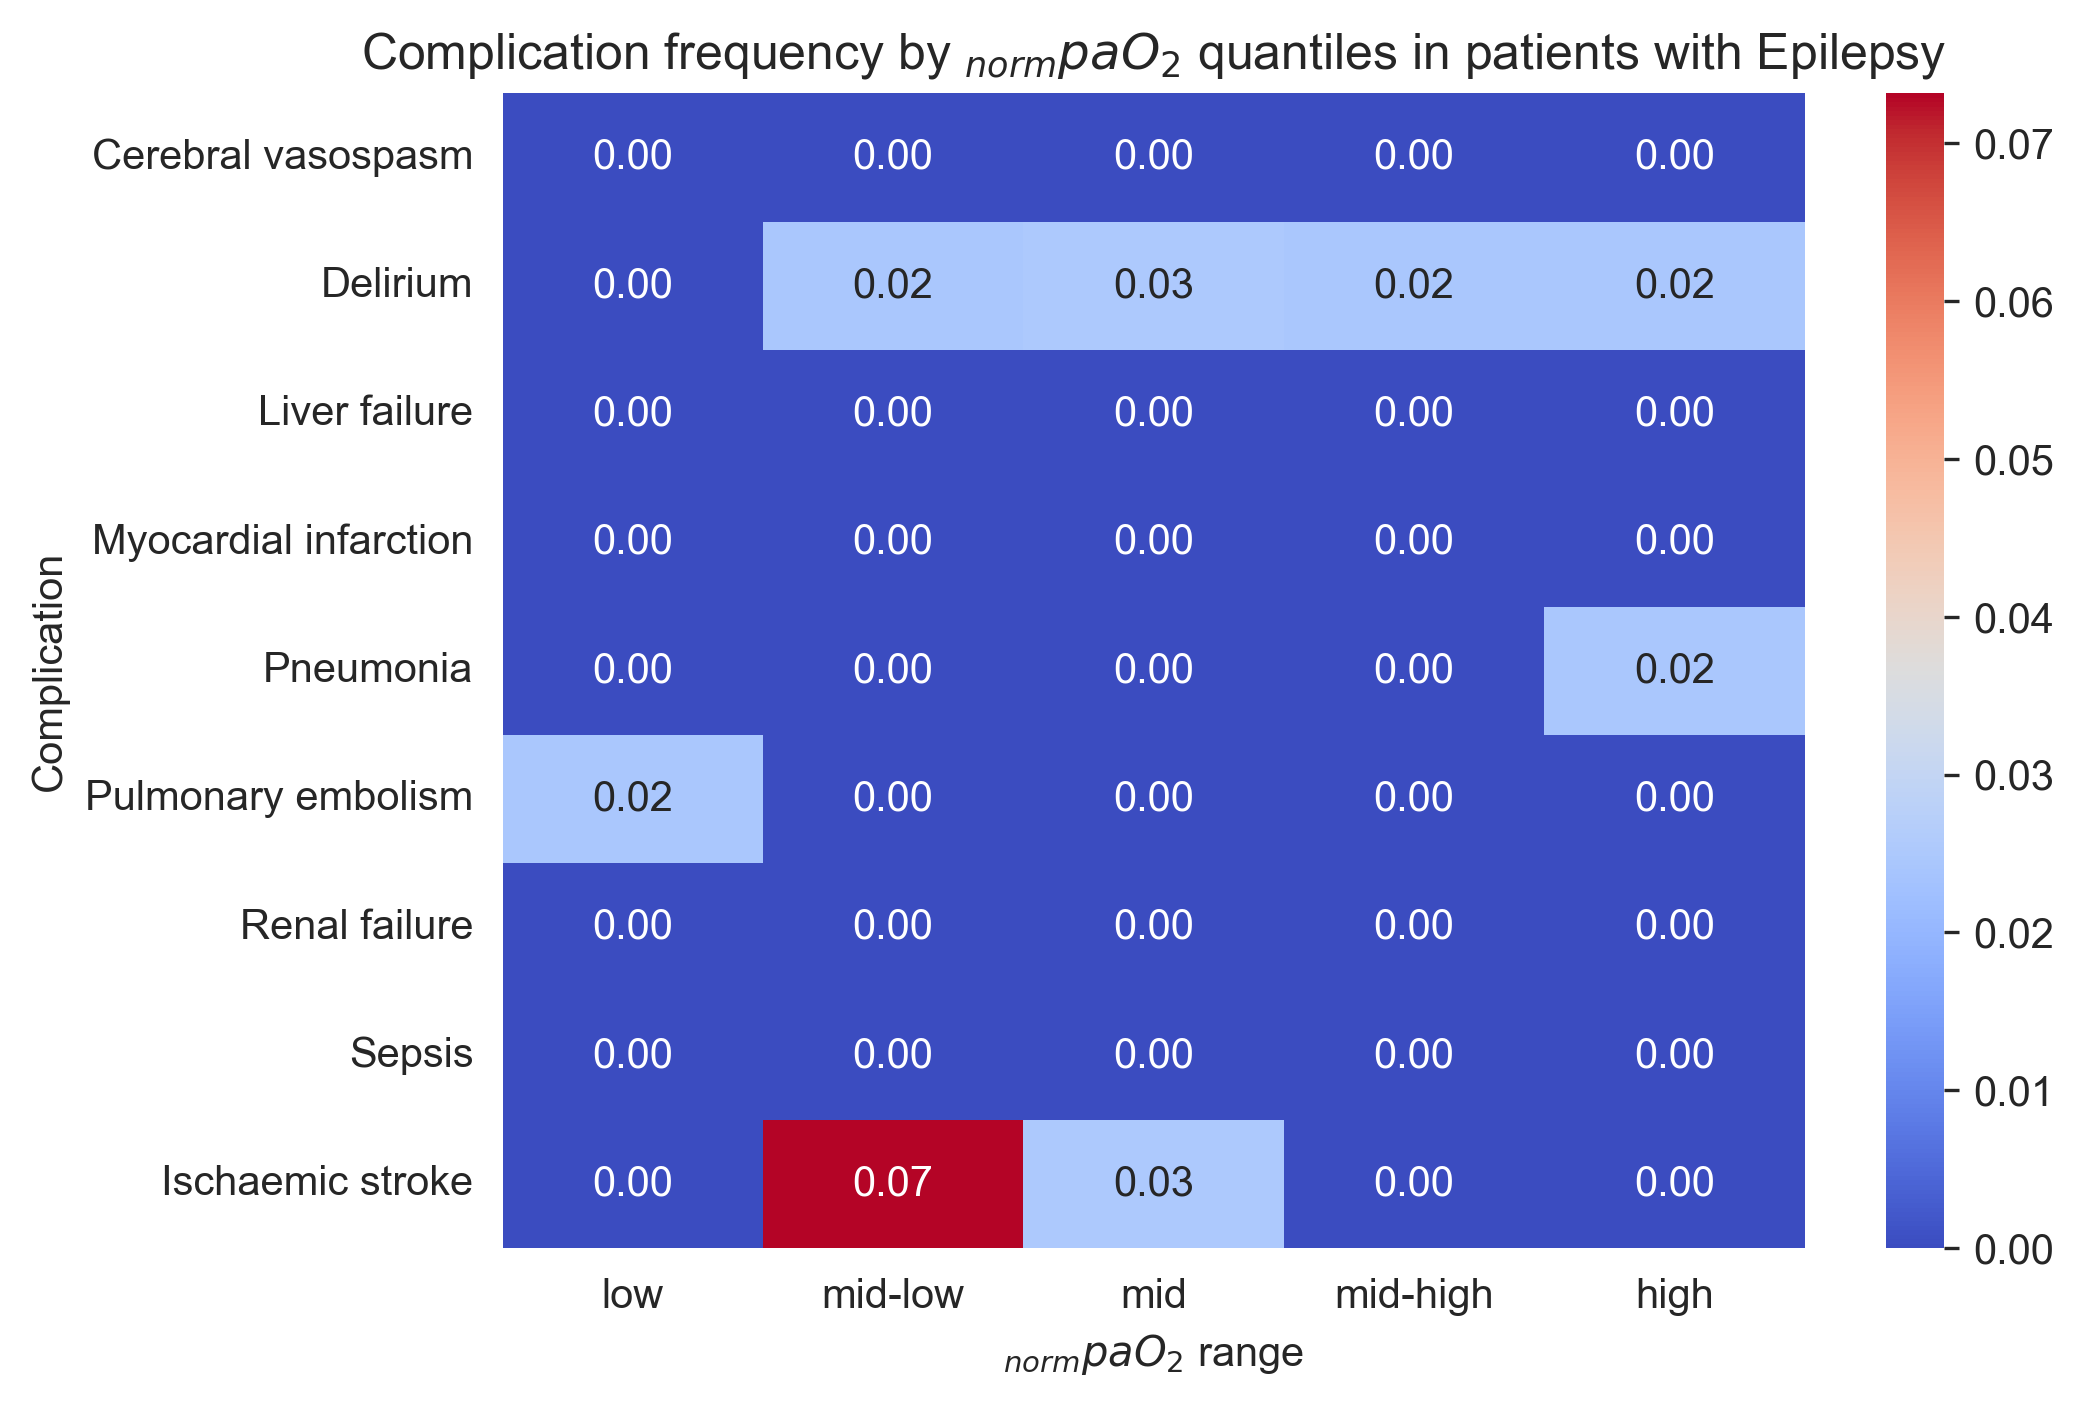


EPILEPSY -- CEREBRAL_VASOSPASM

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

Prevalence: 0.0 %
No significance found.

EPILEPSY -- DELIRIUM
Prevalence: 2.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.12 (very small)

EPILEPSY -- LIVER_FAILURE
Prevalence: 0.0 %
No significance found.

EPILEPSY -- MYOCARDIAL_INFARCTION
Prevalence: 0.0 %
No significance found.

EPILEPSY -- PNEUMONIA
Prevalence: 0.5 %
No significance found.

1, 2: Effect size: Hedges' g: 2.8 (huge)

EPILEPSY -- PULMONARY_EMBOLISM
Prevalence: 0.5 %
No significance found.

1, 2: Effect size: Hedges' g: 1.6 (very large)

EPILEPSY -- RENAL_FAILURE
Prevalence: 0.0 %
No significance found.

EPILEPSY -- SEPSIS
Prevalence: 0.0 %
No significance found.

EPILEPSY -- STROKE
Prevalence: 2.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.52 (moderate)
[112, 184, 206, 229, 255, 438]

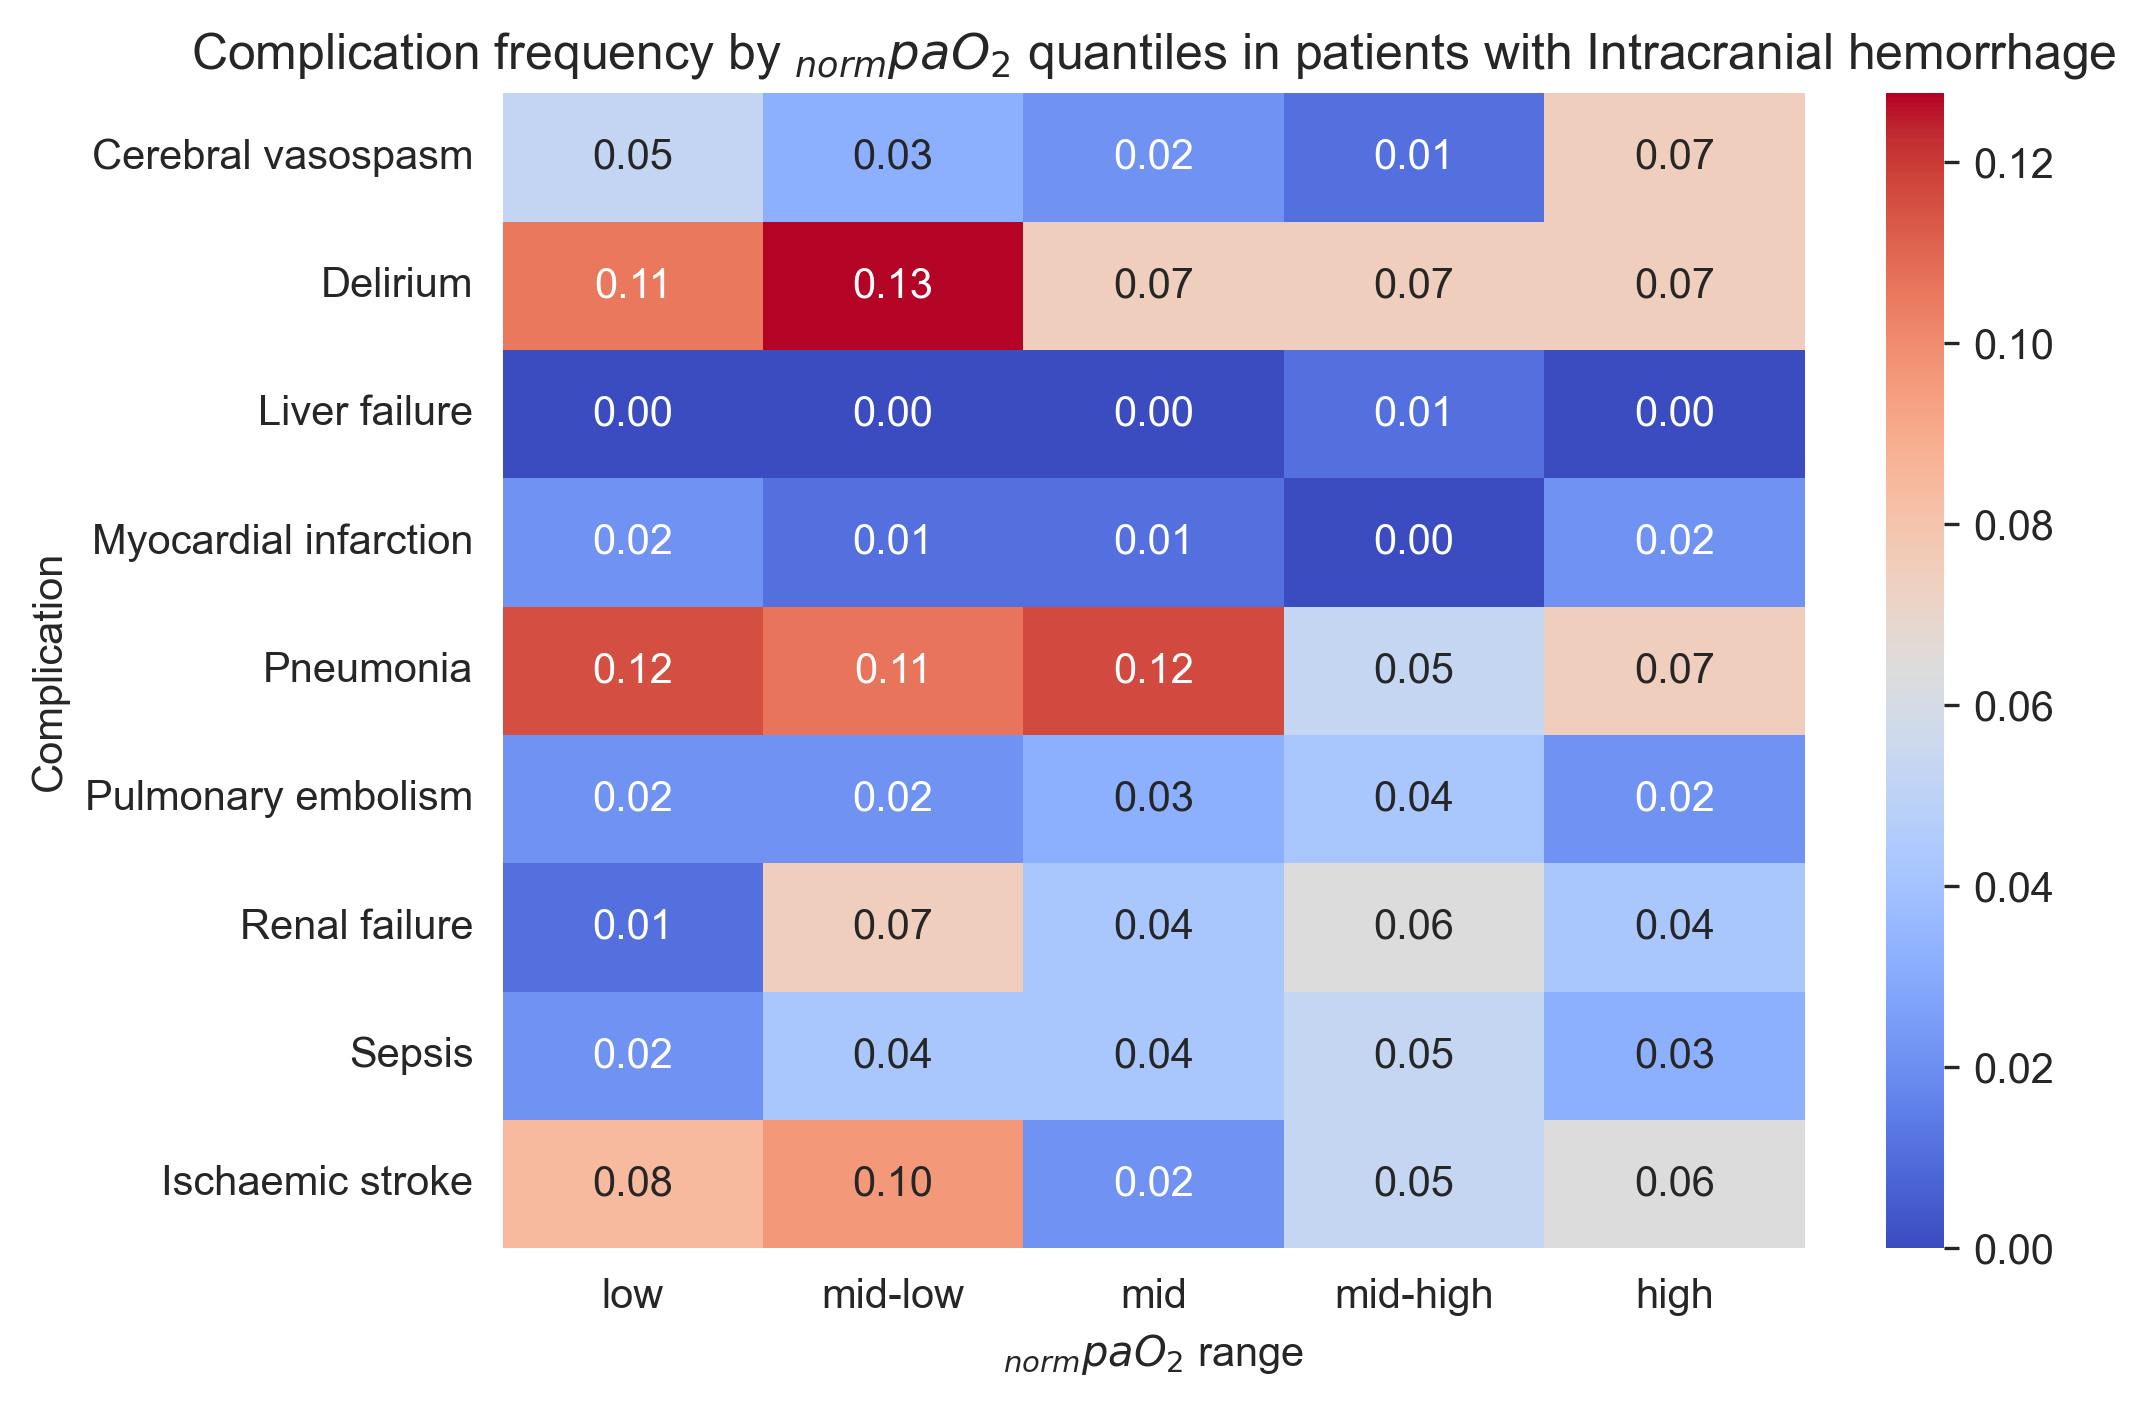


INTRACRANIAL_HEMORRHAGE -- CEREBRAL_VASOSPASM
Prevalence: 3.8 %
No significance found.

1, 2: Effect size: Hedges' g: 0.52 (moderate)

INTRACRANIAL_HEMORRHAGE -- DELIRIUM
Prevalence: 9.1 %
No significance found.

1, 2: Effect size: Hedges' g: 0.17 (very small)

INTRACRANIAL_HEMORRHAGE -- LIVER_FAILURE
Prevalence: 0.2 %
No significance found.

1, 2: Effect size: Hedges' g: 0.46 (small)

INTRACRANIAL_HEMORRHAGE -- MYOCARDIAL_INFARCTION

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

Prevalence: 1.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.21 (small)

INTRACRANIAL_HEMORRHAGE -- PNEUMONIA
Prevalence: 9.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.25 (small)

INTRACRANIAL_HEMORRHAGE -- PULMONARY_EMBOLISM
Prevalence: 2.8 %
No significance found.

1, 2: Effect size: Hedges' g: 0.19 (very small)

INTRACRANIAL_HEMORRHAGE -- RENAL_FAILURE
Prevalence: 4.7 %
No significance found.

1, 2: Effect size: Hedges' g: 0.23 (small)

INTRACRANIAL_HEMORRHAGE -- SEPSIS
Prevalence: 3.8 %
No significance found.

1, 2: Effect size: Hedges' g: 0.11 (very small)

INTRACRANIAL_HEMORRHAGE -- STROKE
Prevalence: 6.4 %
No significance found.

1, 2: Effect size: Hedges' g: 0.07 (very small)
[106, 182, 201, 218, 242, 398]

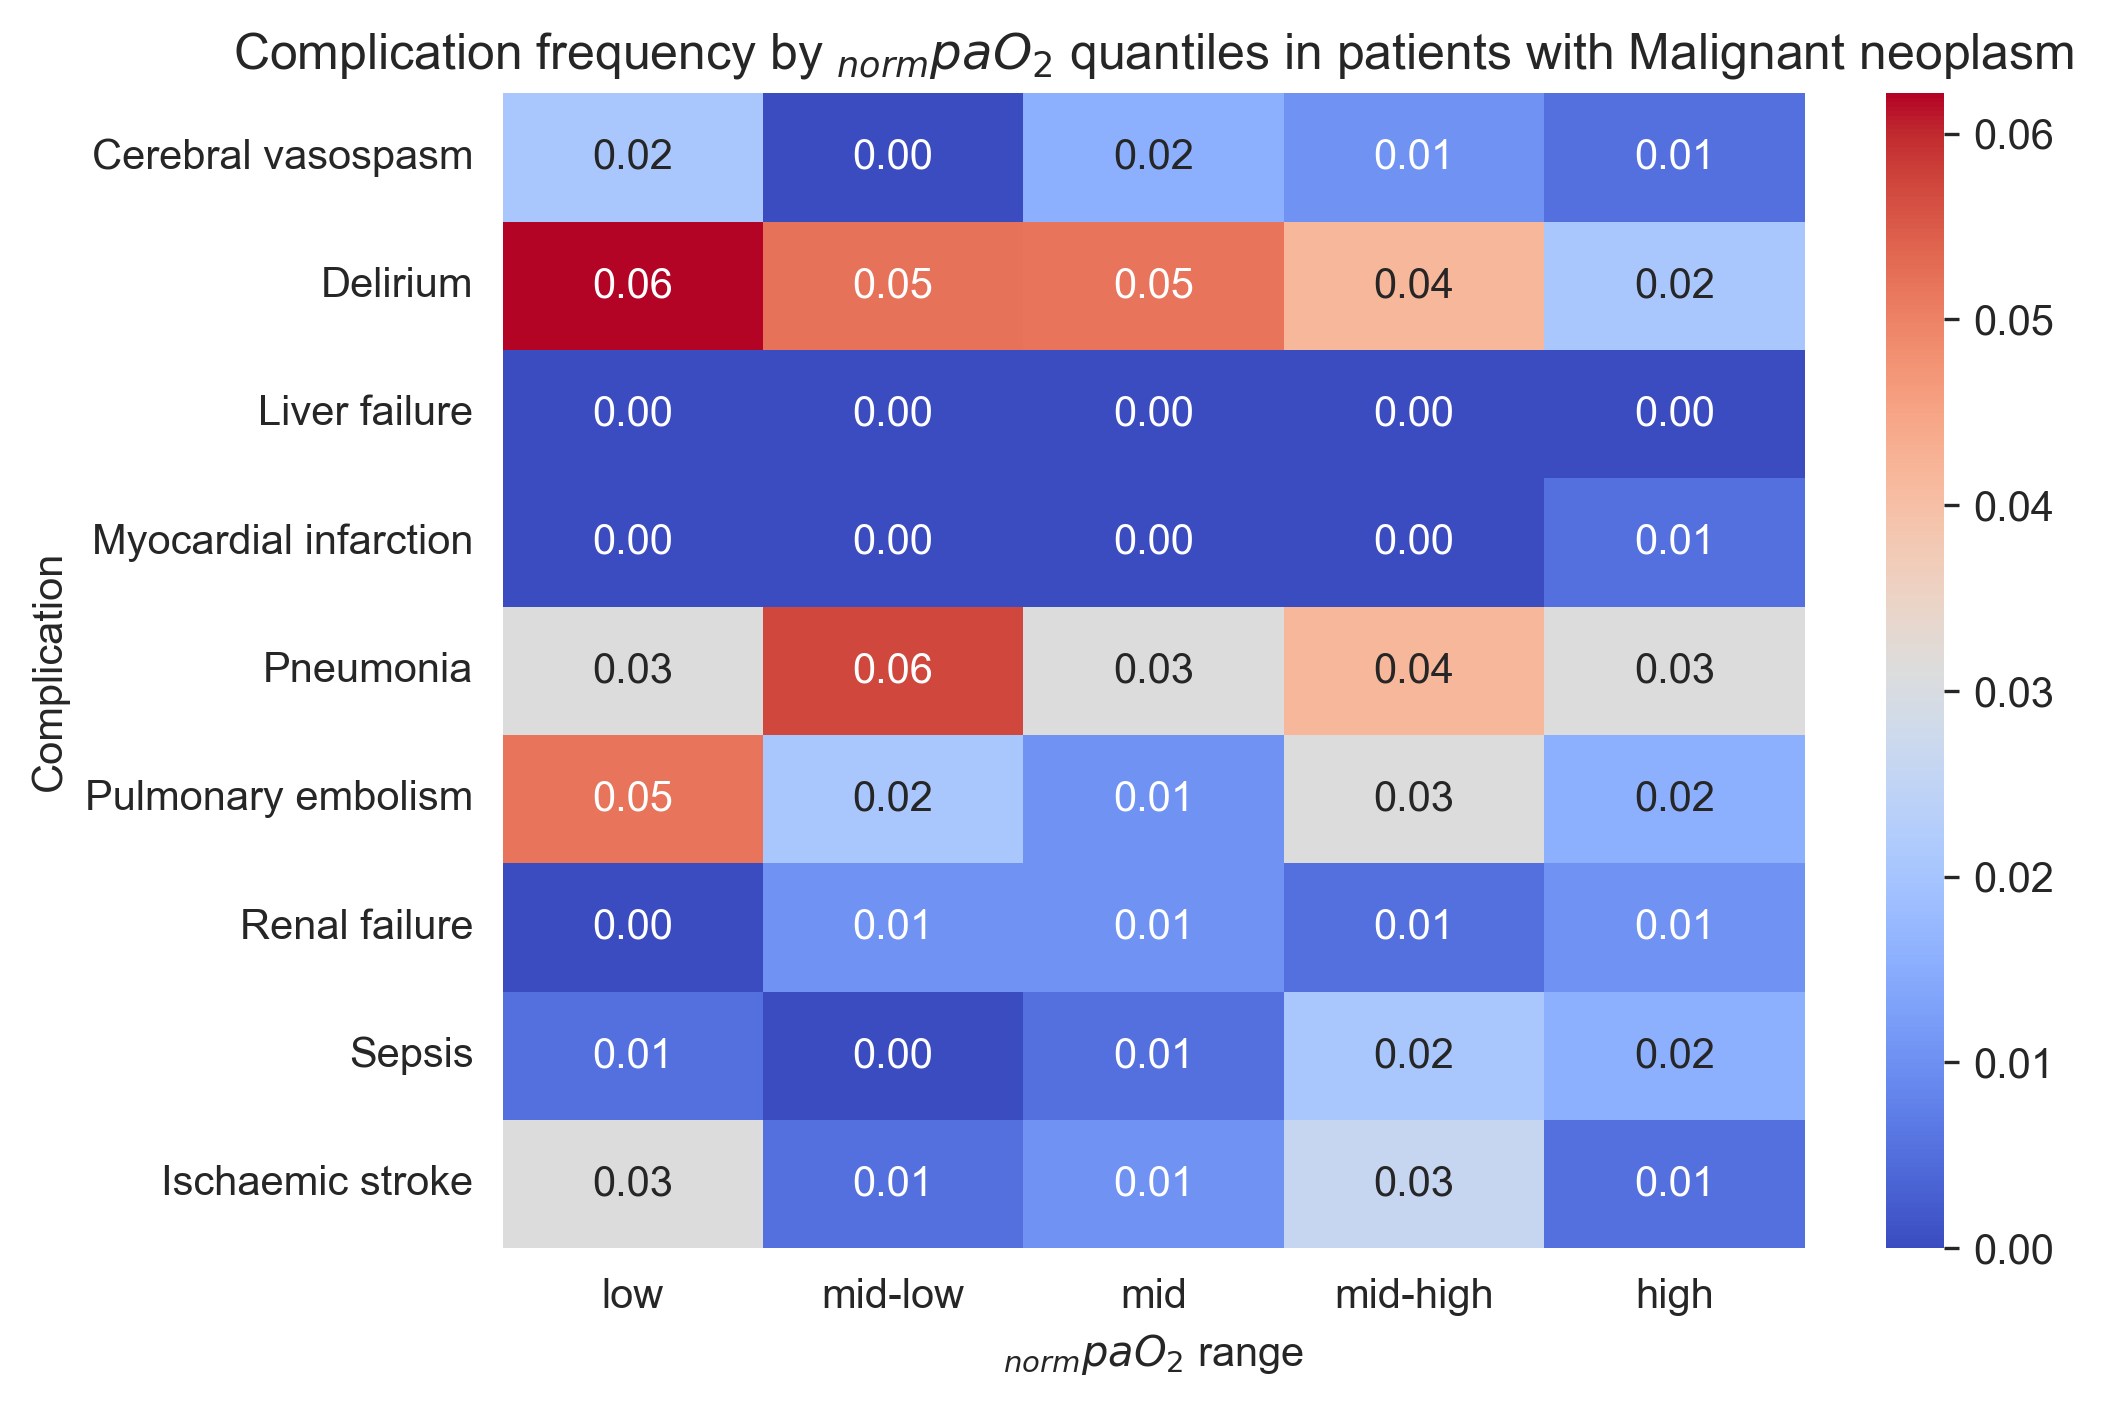


MALIGNANT_NEOPLASM -- CEREBRAL_VASOSPASM
Prevalence: 1.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.53 (moderate)

MALIGNANT_NEOPLASM -- DELIRIUM
Prevalence: 4.6 %
         norm_auc_paO2               
                median     mean count
delirium                             
False         210.4182 212.9666   919
True          201.2124 198.0485    44

... Post hoc test...
   1  2
1  -  *
2  *  -
       1      2
1 1.0000 0.0134
2 0.0134 1.0000

1, 2: Effect size: Hedges' g: 0.4 (small)

Differences between patients with and without delirium in normalized perioperative auc values: 0.0134.
__________________________________________



MALIGNANT_NEOPLASM -- LIVER_FAILURE
Prevalence: 0.0 %
No significance found.

MALIGNANT_NEOPLASM -- MYOCARDIAL_INFARCTION
Prevalence: 0.1 %
No significance found.

1, 2: Effect size: Hedges' g: 0.9 (large)

MALIGNANT_NEOPLASM -- PNEUMONIA
Prevalence: 3.8 %
No significance found.

1, 2: Effect size: Hedges' g: 0.09 (very small)

MALIGNANT_NEO

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

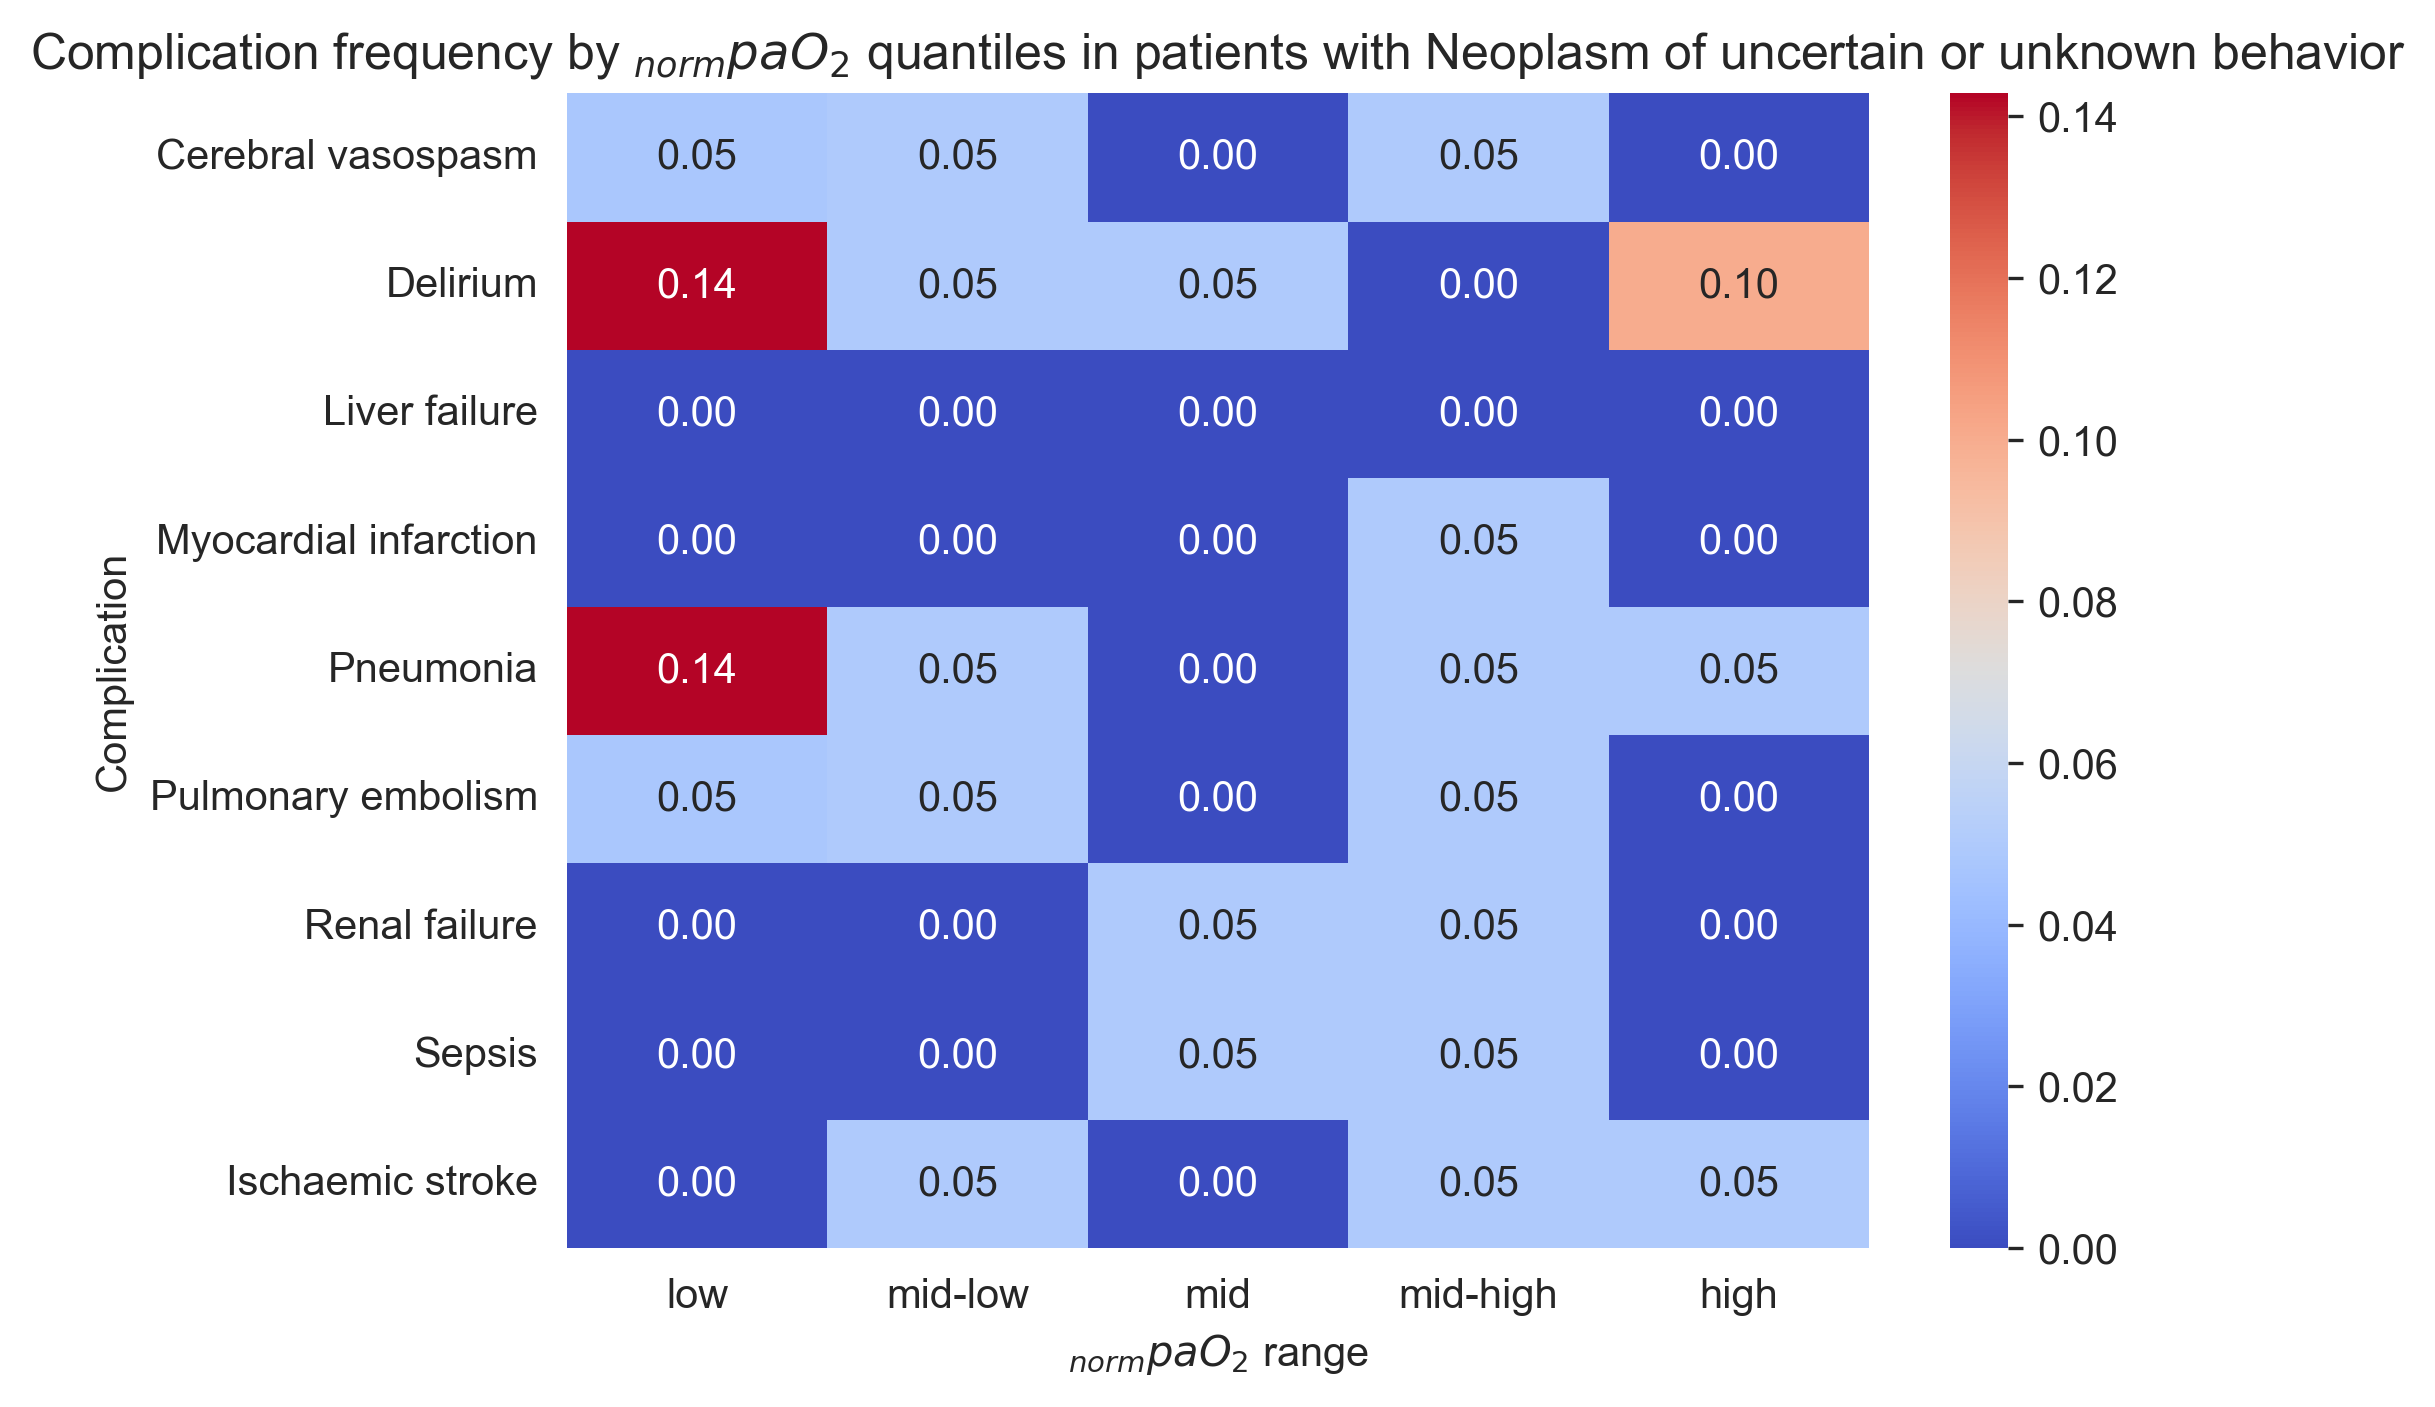


NEOPLASM -- CEREBRAL_VASOSPASM
Prevalence: 3.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.33 (small)

NEOPLASM -- DELIRIUM
Prevalence: 6.9 %
No significance found.

1, 2: Effect size: Hedges' g: 0.38 (small)

NEOPLASM -- LIVER_FAILURE
Prevalence: 0.0 %
No significance found.

NEOPLASM -- MYOCARDIAL_INFARCTION
Prevalence: 1.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.69 (moderate)

NEOPLASM -- PNEUMONIA
Prevalence: 5.9 %

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

No significance found.

1, 2: Effect size: Hedges' g: 0.08 (very small)

NEOPLASM -- PULMONARY_EMBOLISM
Prevalence: 3.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.64 (moderate)

NEOPLASM -- RENAL_FAILURE
Prevalence: 2.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.27 (small)

NEOPLASM -- SEPSIS
Prevalence: 2.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.32 (small)

NEOPLASM -- STROKE
Prevalence: 3.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.84 (large)
[40, 221, 255, 287, 331, 456]

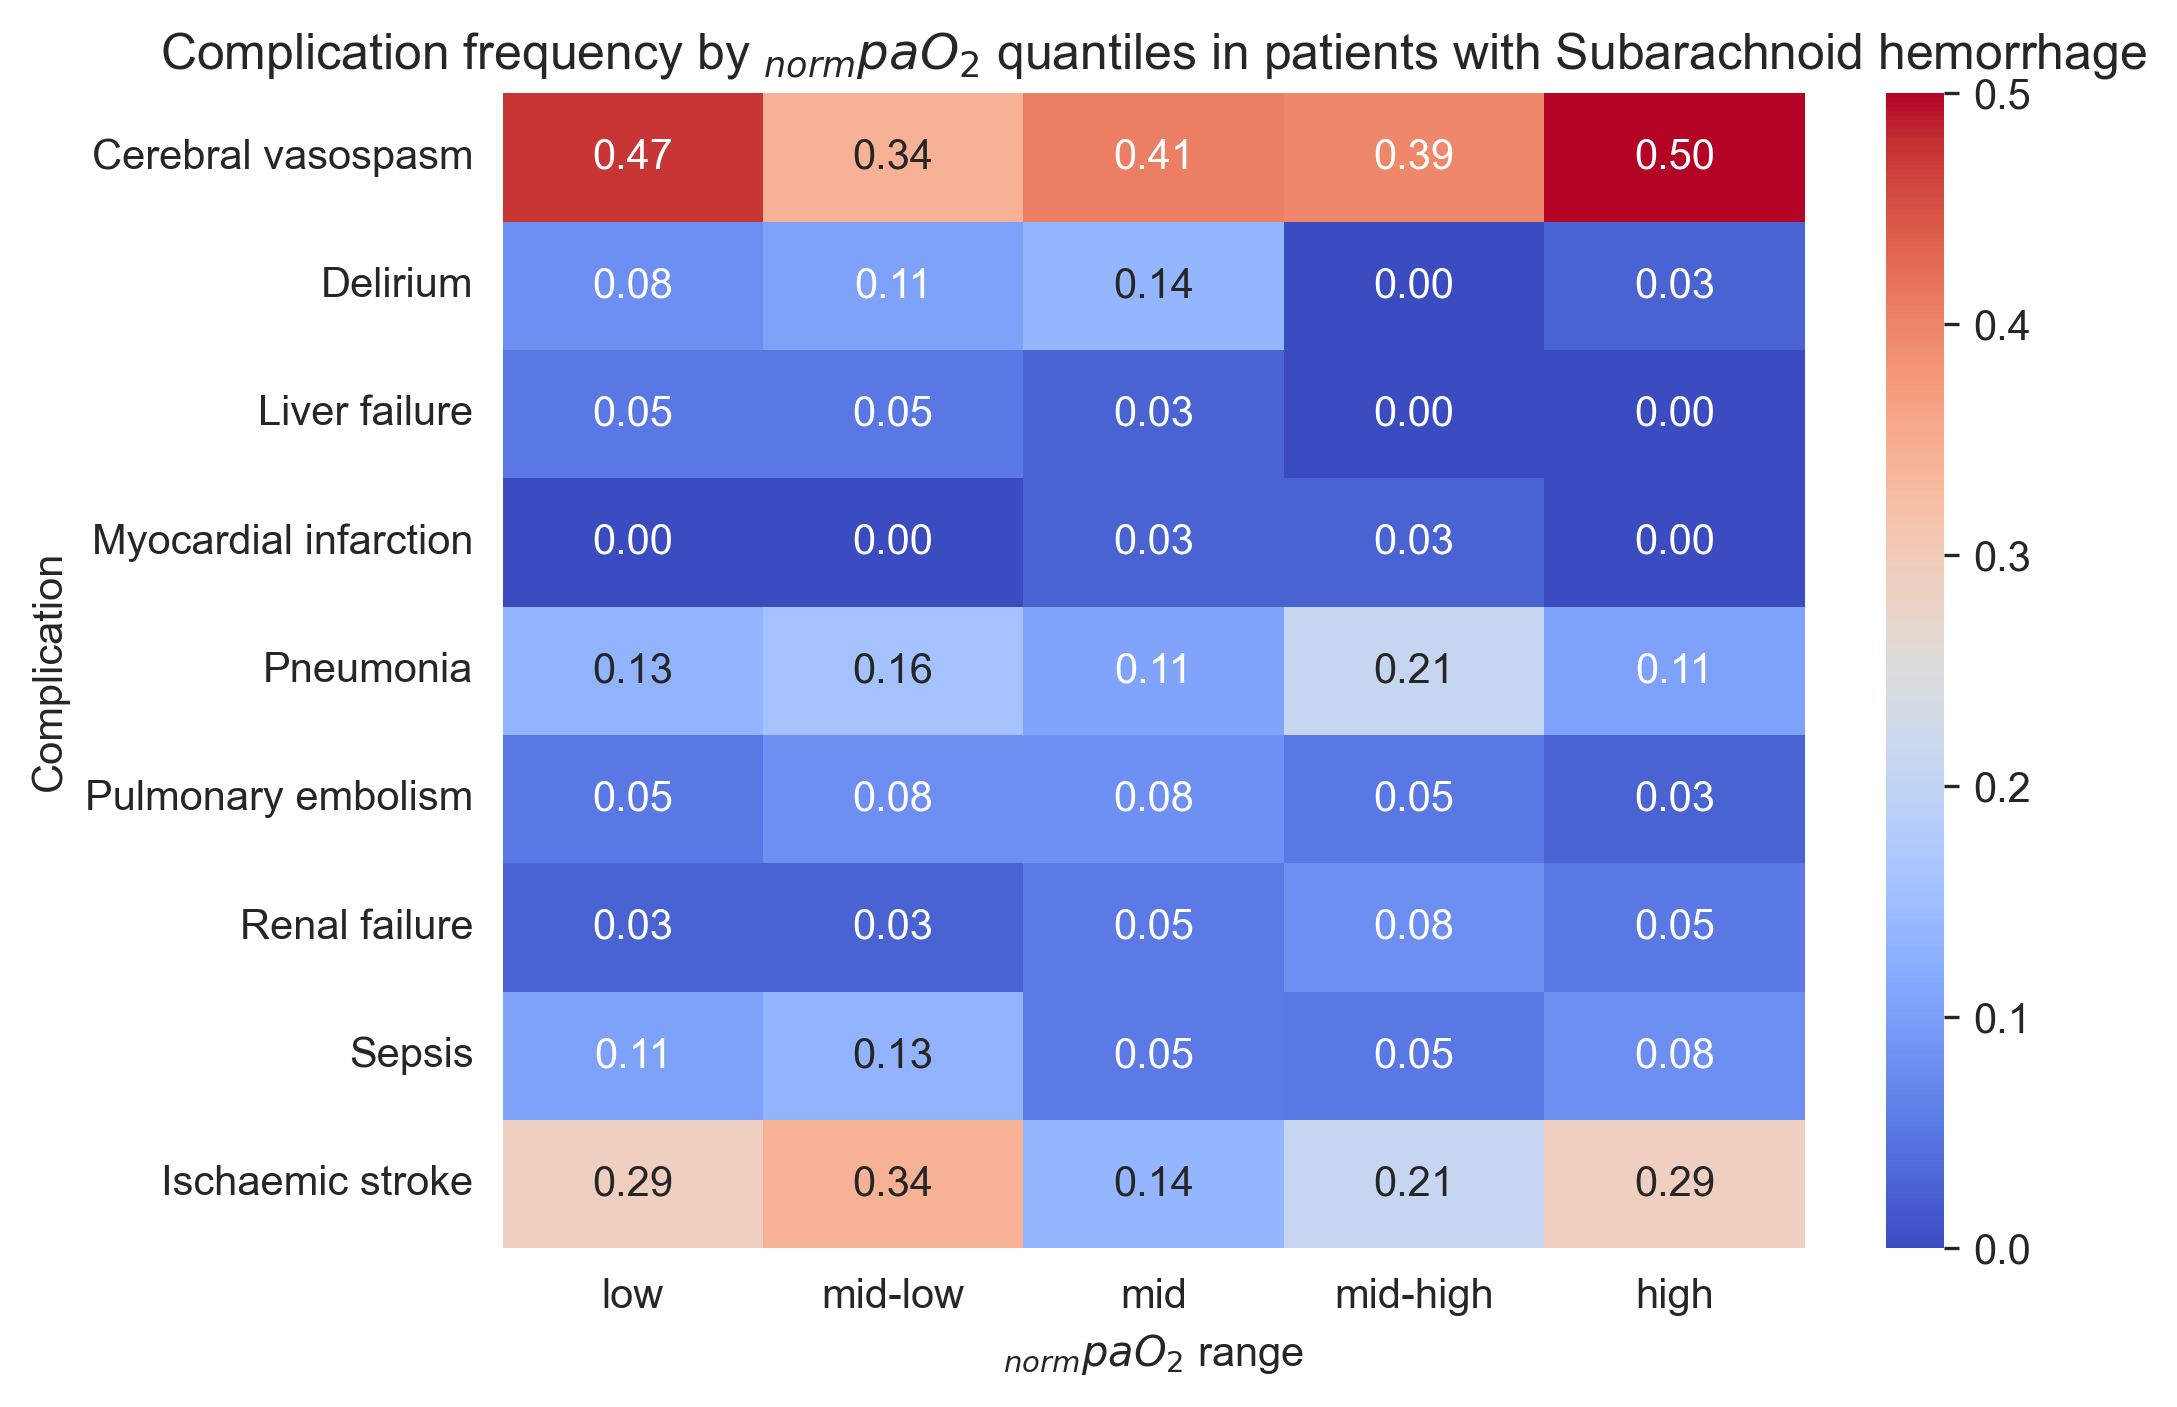


SAH -- CEREBRAL_VASOSPASM
Prevalence: 42.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.04 (very small)

SAH -- DELIRIUM
Prevalence: 6.9 %
No significance found.

1, 2: Effect size: Hedges' g: 0.39 (small)

SAH -- LIVER_FAILURE
Prevalence: 2.6 %
              norm_auc_paO2               
                     median     mean count
liver_failure                             
False              275.1263 273.1118   184
True               224.9450 214.6400     5

... Post hoc test...
   1  2
1  -  *
2  *  -
       1      2
1 1.0000 0.0299
2 0.0299 1.0000

1, 2: Effect size: Hedges' g: 0.89 (large)

Differences between patients with and without liver_failure in normalized perioperative auc values: 0.0299.
__________________________________________



SAH -- MYOCARDIAL_INFARCTION
Prevalence: 1.1 %
No significance found.

1, 2: Effect size: Hedges' g: 0.16 (very small)

SAH -- PNEUMONIA
Prevalence: 14.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.04 (very small)

SAH

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

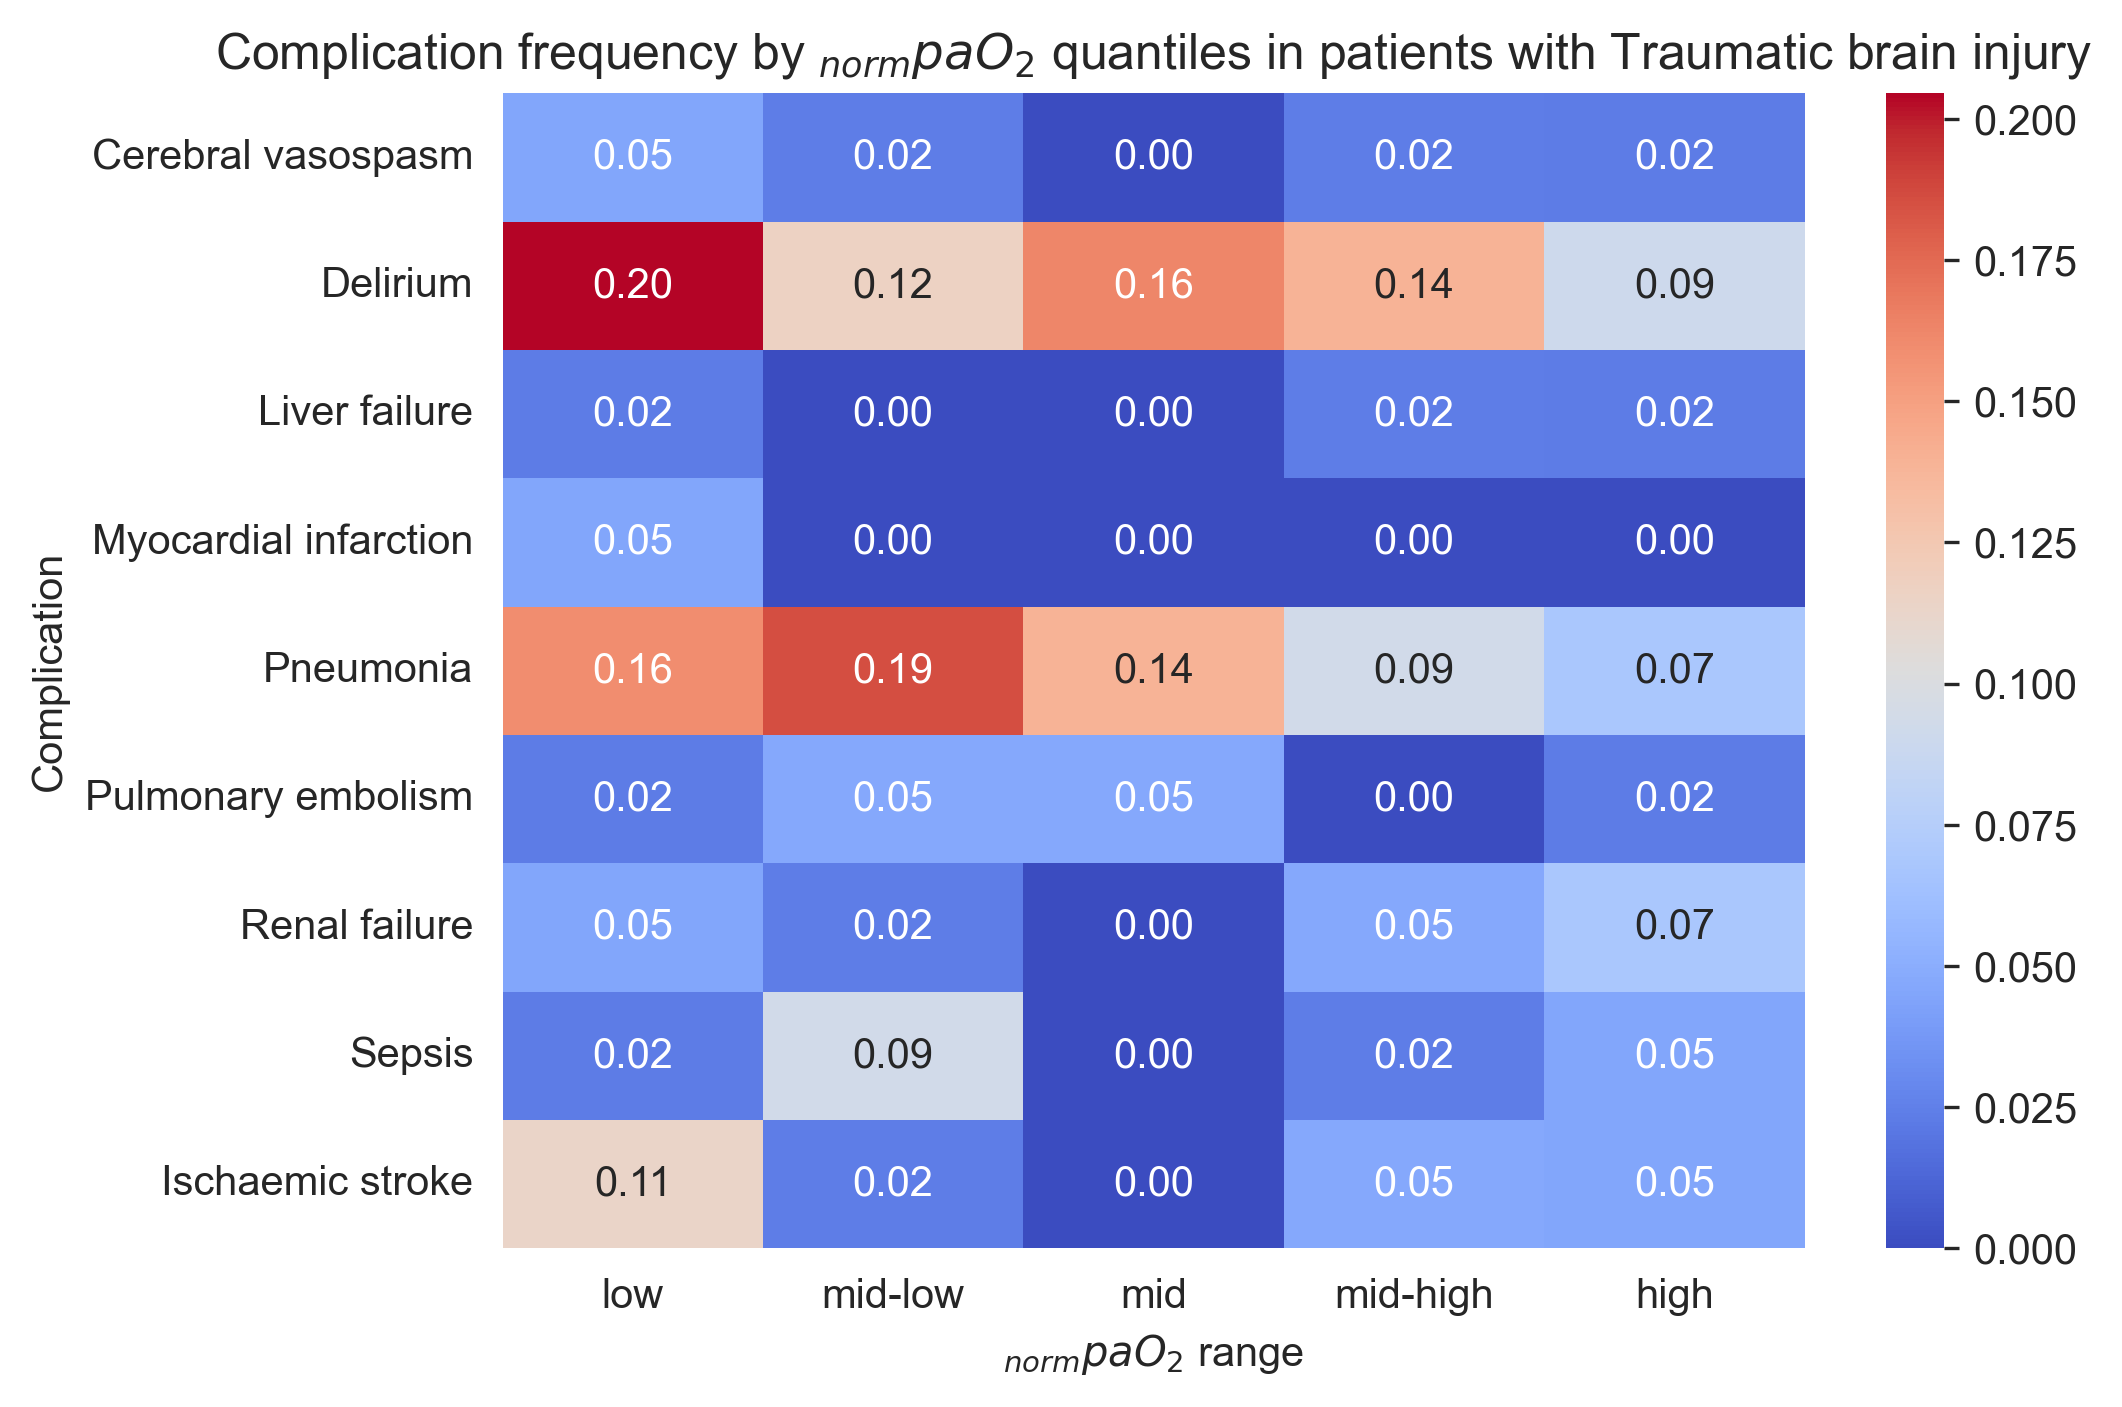


TBI -- CEREBRAL_VASOSPASM
Prevalence: 2.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.44 (small)

TBI -- DELIRIUM
Prevalence: 14.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.23 (small)

TBI -- LIVER_FAILURE
Prevalence: 1.4 %
No significance found.

1, 2: Effect size: Hedges' g: 0.07 (very small)

TBI -- MYOCARDIAL_INFARCTION
Prevalence: 0.9 %
No significance found.

1, 2: Effect size: Hedges' g: 1.16 (large)

TBI -- PNEUMONIA
Prevalence: 12.9 %
No significance found.

1, 2: Effect size: Hedges' g: 0.28 (small)

TBI -- PULMONARY_EMBOLISM
Prevalence: 2.8 %
No significance found.

1, 2: Hedges' g <0.01

TBI -- RENAL_FAILURE
Prevalence: 3.7 %
No significance found.

1, 2: Effect size: Hedges' g: 0.26 (small)

TBI -- SEPSIS
Prevalence: 3.7 %
No significance found.

1, 2: Effect size: Hedges' g: 0.1 (very small)

TBI -- STROKE
Prevalence: 4.6 %
No significance found.

1, 2: Effect size: Hedges' g: 0.36 (small)
[132, 182, 212, 232, 264, 358]

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

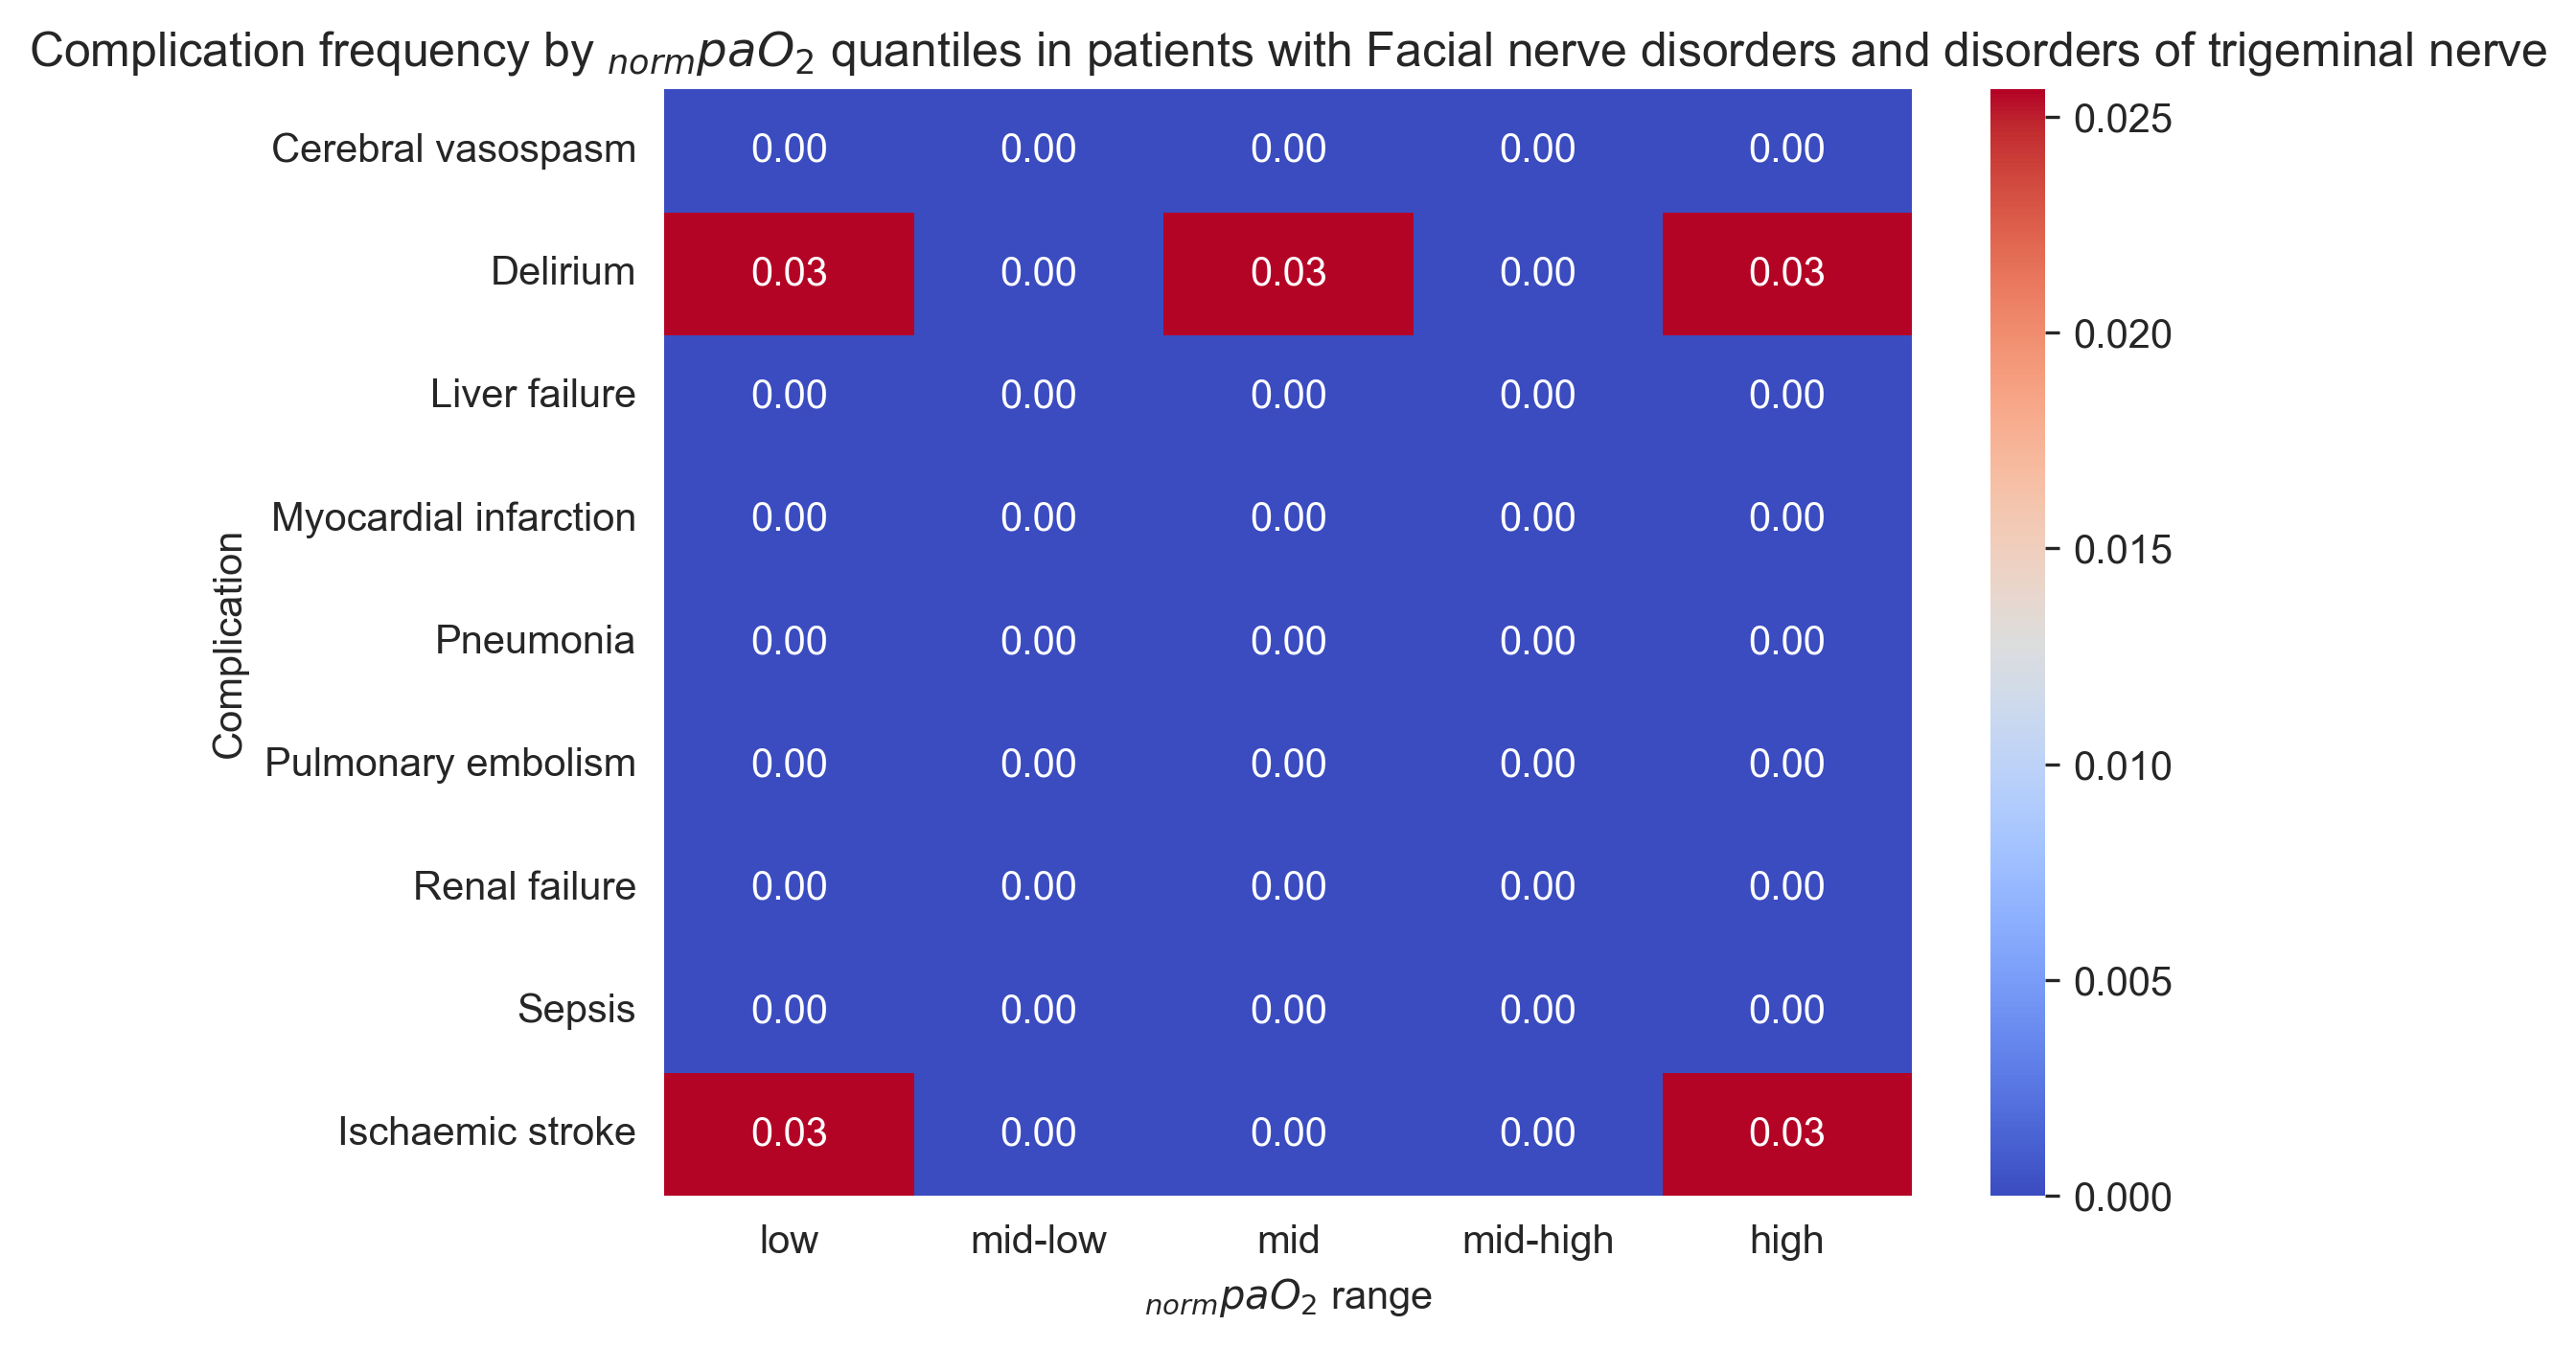


TRIGEMINUS -- CEREBRAL_VASOSPASM
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- DELIRIUM
Prevalence: 1.6 %
No significance found.

1, 2: Effect size: Hedges' g: 0.23 (small)

TRIGEMINUS -- LIVER_FAILURE
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- MYOCARDIAL_INFARCTION
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- PNEUMONIA
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- PULMONARY_EMBOLISM
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- RENAL_FAILURE
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- SEPSIS
Prevalence: 0.0 %
No significance found.

TRIGEMINUS -- STROKE
Prevalence: 1.0 %

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

No significance found.

1, 2: Effect size: Hedges' g: 0.25 (small)
[161, 265, 276, 295, 315, 327]

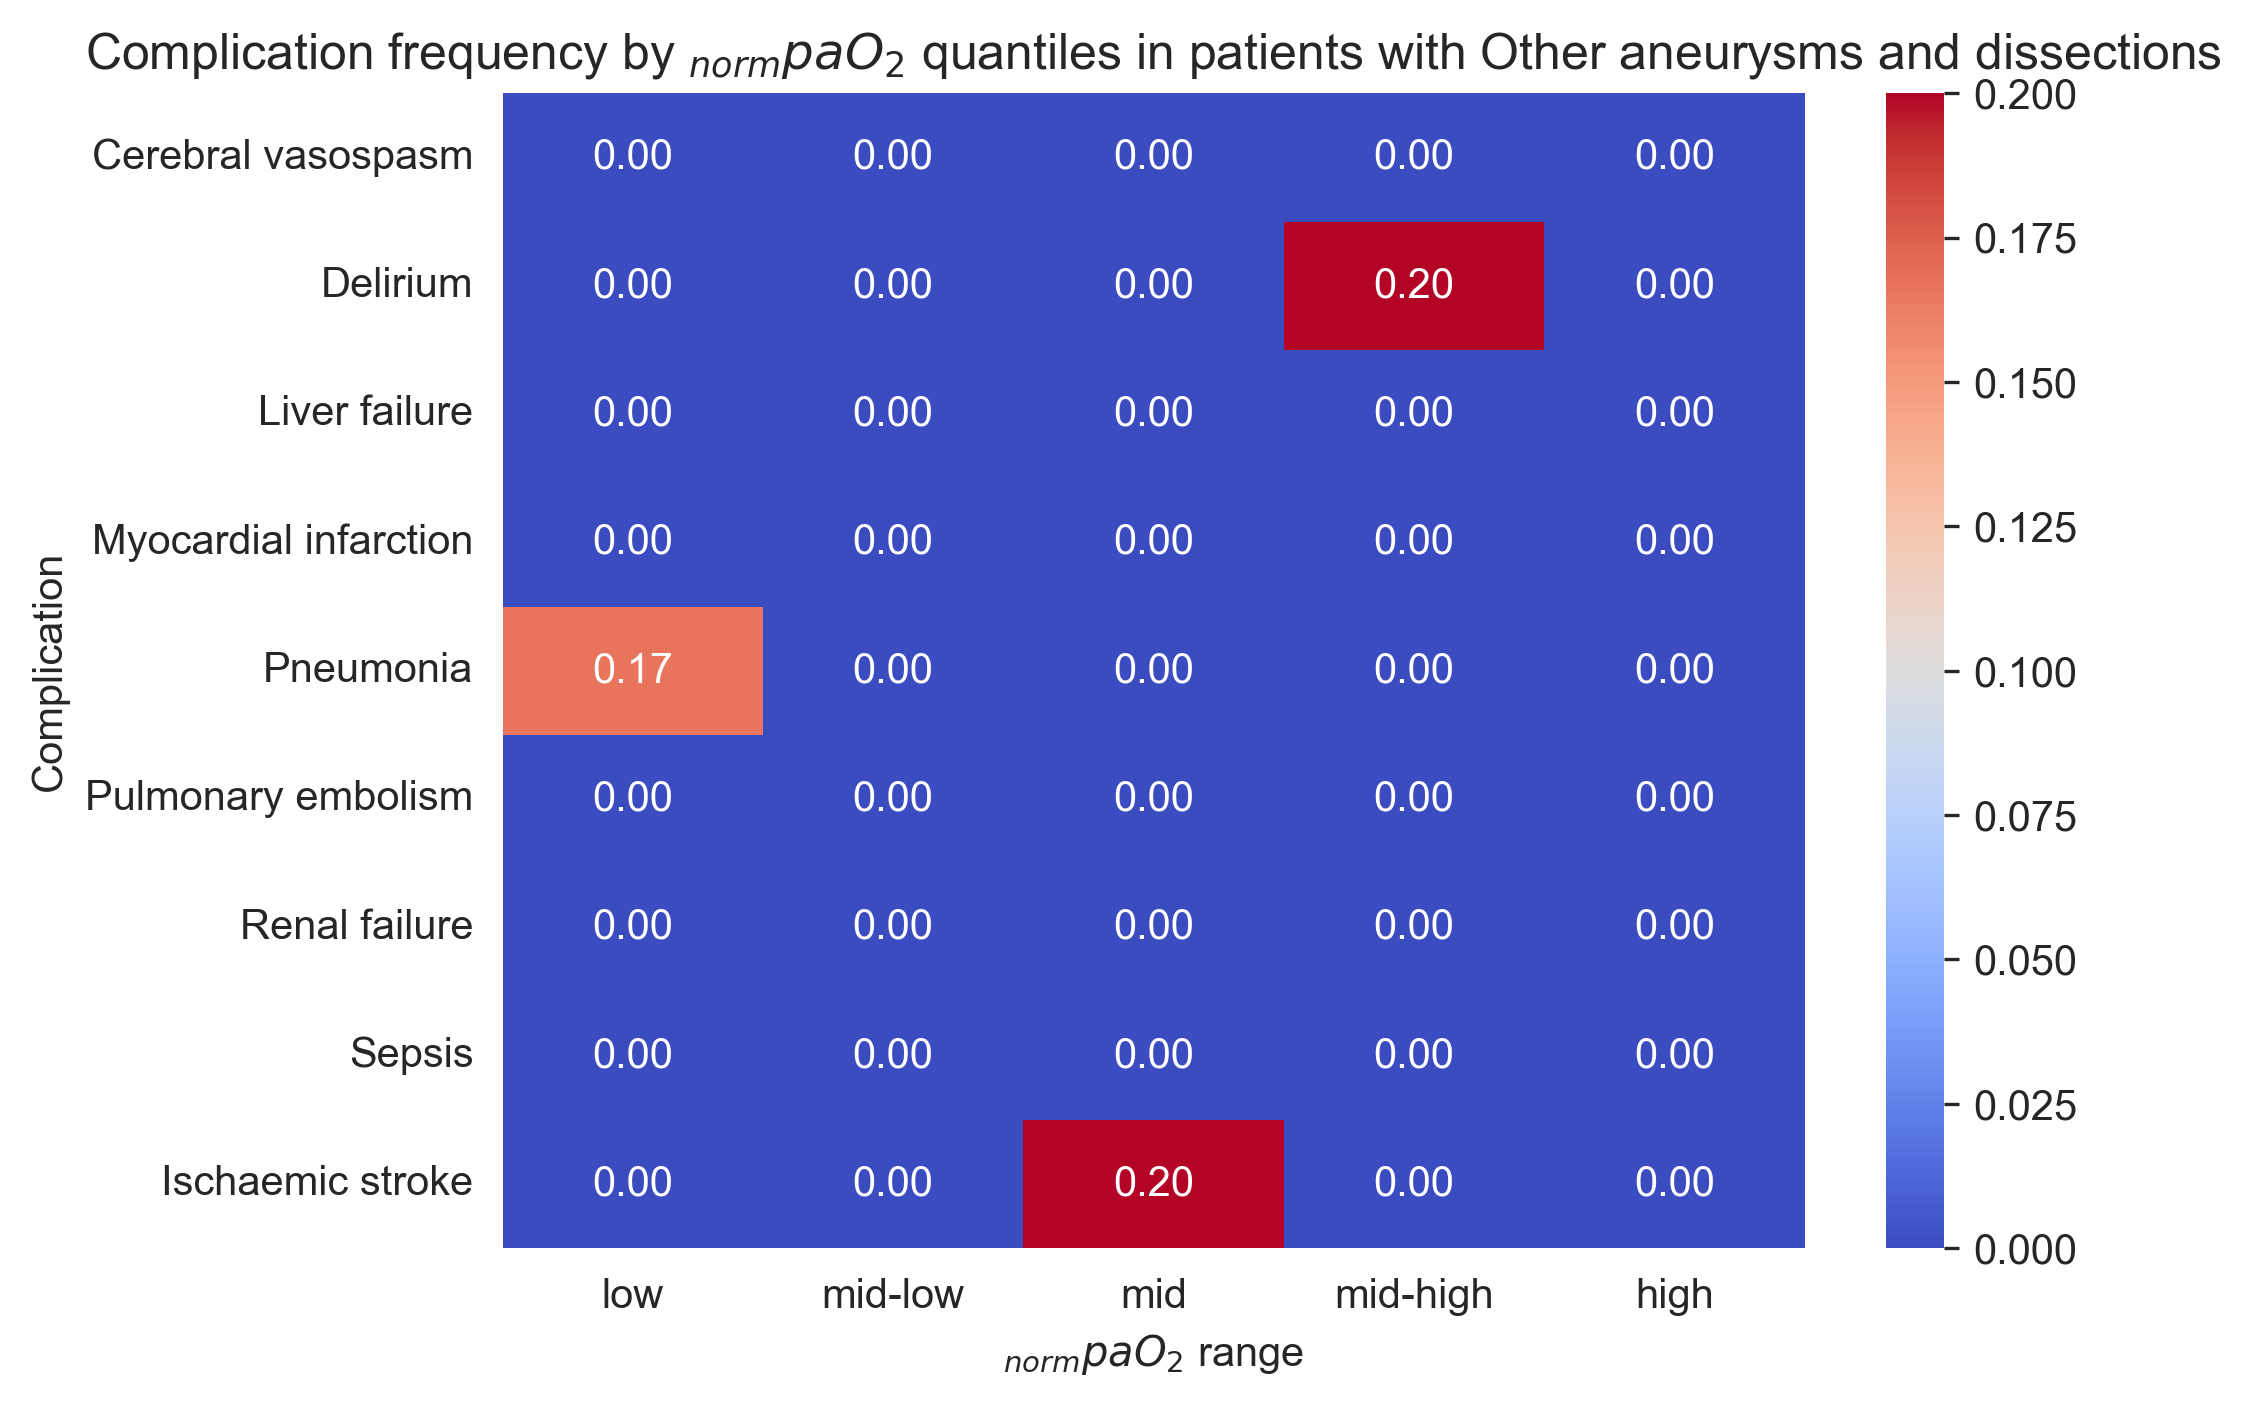


OTHER_ANEURYSM_DISSECTION -- CEREBRAL_VASOSPASM
Prevalence: 0.0 %
No significance found.

OTHER_ANEURYSM_DISSECTION -- DELIRIUM
Prevalence: 3.7 %
No significance found.

1, 2: Effect size: Hedges' g: 0.64 (moderate)

OTHER_ANEURYSM_DISSECTION -- LIVER_FAILURE
Prevalence: 0.0 %
No significance found.

OTHER_ANEURYSM_DISSECTION -- MYOCARDIAL_INFARCTION
Prevalence: 0.0 %
No significance found.

OTHER_ANEURYSM_DISSECTION -- PNEUMONIA
Prevalence: 3.7 %
No significance found.

1, 2: Effect size: Hedges' g: 1.33 (very large)

OTHER_ANEURYSM_DISSECTION -- PULMONARY_EMBOLISM
Prevalence: 0.0 %
No significance found.

OTHER_ANEURYSM_DISSECTION -- RENAL_FAILURE
Prevalence: 0.0 %
No significance found.

OTHER_ANEURYSM_DISSECTION -- SEPSIS
Prevalence: 0.0 %
No significance found.

OTHER_ANEURYSM_DISSECTION -- STROKE
Prevalence: 3.7 %
No significance found.

1, 2: Effect size: Hedges' g: 0.07 (very small)
[106, 190, 207, 228, 258, 424]

/var/folders/ff/zlqg1pks12q23nf7rf3m7j3r0000gn/T/ipykernel_82978/1751374404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()

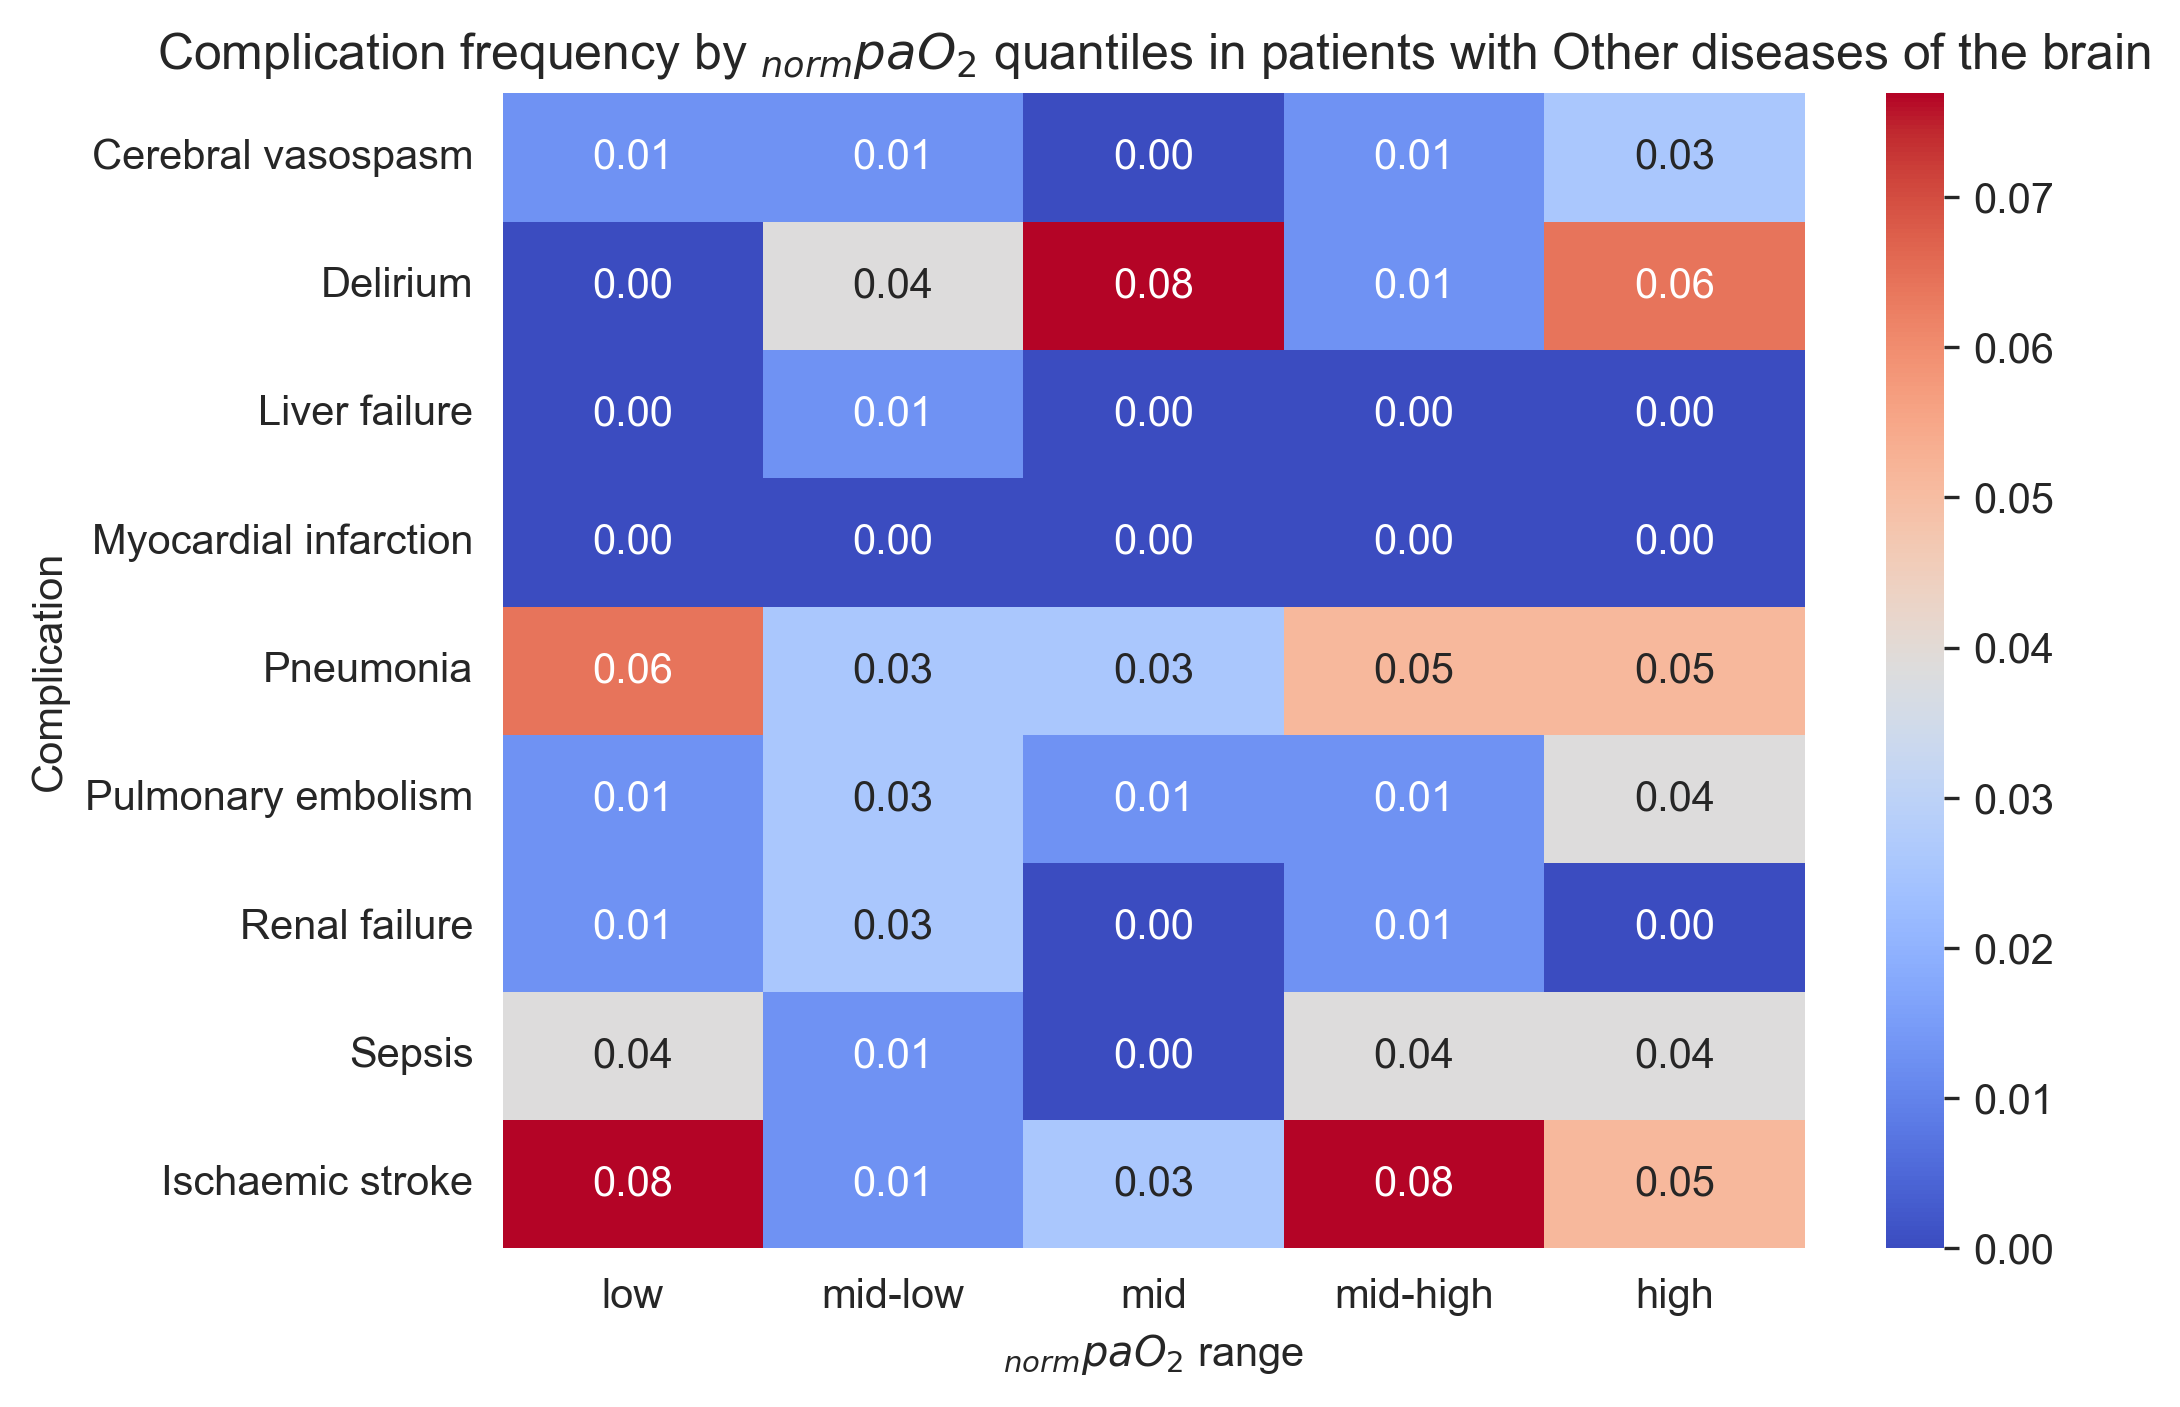


OTHER -- CEREBRAL_VASOSPASM
Prevalence: 1.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.32 (small)

OTHER -- DELIRIUM
Prevalence: 3.8 %
No significance found.

1, 2: Effect size: Hedges' g: 0.47 (small)

OTHER -- LIVER_FAILURE
Prevalence: 0.3 %
No significance found.

1, 2: Effect size: Hedges' g: 0.55 (moderate)

OTHER -- MYOCARDIAL_INFARCTION
Prevalence: 0.0 %
No significance found.

OTHER -- PNEUMONIA
Prevalence: 4.4 %
No significance found.

1, 2: Effect size: Hedges' g: 0.01 (very small)

OTHER -- PULMONARY_EMBOLISM
Prevalence: 2.1 %
No significance found.

1, 2: Effect size: Hedges' g: 0.42 (small)

OTHER -- RENAL_FAILURE
Prevalence: 1.0 %
No significance found.

1, 2: Effect size: Hedges' g: 0.61 (moderate)

OTHER -- SEPSIS
Prevalence: 2.6 %
No significance found.

1, 2: Effect size: Hedges' g: 0.16 (very small)

OTHER -- STROKE
Prevalence: 4.9 %
No significance found.

1, 2: Effect size: Hedges' g: 0.08 (very small)

In [25]:
for d in diagnoses:
    tmp_df = analysis_df[analysis_df[d]==True].copy()
    tmp_df['paO2_bin'], edges = pd.qcut(tmp_df['norm_auc_paO2'], q=5, labels=['low', 'mid-low', 'mid', 'mid-high', 'high'], retbins = True)
    print([round(x) for x in edges])
    comp_rate = tmp_df.groupby('paO2_bin')[list(complications)].mean()
    ax = sns.heatmap(comp_rate.T, cmap="coolwarm", annot=True, fmt=".2f")
    ax.set_yticklabels([config.get('long_names')[i] for i in complications])
    plt.title("Complication frequency by $_{norm}paO_2$ quantiles in patients with "+config.get('long_names').get(d))
    plt.xlabel("$_{norm}paO_2$ range")
    plt.ylabel("Complication")
    plt.show()
    plt.close()

    for c in complications:
        print(f"\n{d.upper()} -- {c.upper()}")
        print(f"Prevalence: {round(100/analysis_df[analysis_df[d]==True].shape[0]*analysis_df[(analysis_df[d]==True)&(analysis_df[c]==True)].shape[0],1)} %")
        pvalue = compare_median("norm_auc_paO2", analysis_df.loc[analysis_df[d]==True,:], c, False)
        if pvalue<0.05:
            print(f"\nDifferences between patients with and without {c} in normalized perioperative auc values: {round(pvalue,4)}.\n__________________________________________\n\n")

### 3.4.6 Prevalence and odds ratios


=== benign_neoplasm (2009) ===

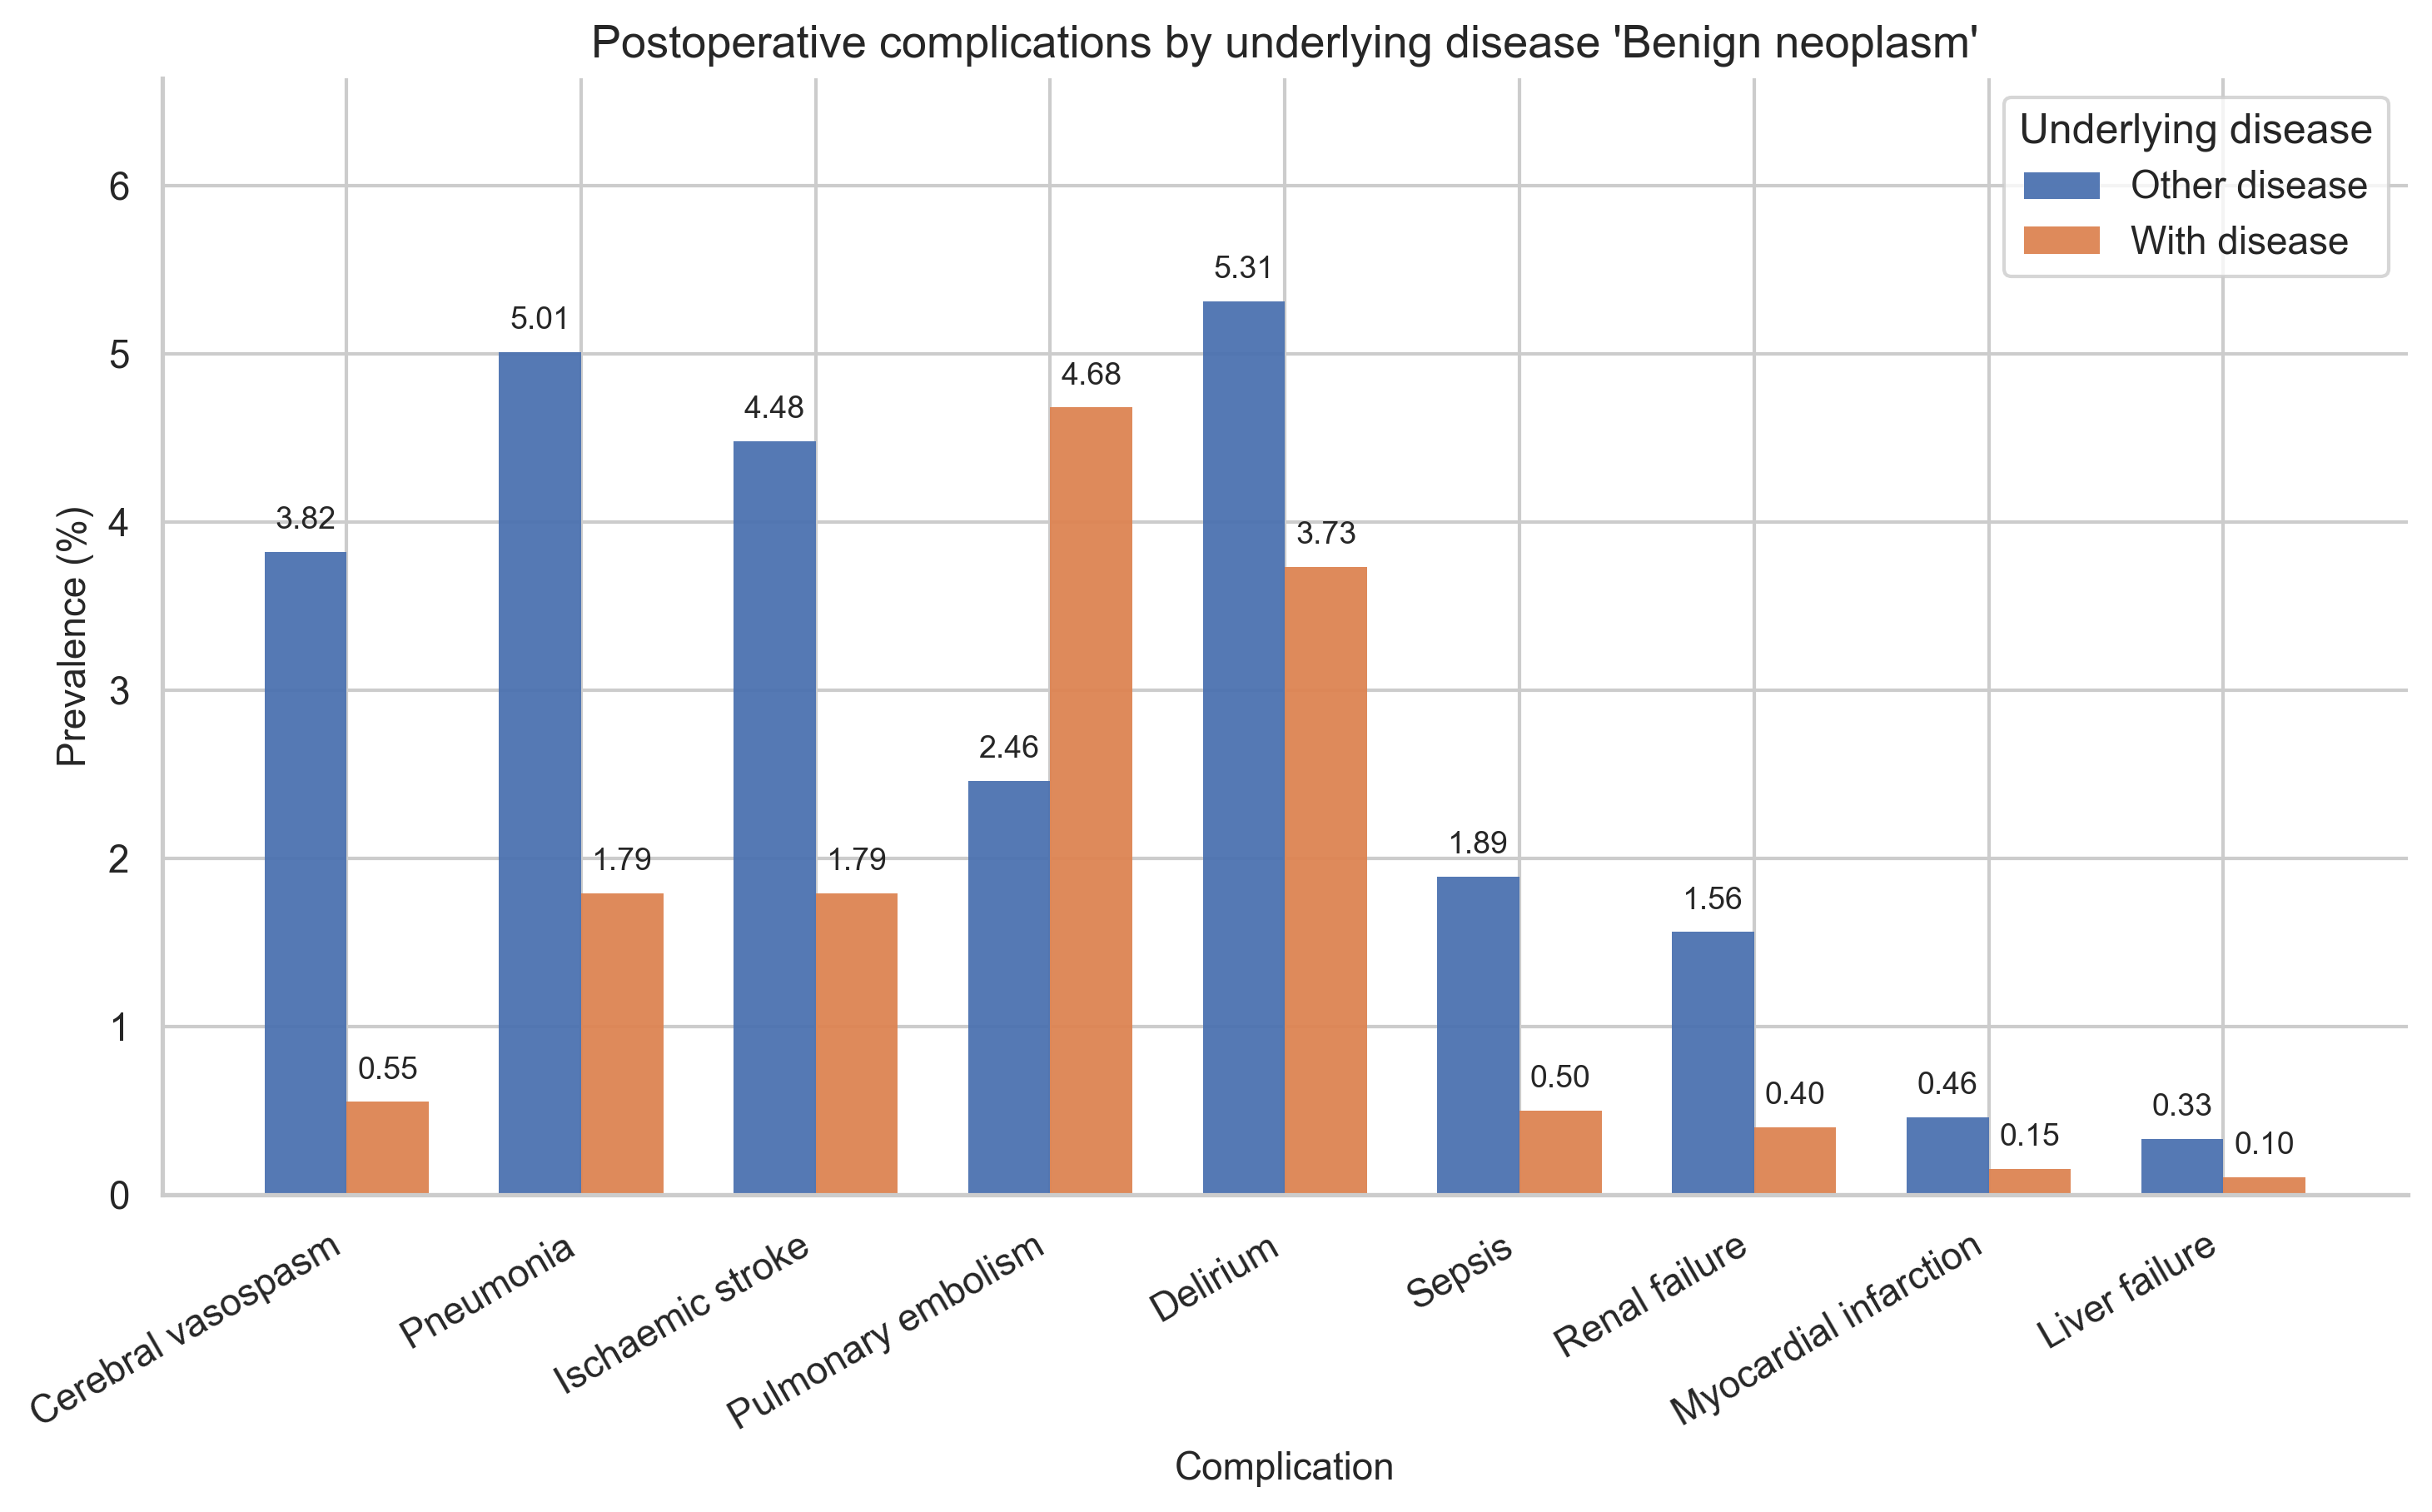


=== cerebral_aneurysm (422) ===

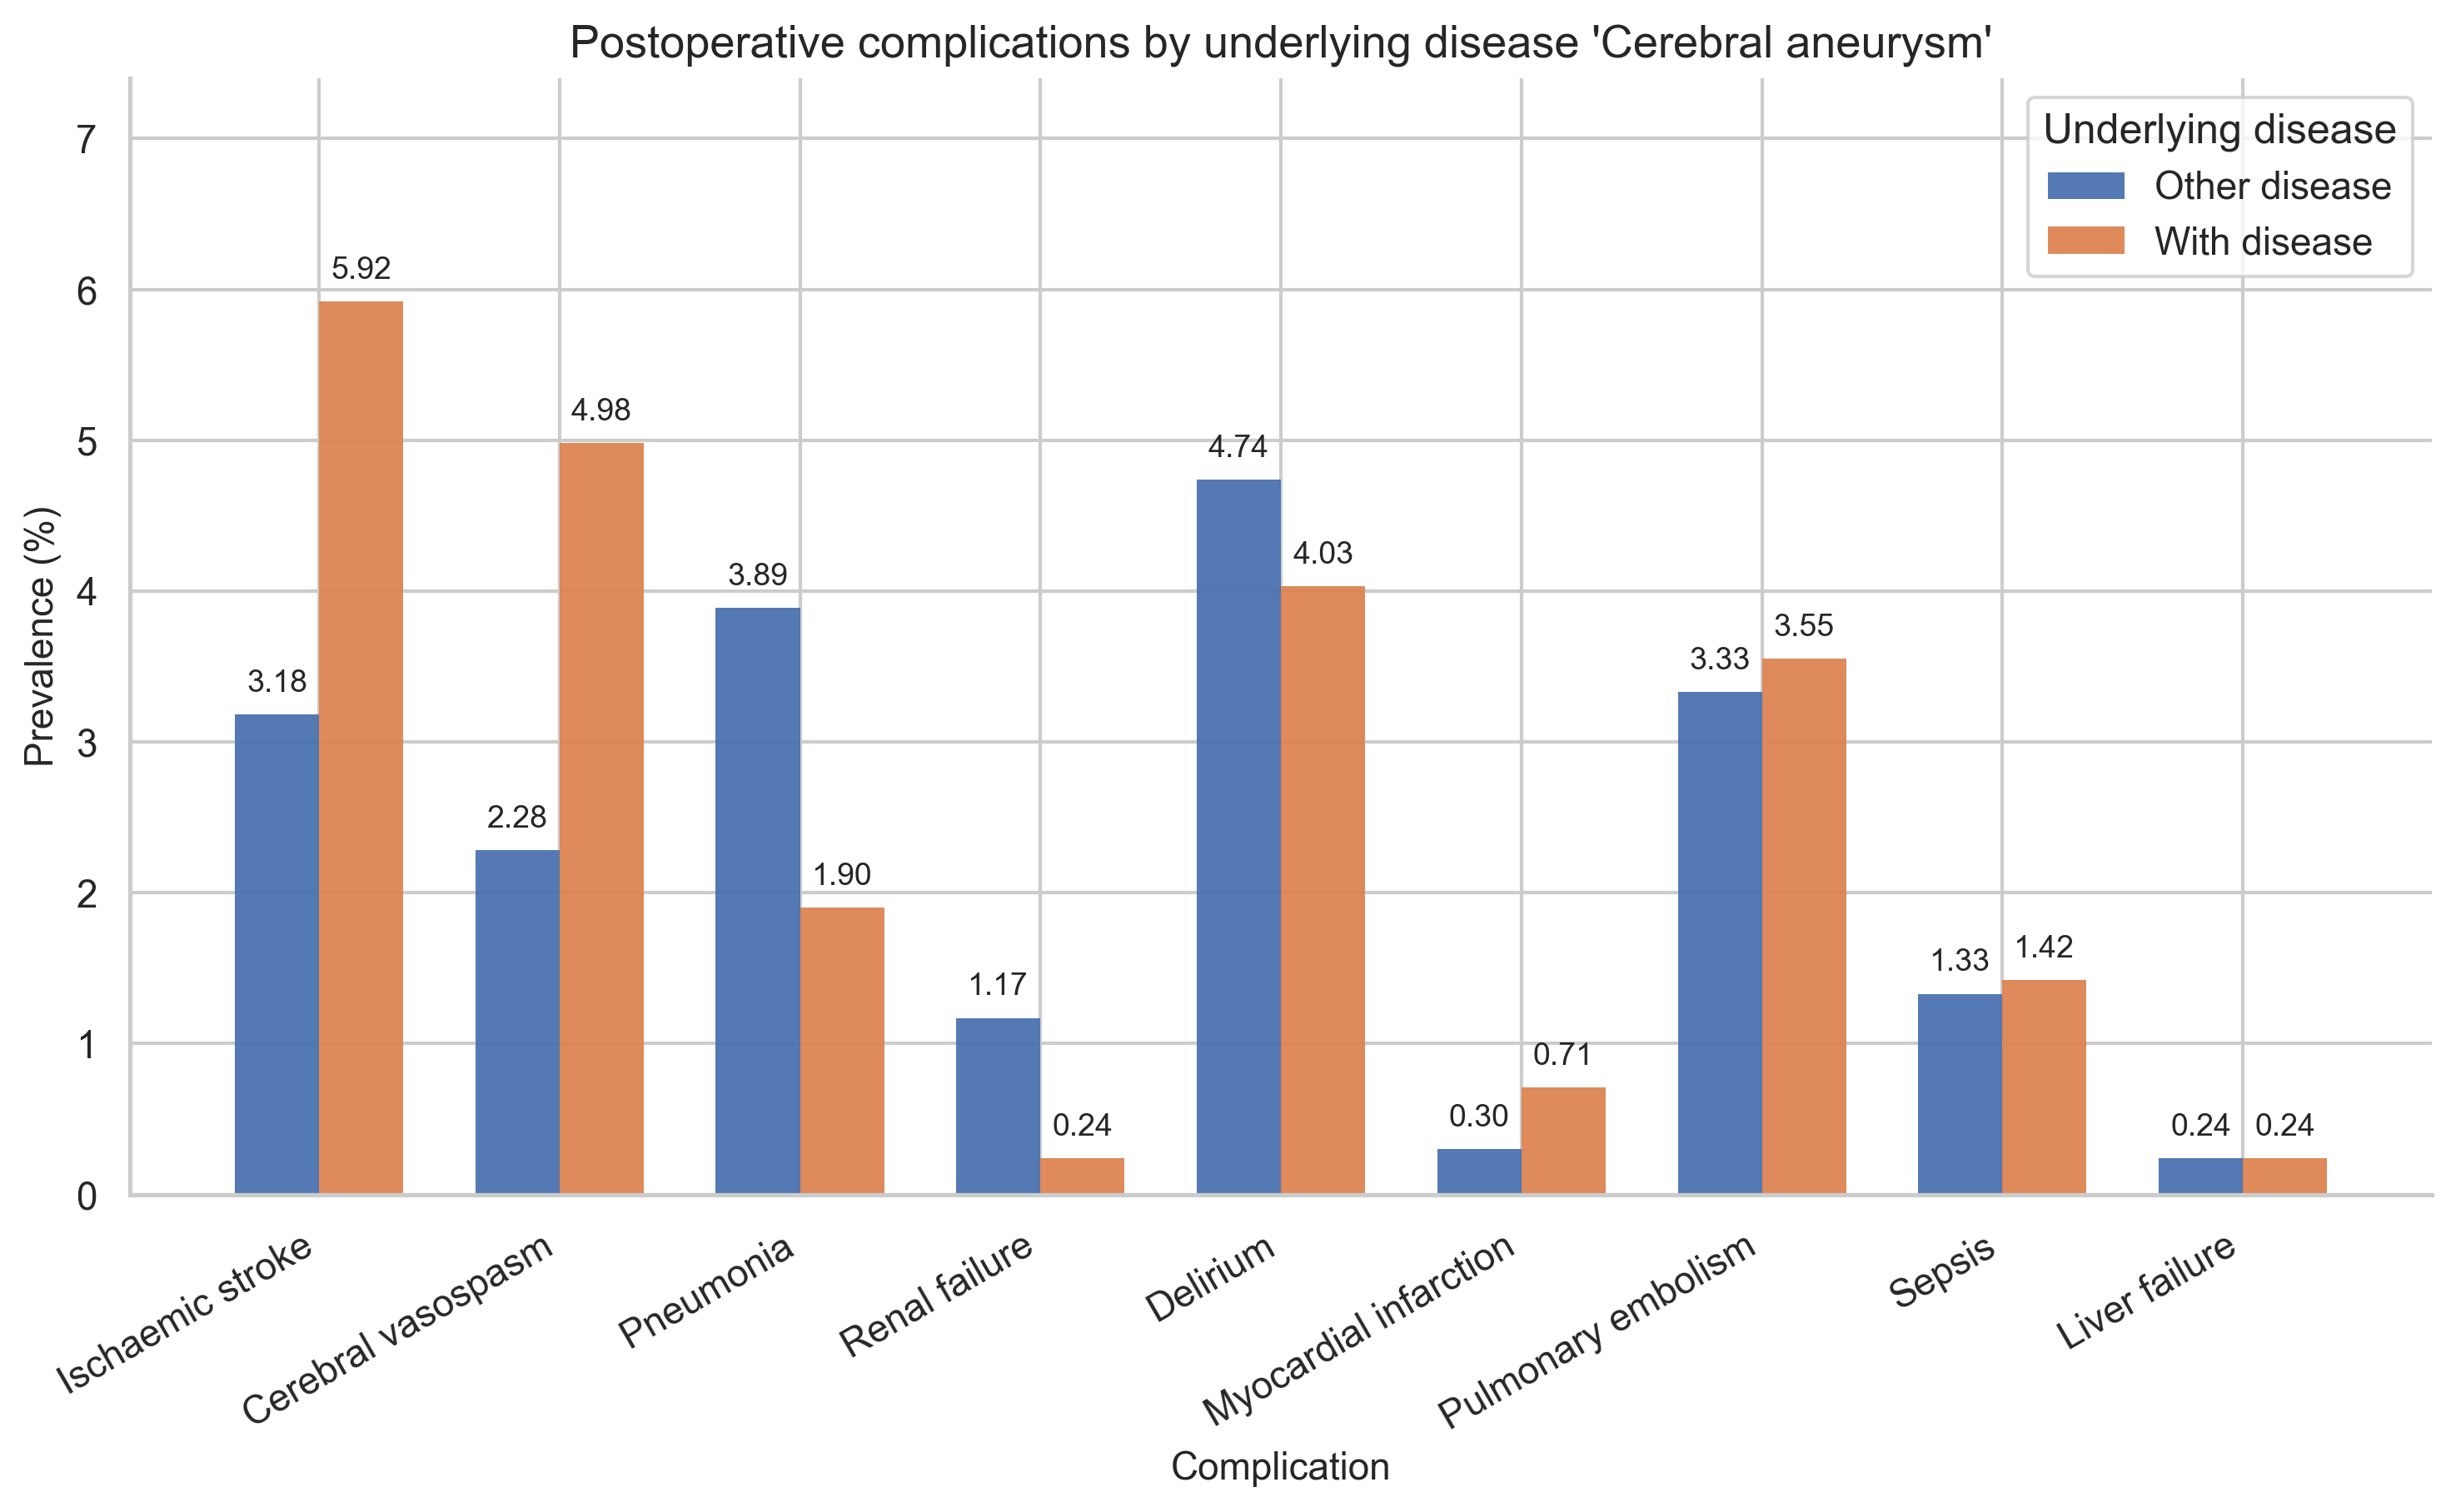


=== epilepsy (204) ===

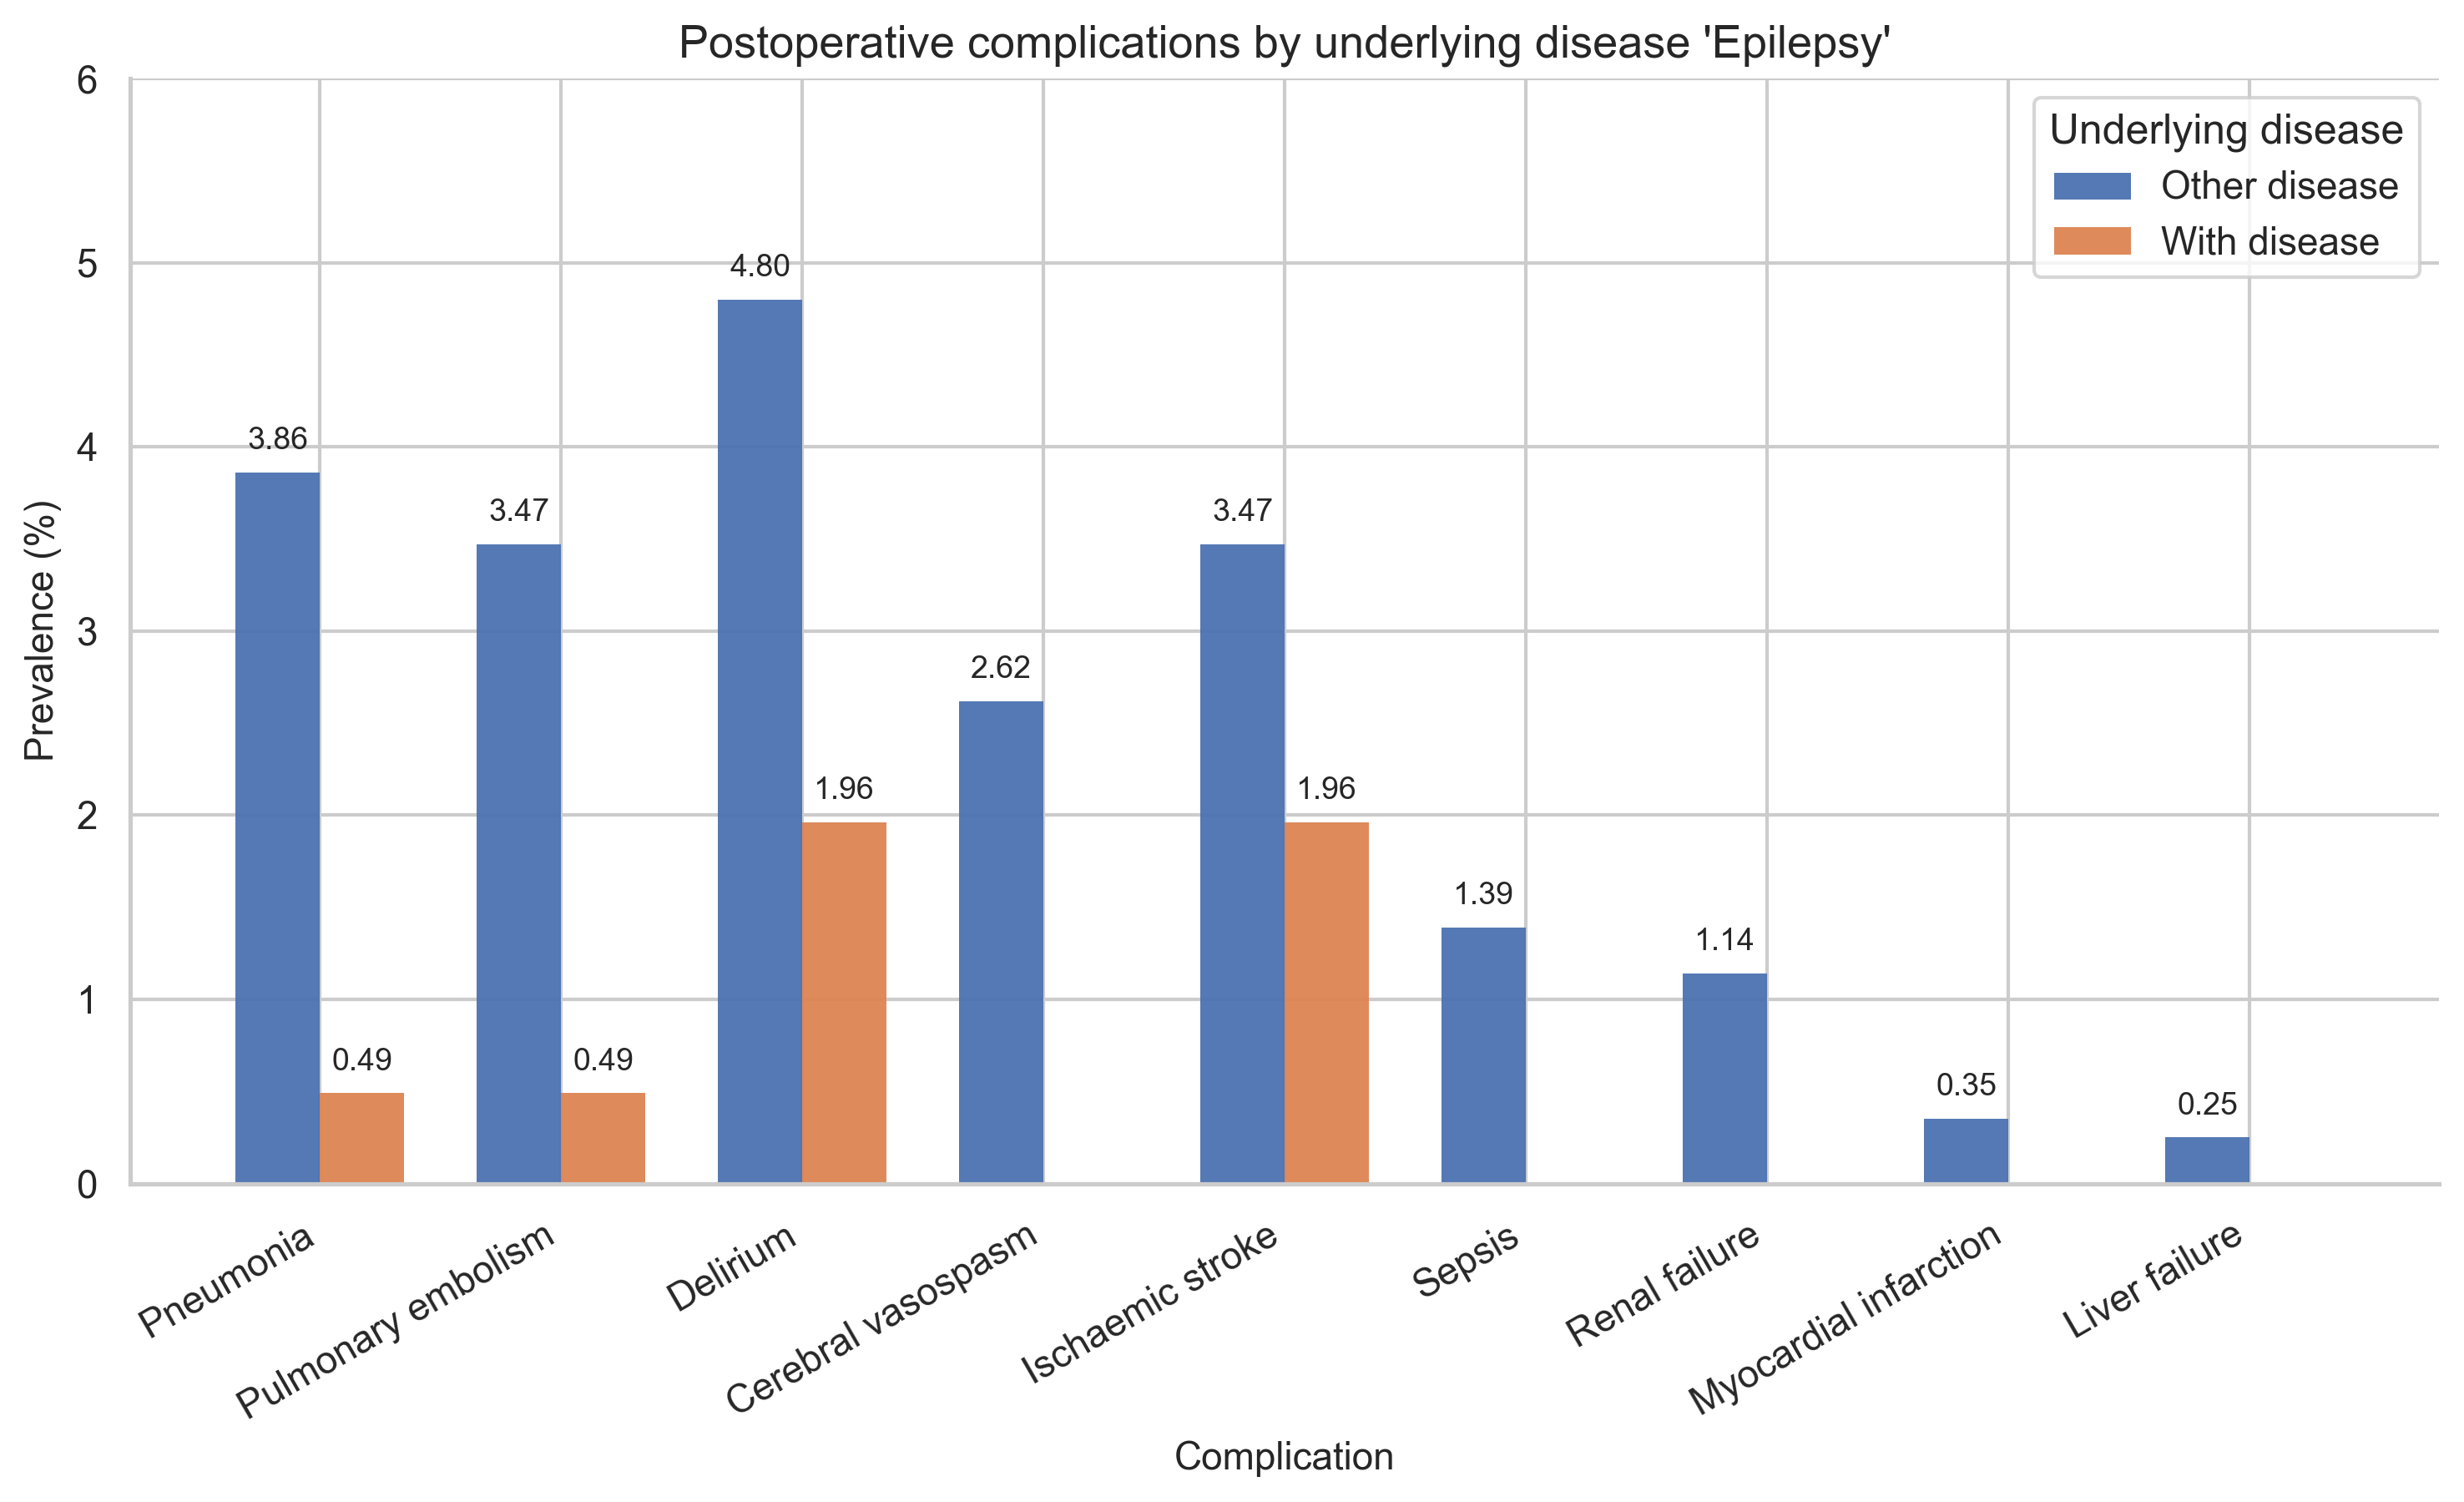


=== intracranial_hemorrhage (471) ===

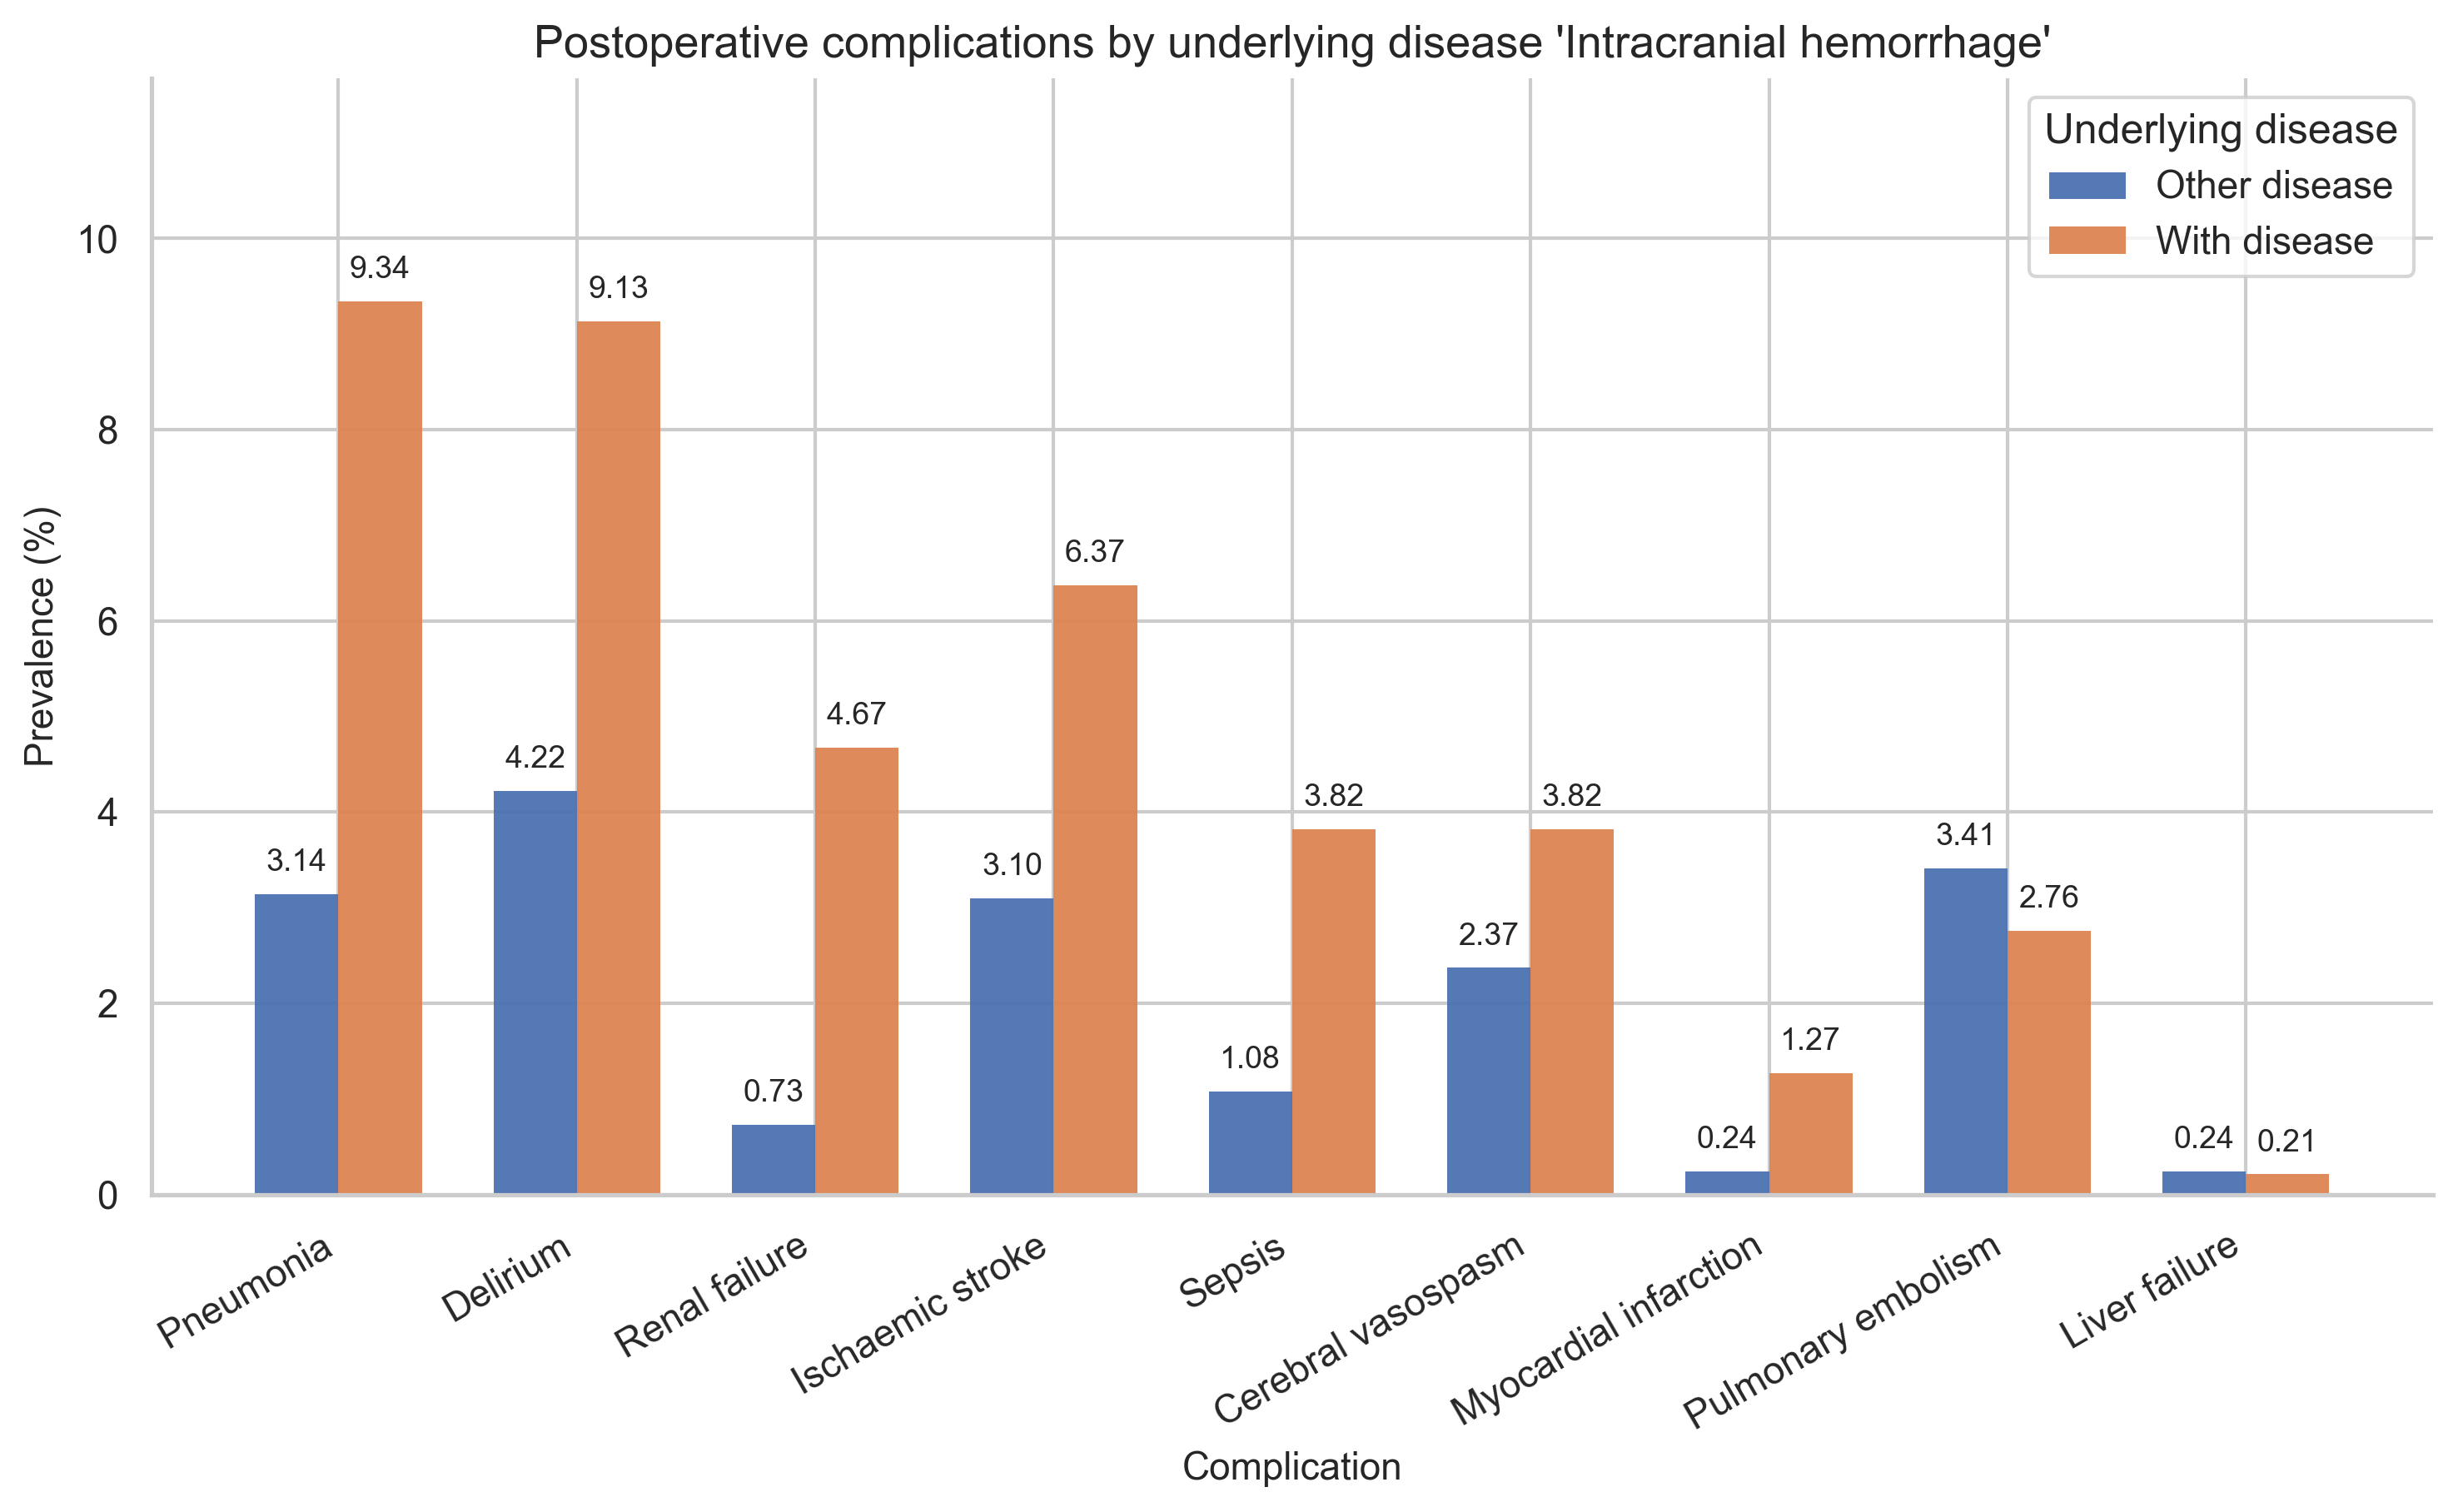


=== malignant_neoplasm (963) ===

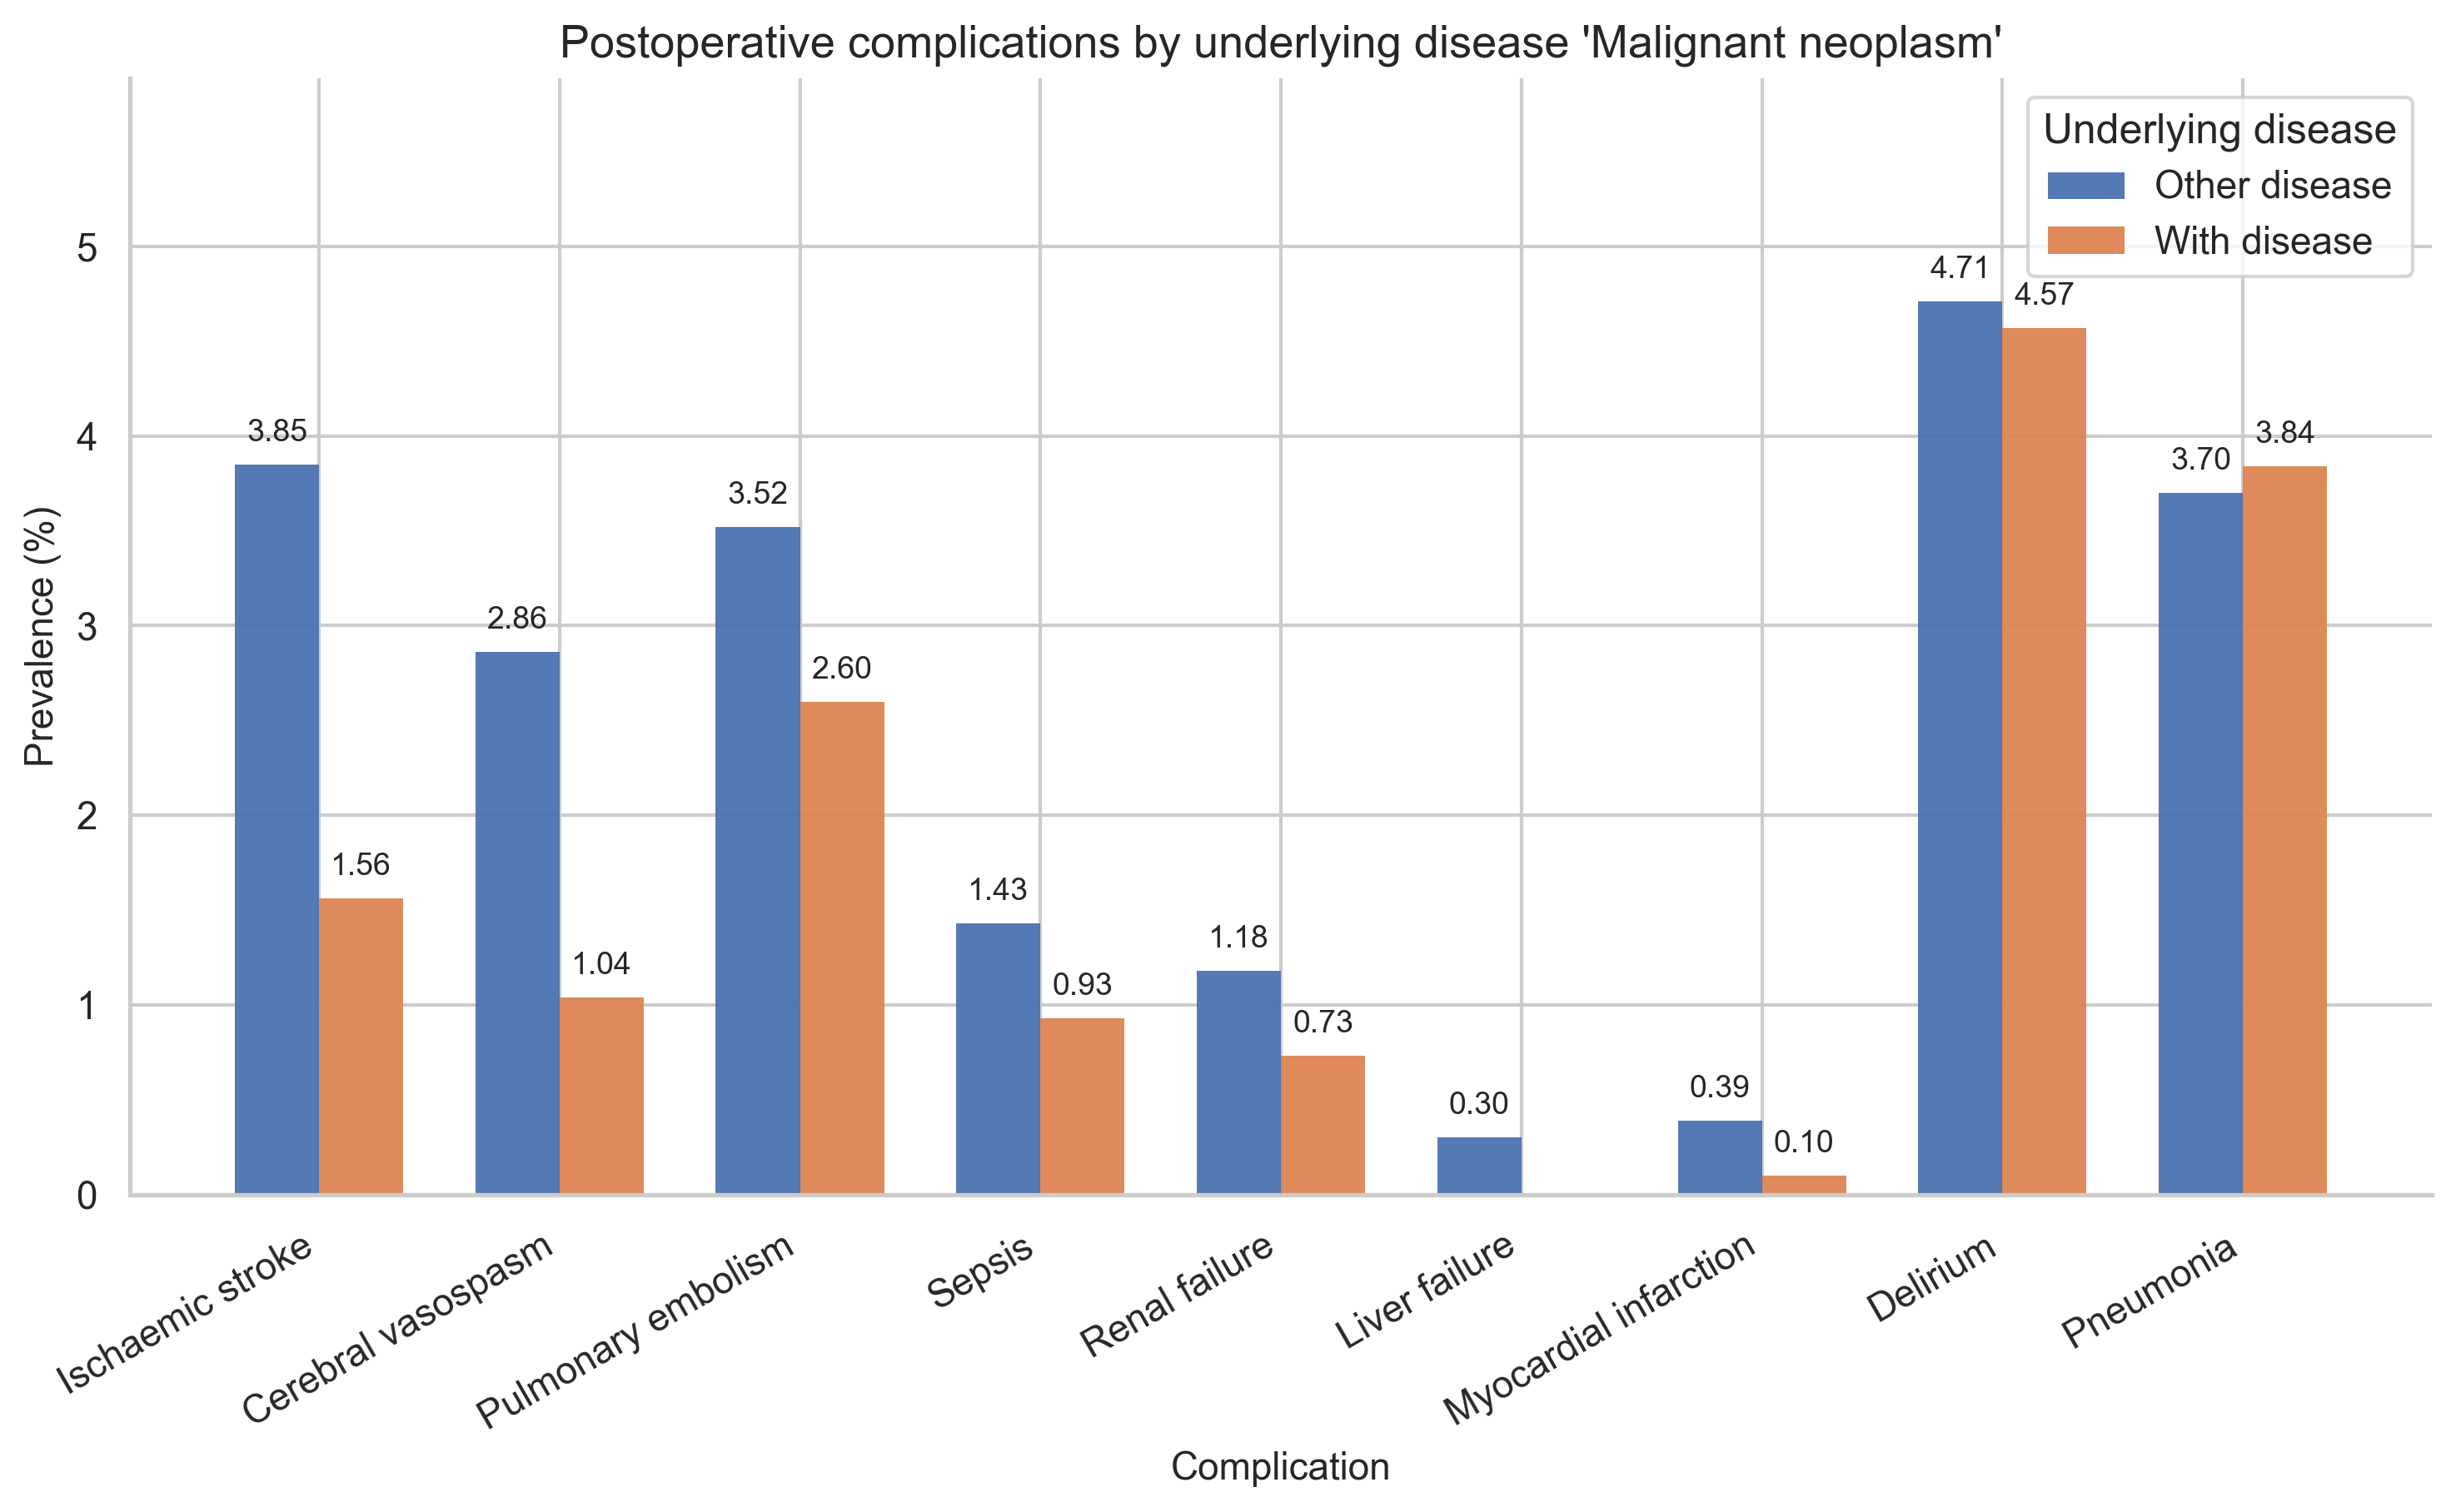


=== neoplasm (101) ===

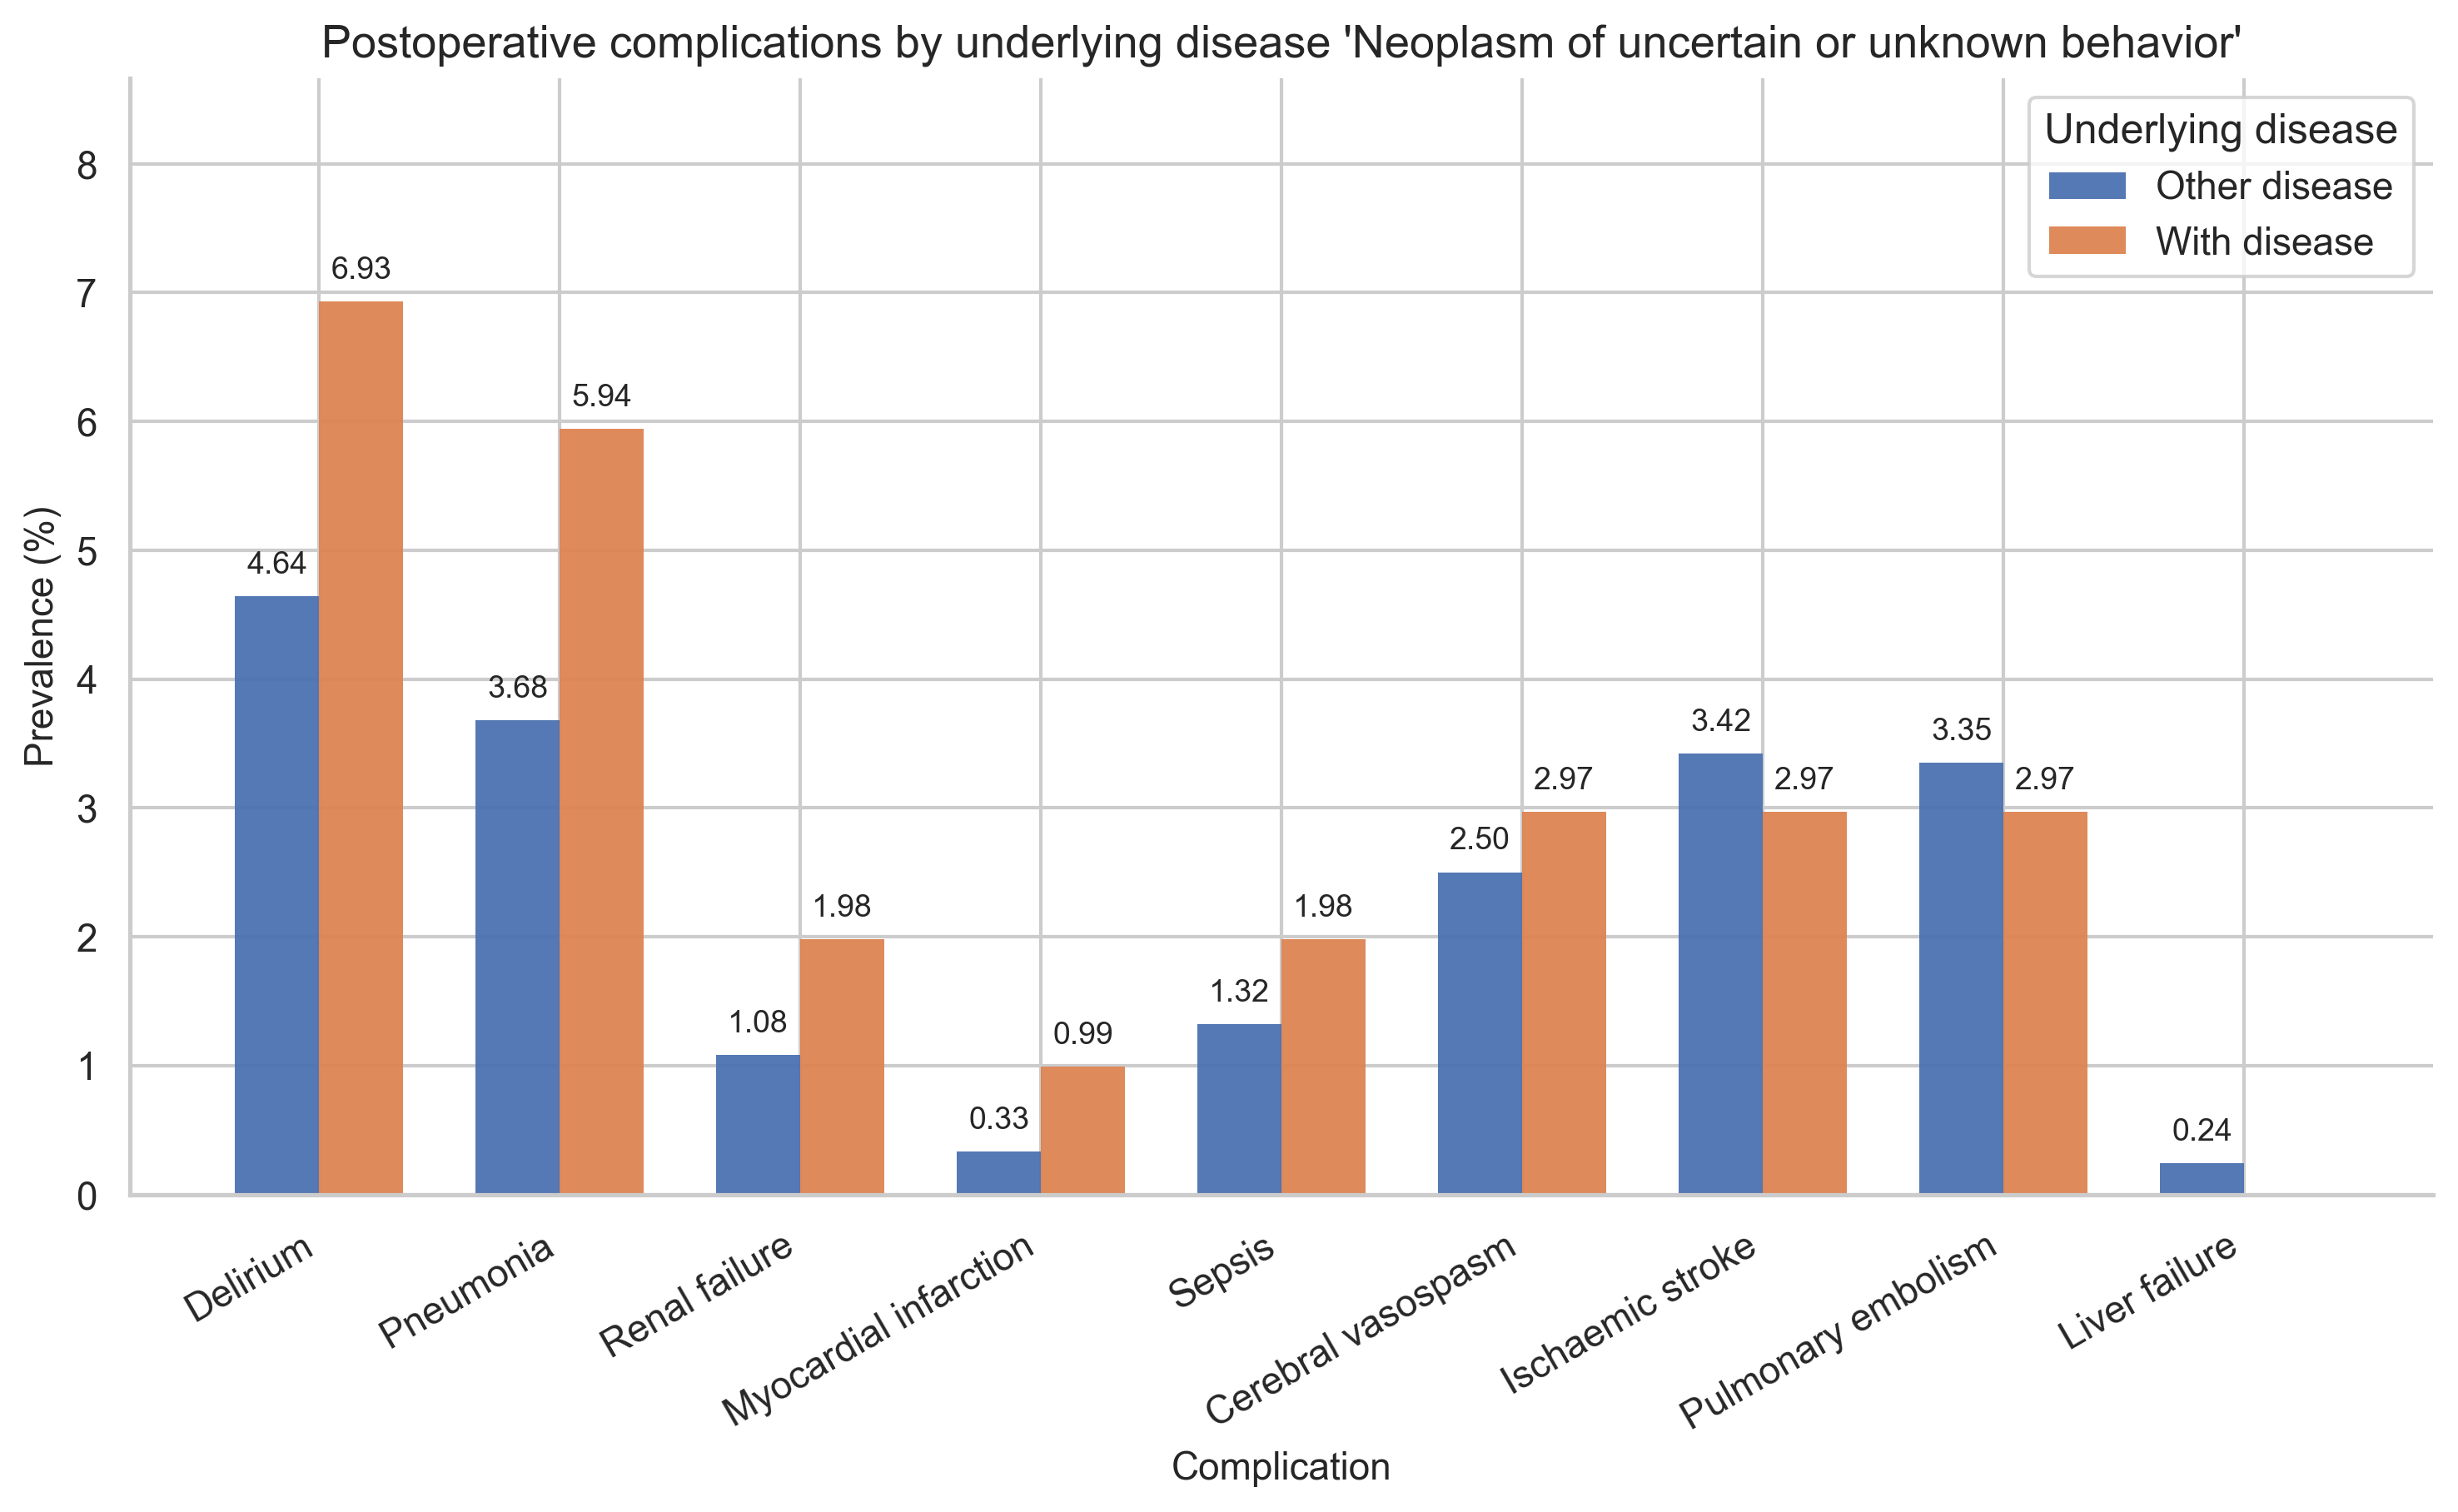


=== SAH (189) ===

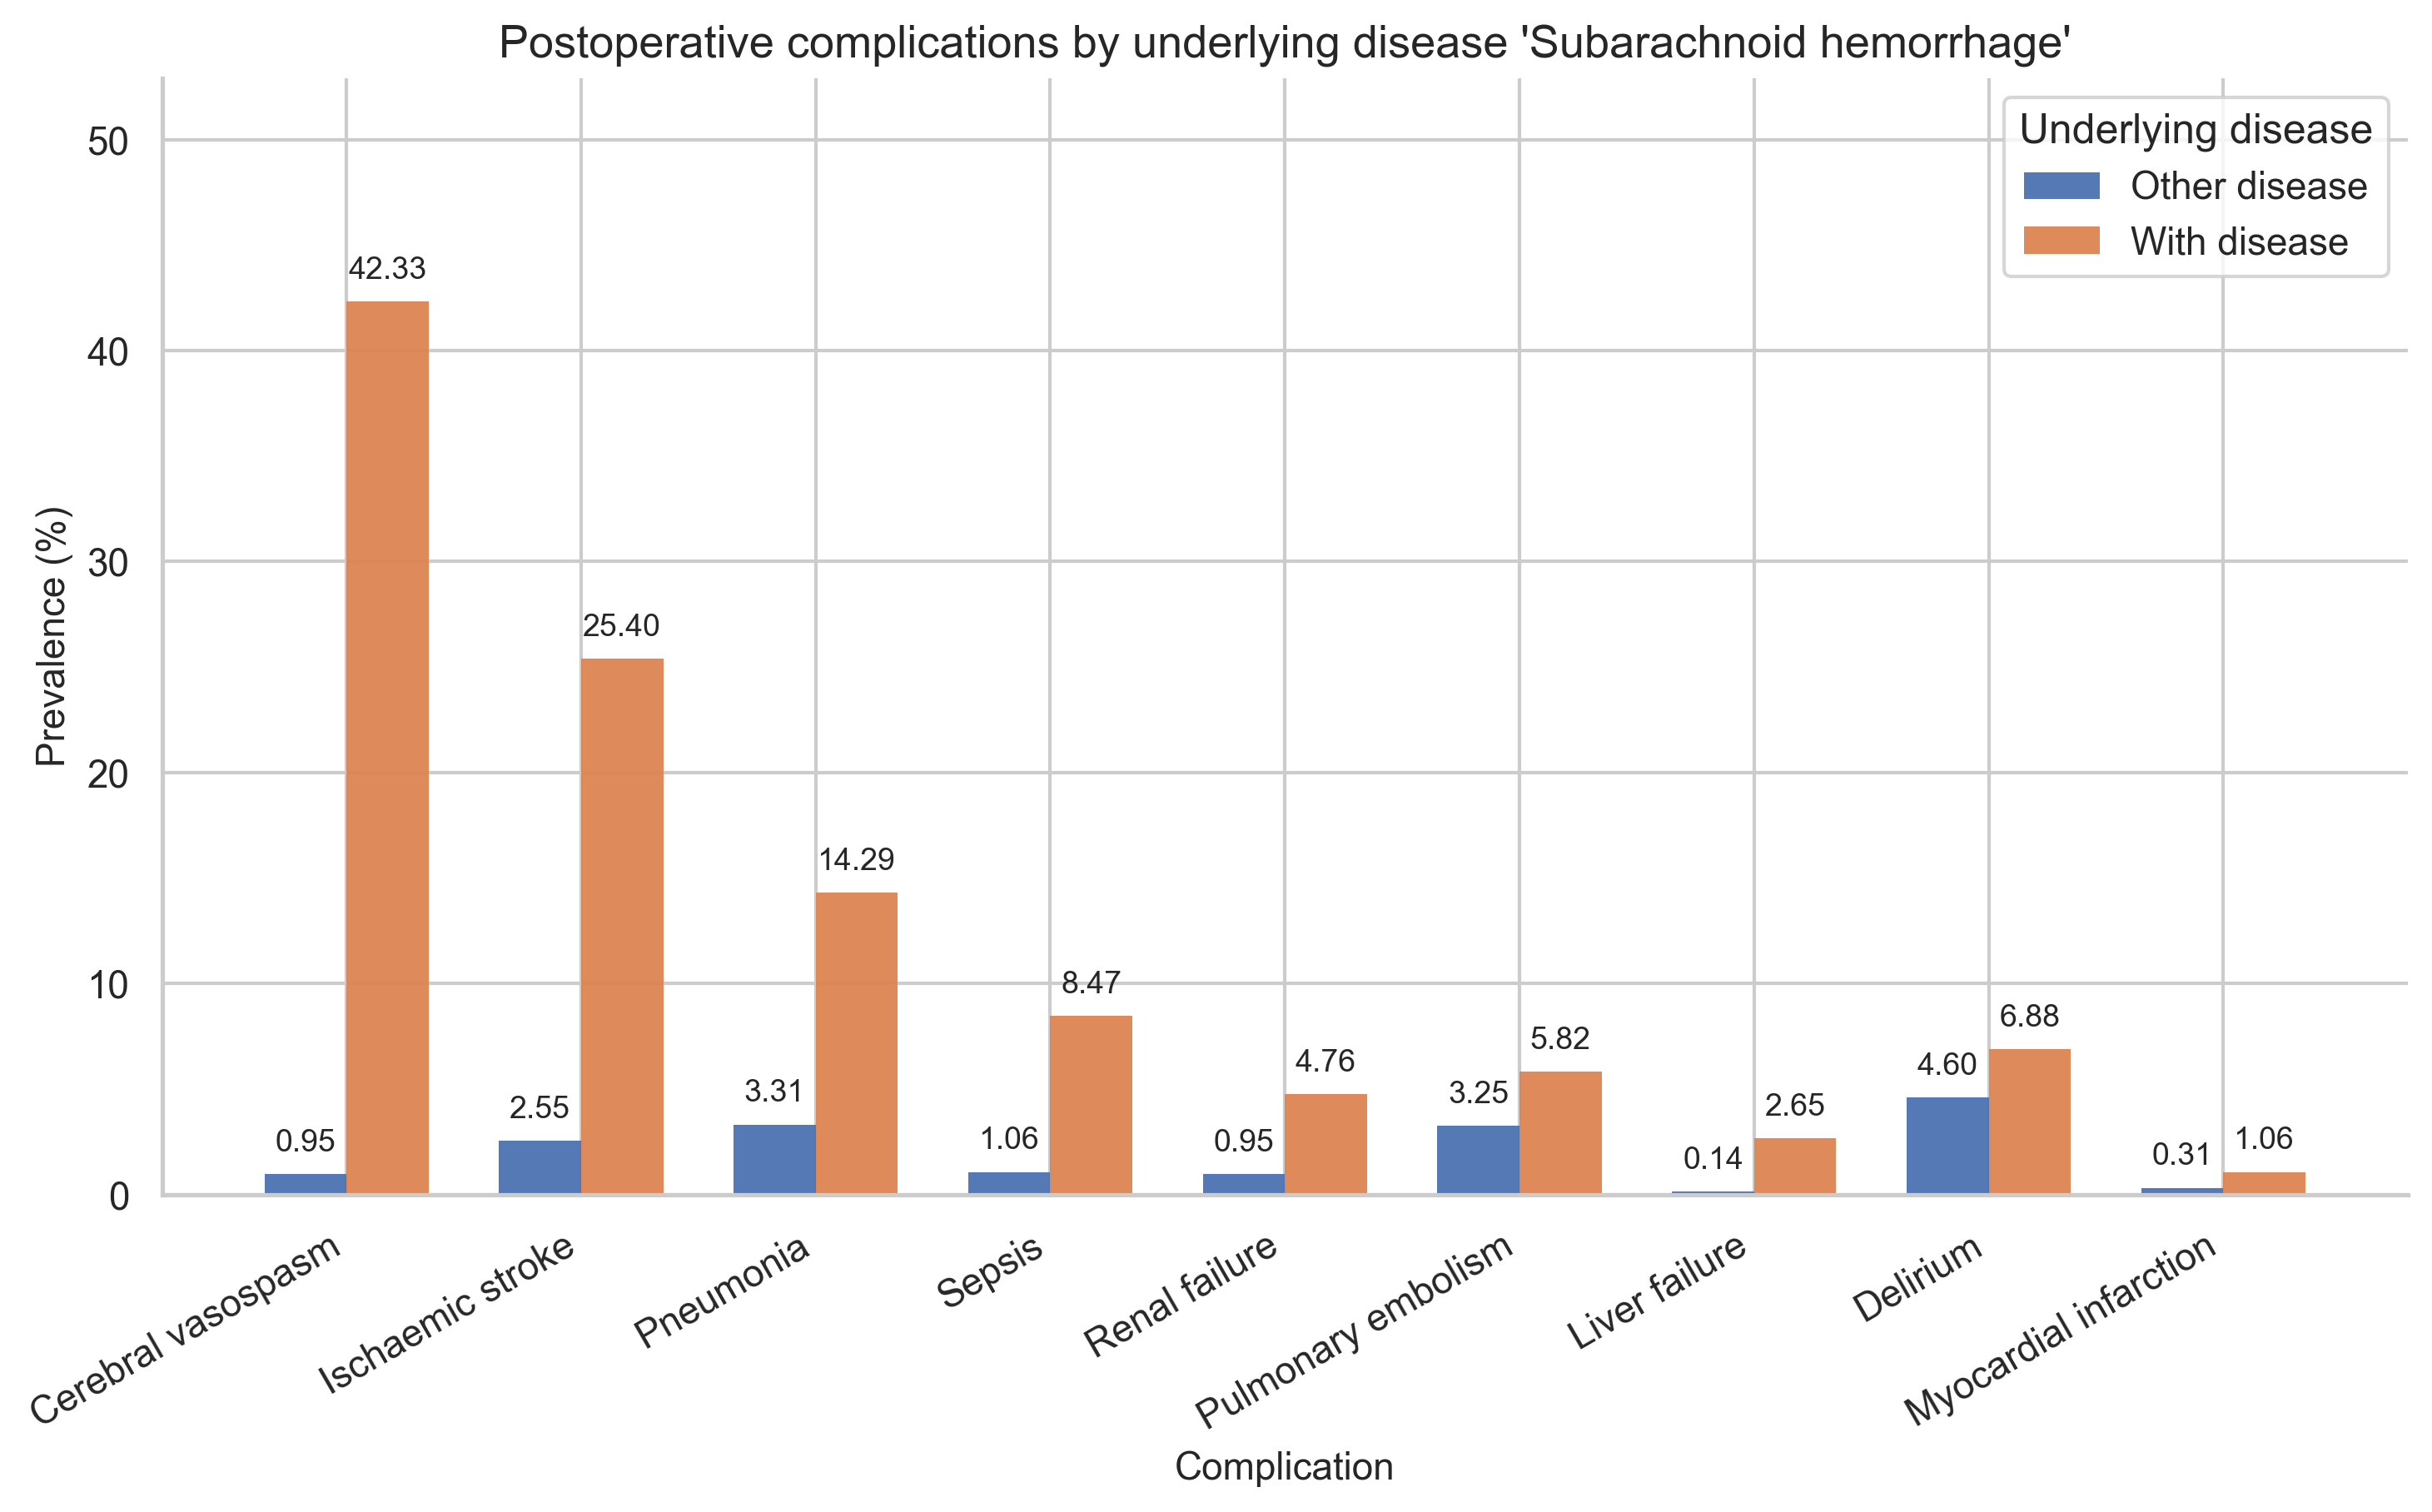


=== TBI (217) ===

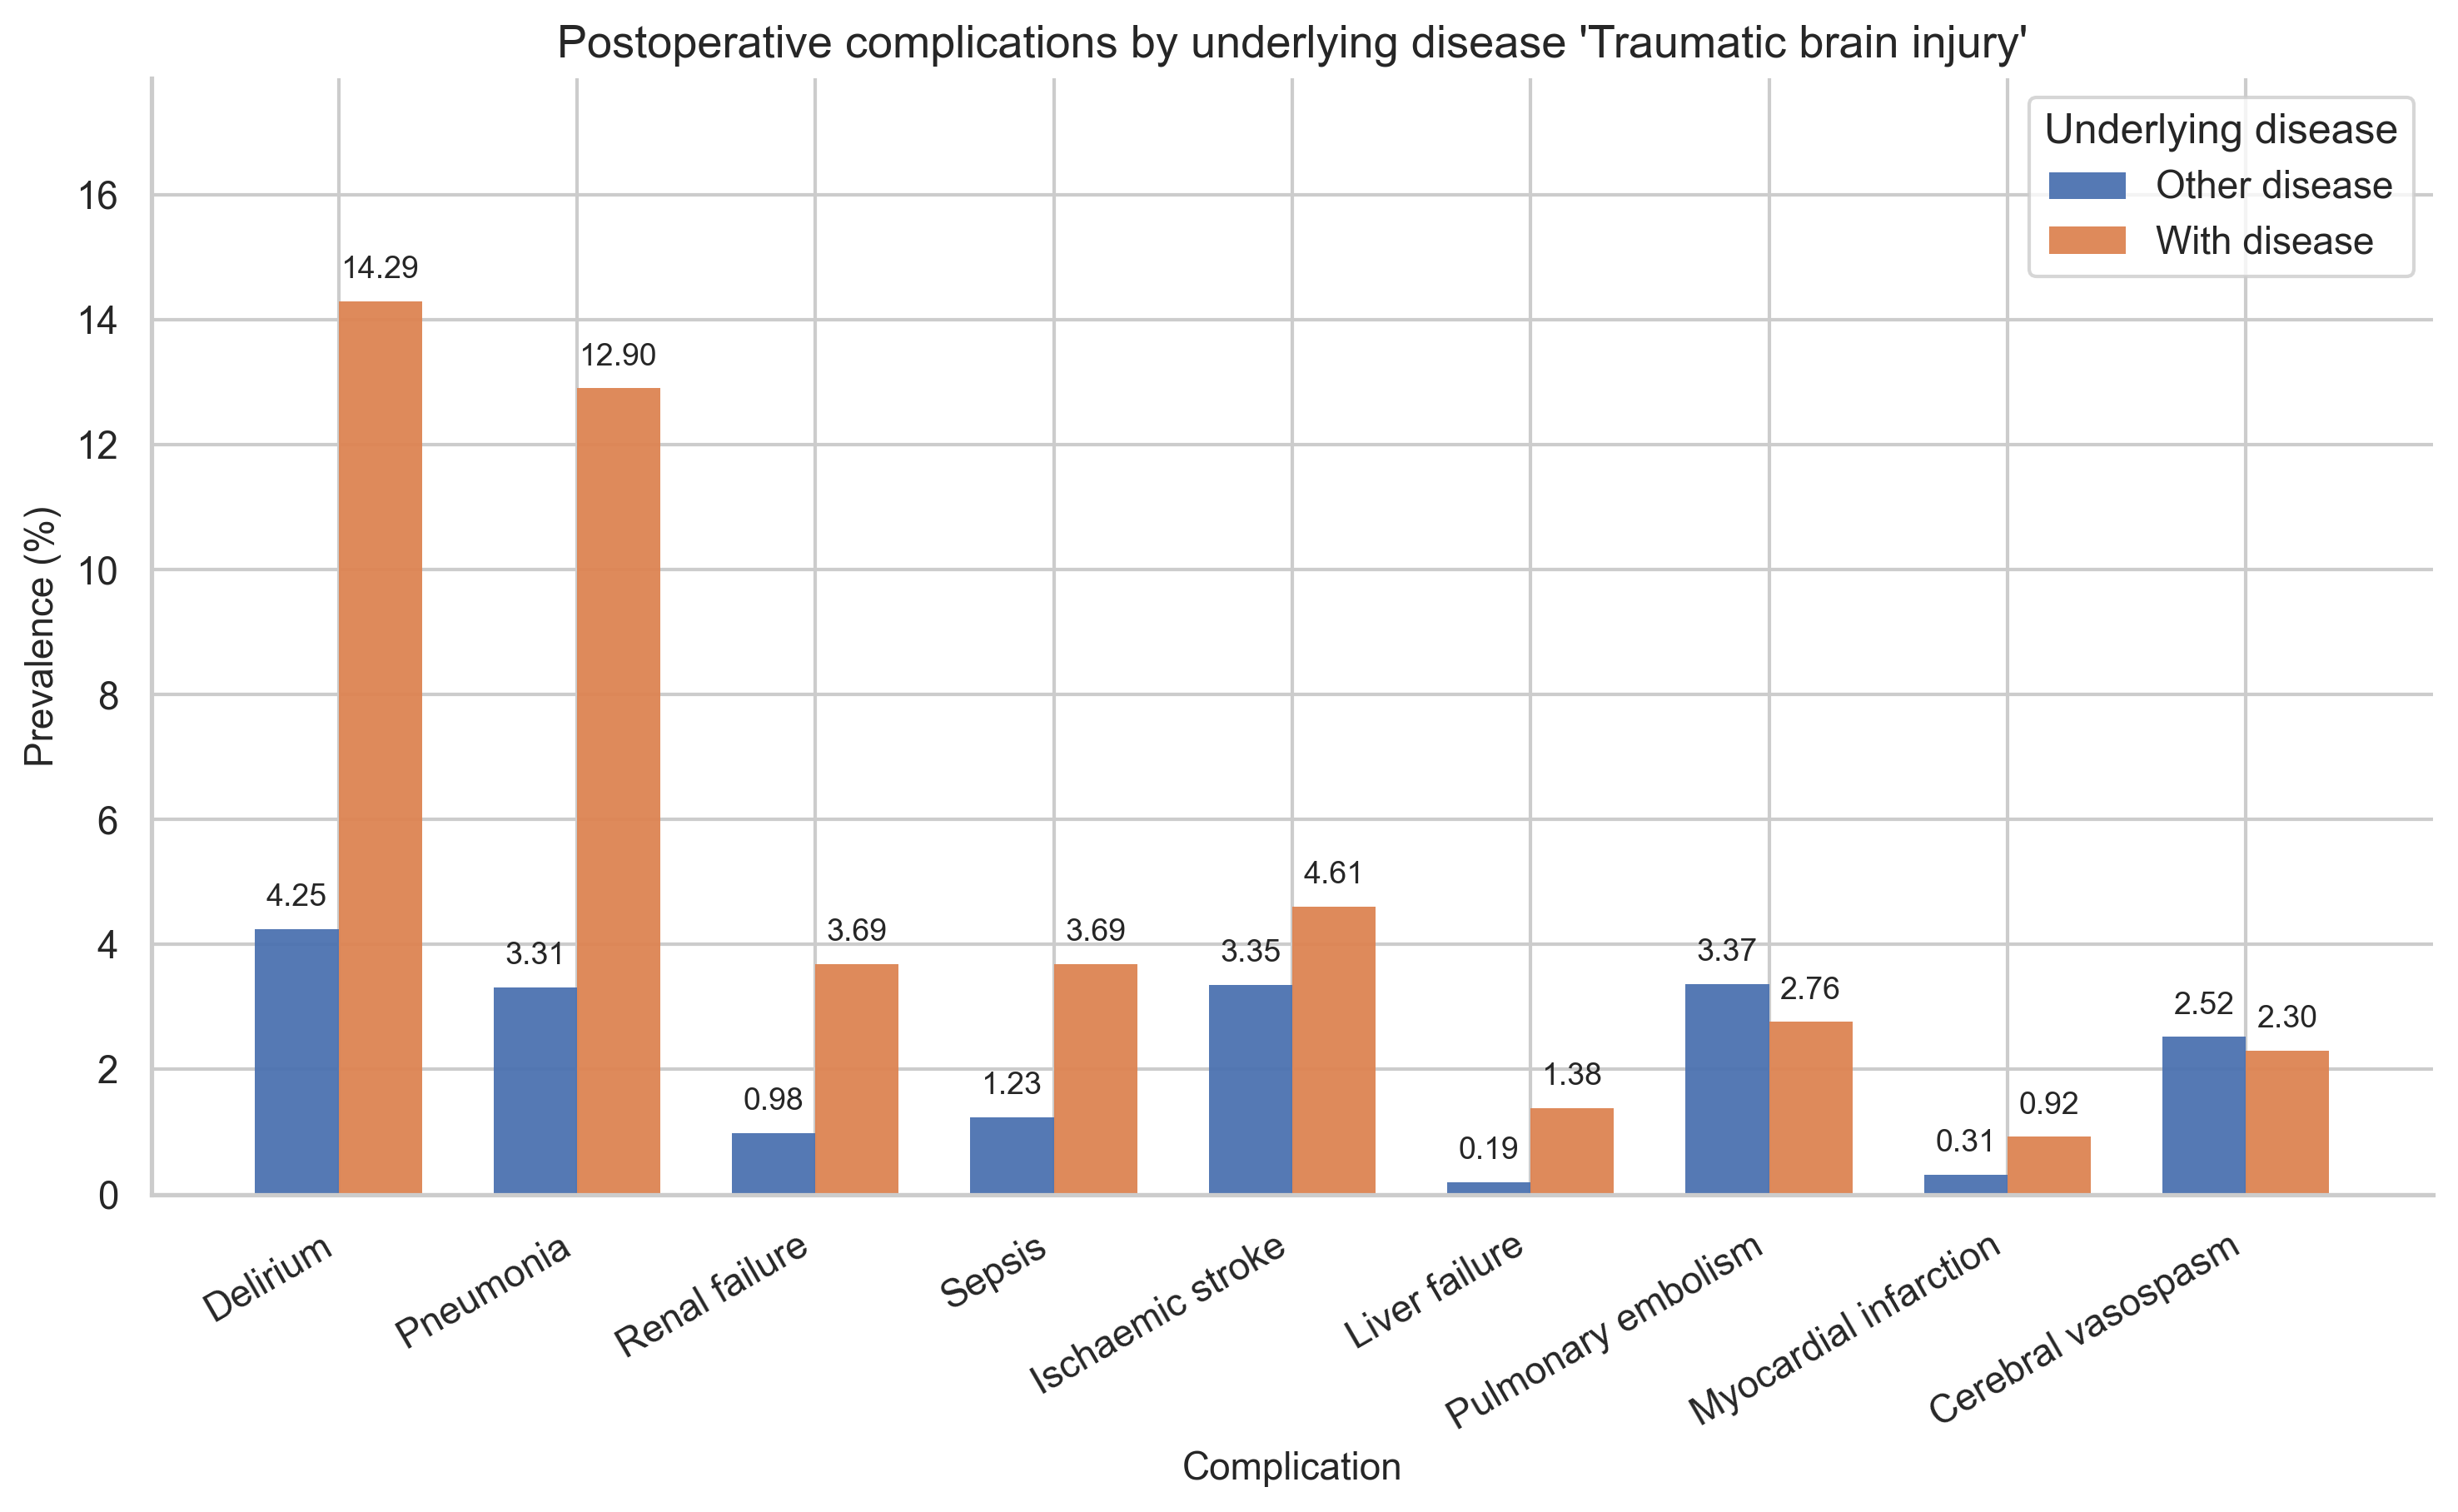


=== trigeminus (193) ===

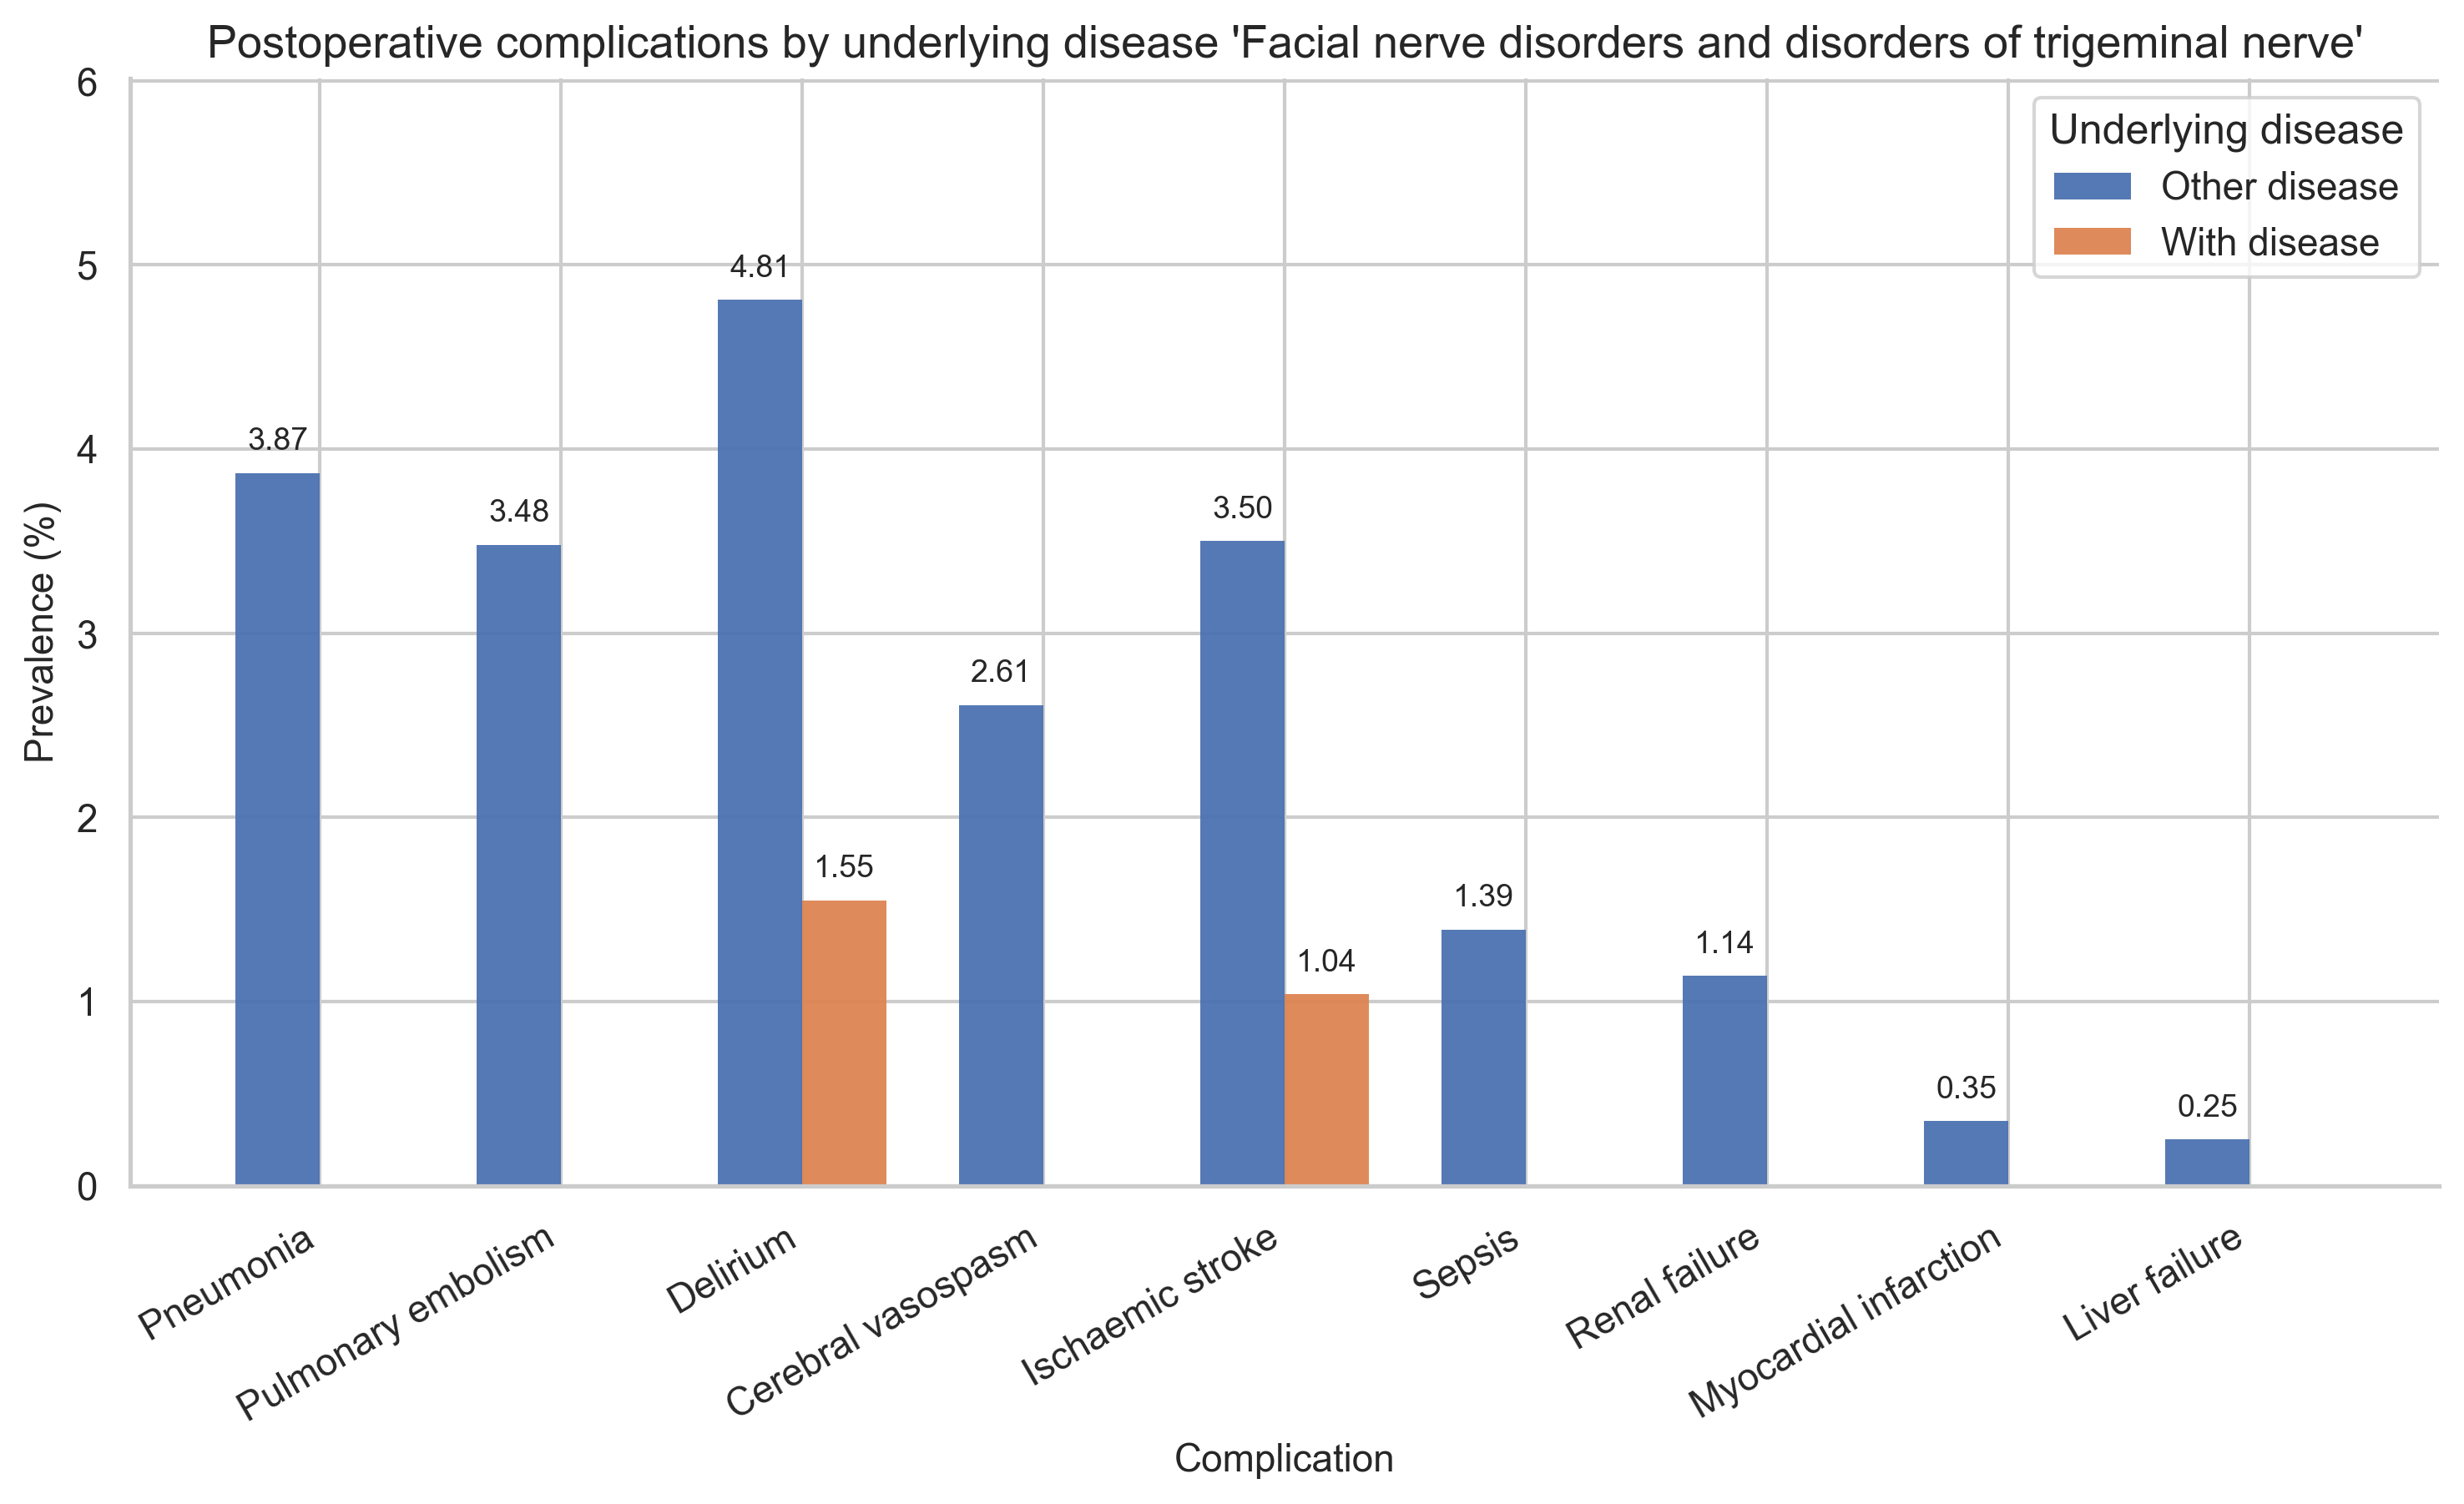


=== other_aneurysm_dissection (27) ===

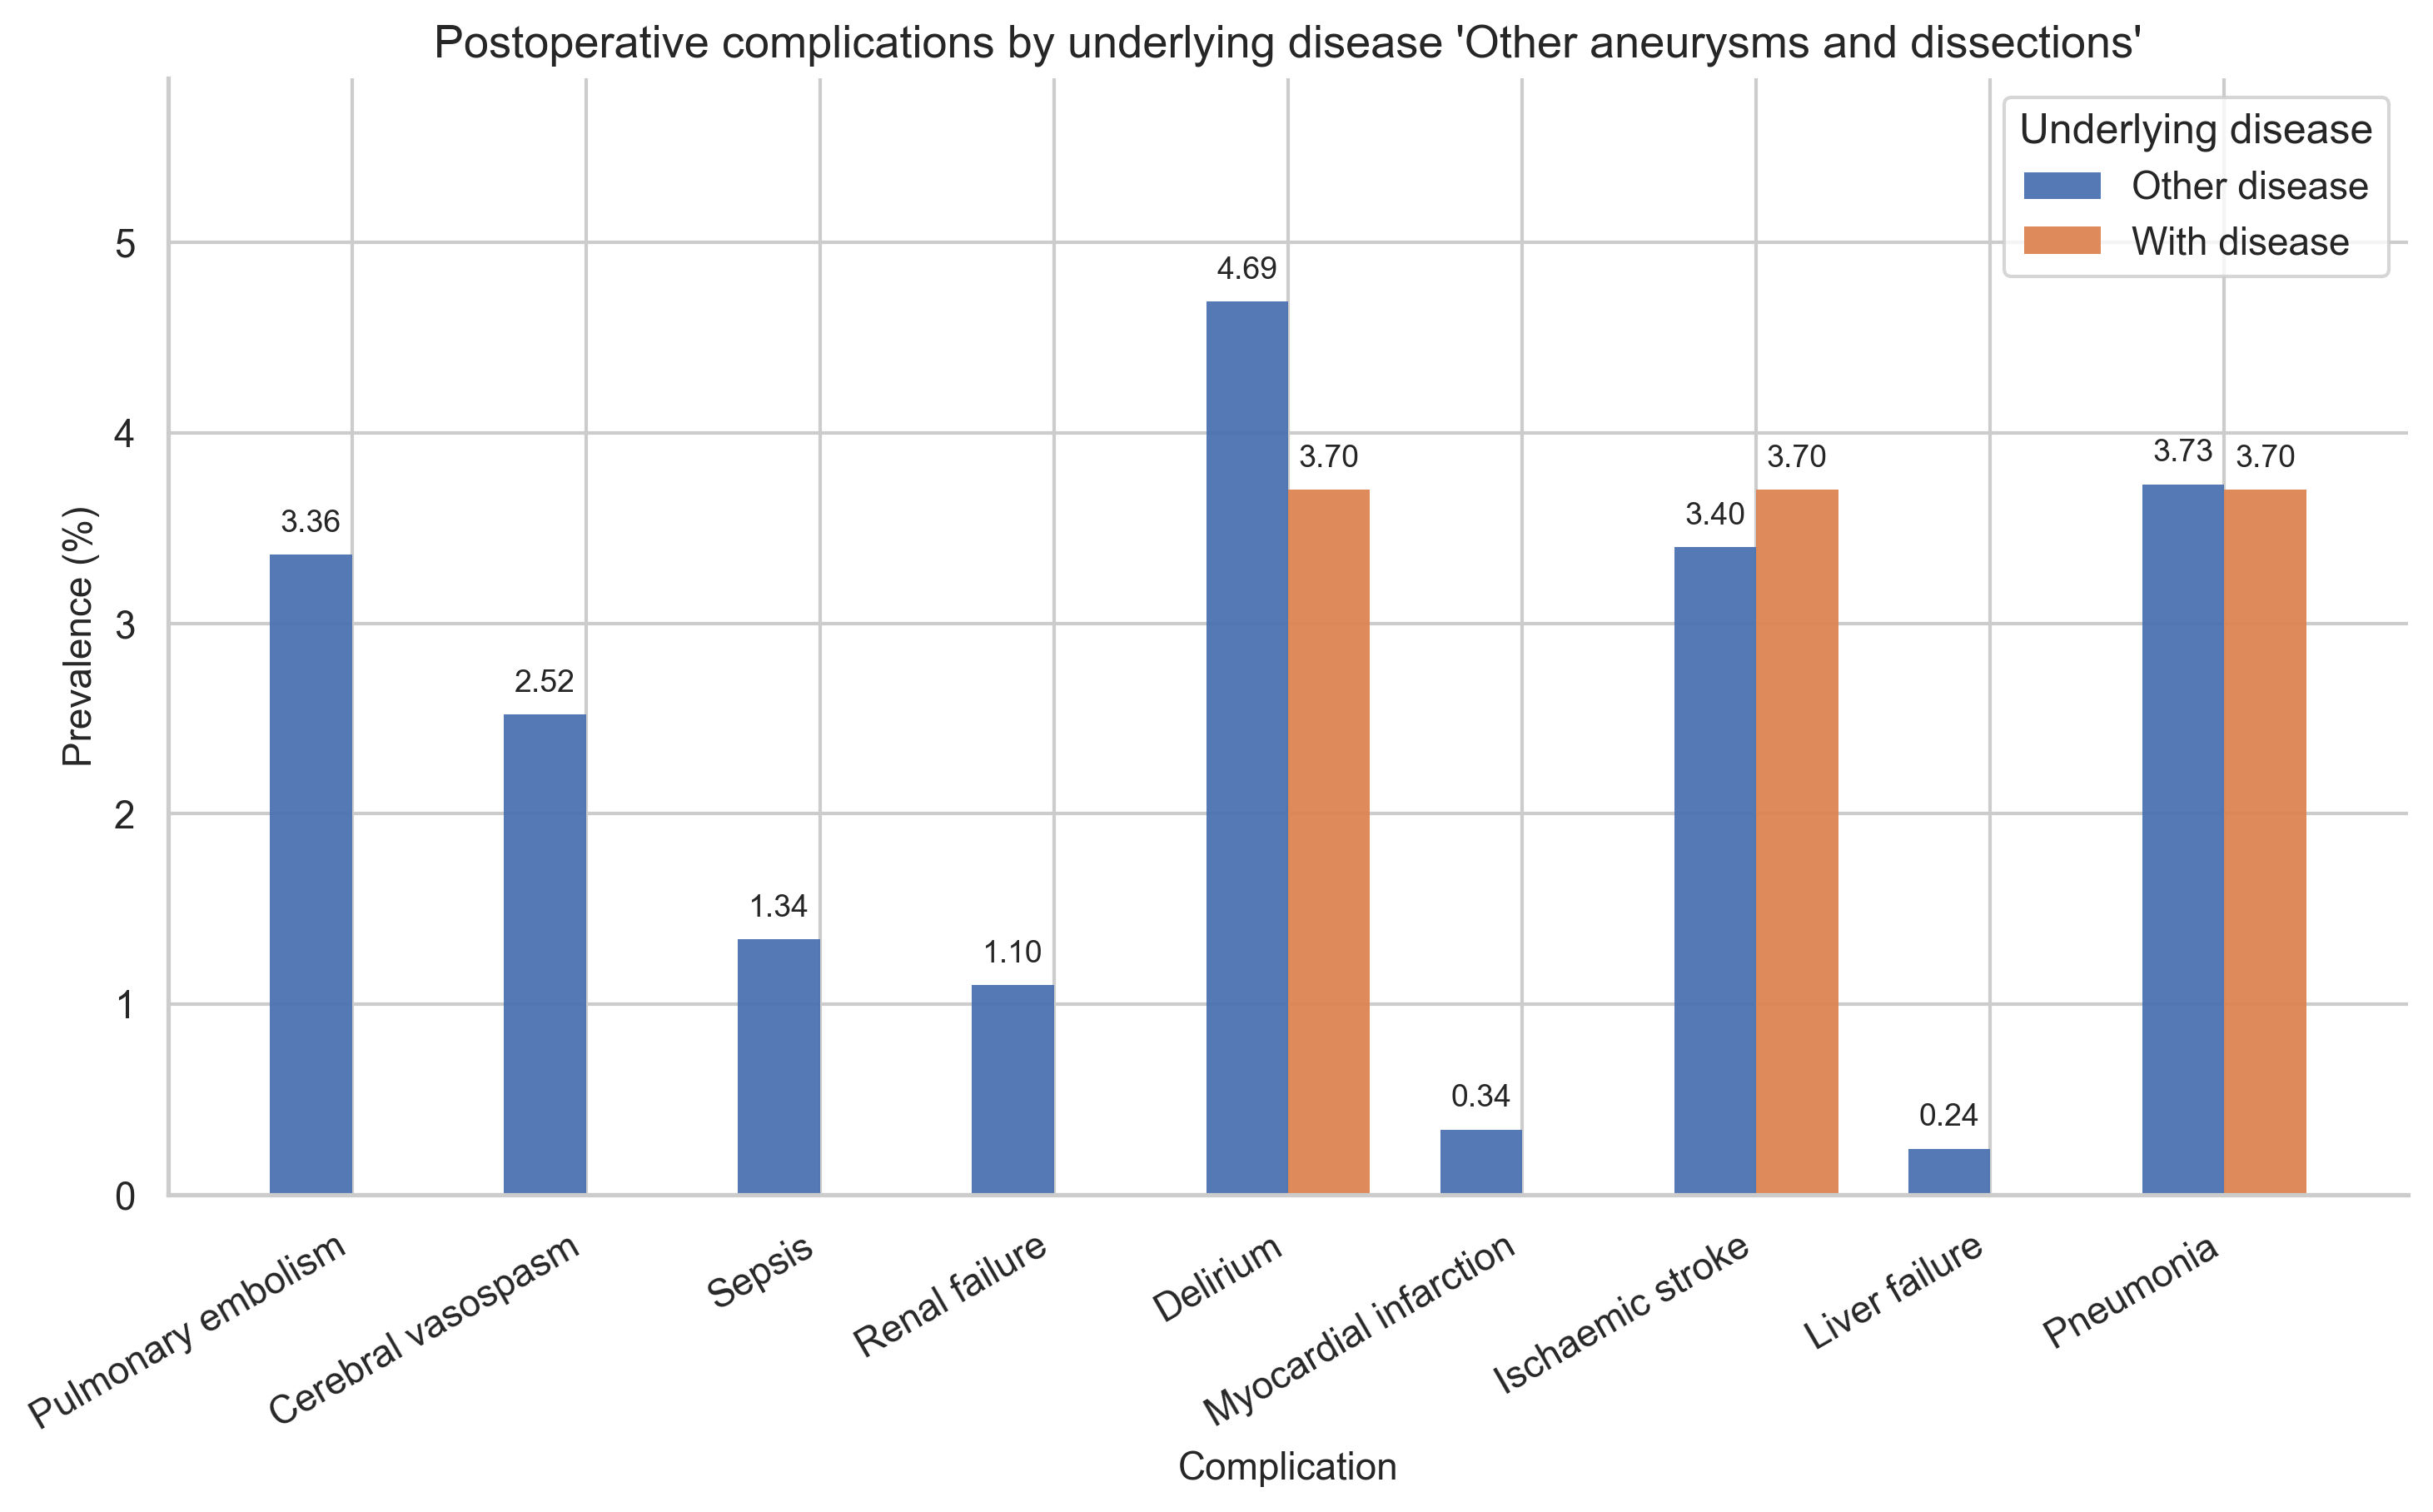


=== other (390) ===

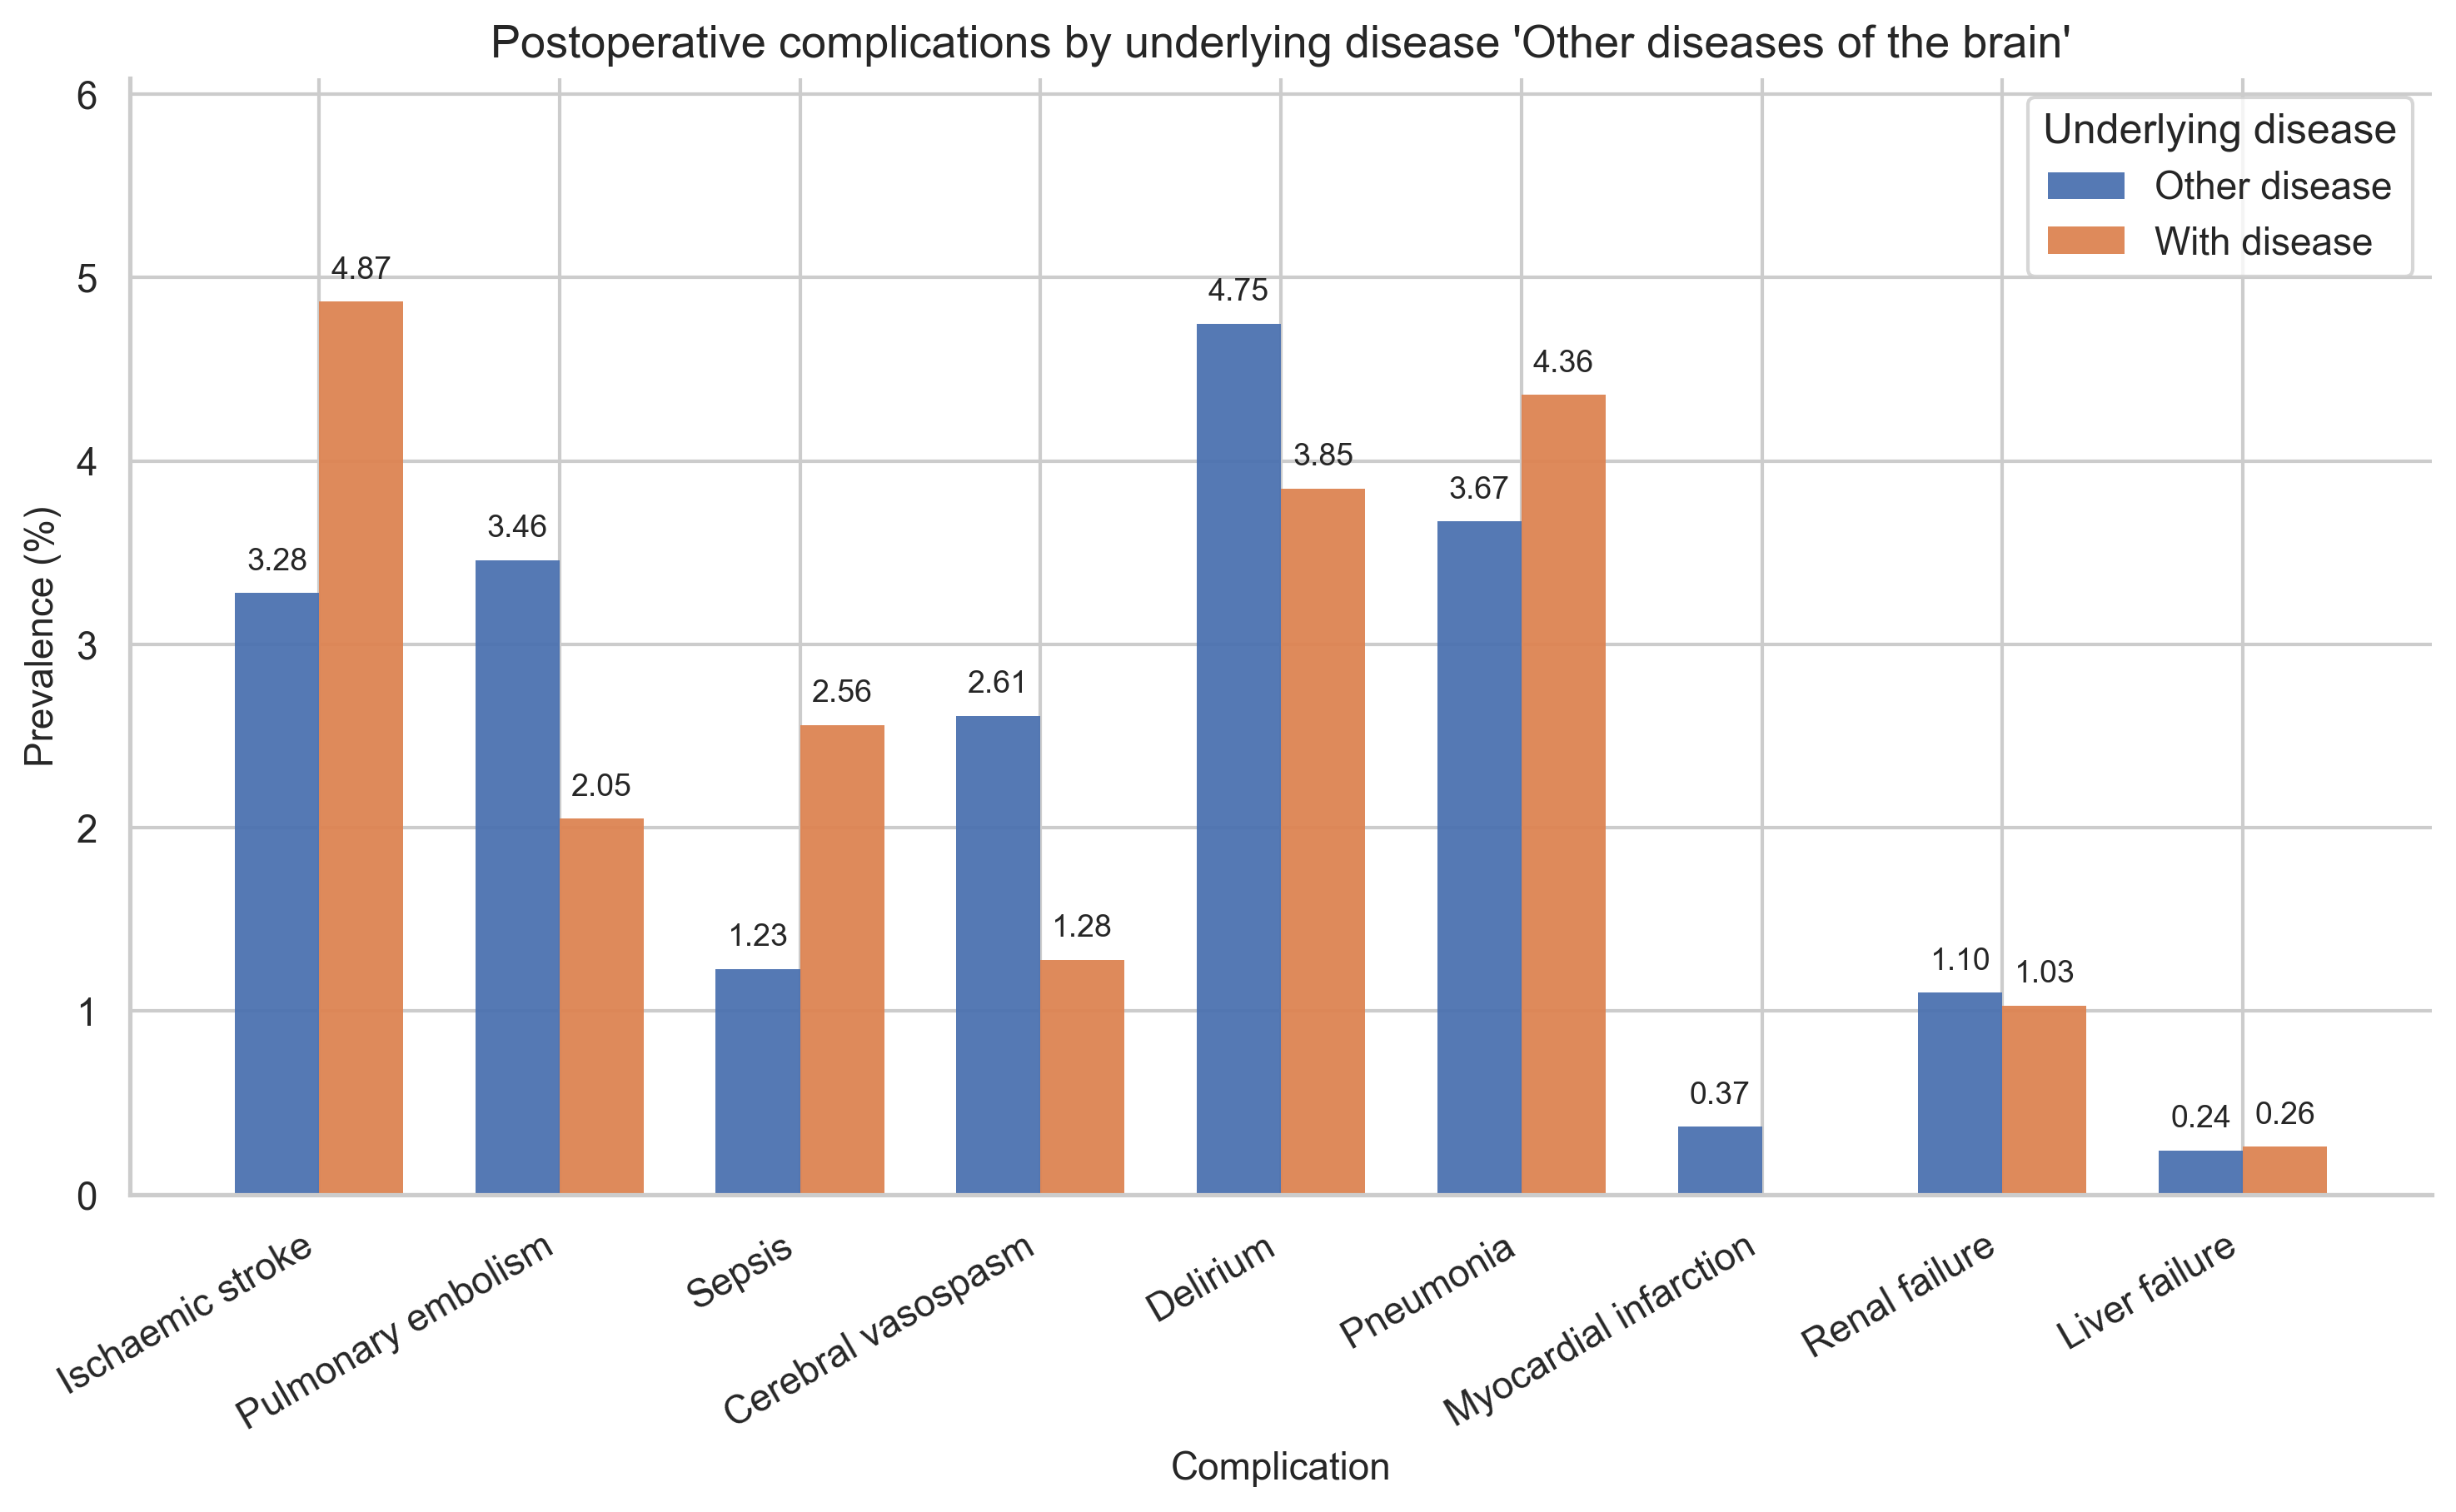

In [26]:
sns.set(style="whitegrid", font_scale=1.0)

prev_index = pd.MultiIndex.from_tuples(
    list(
        zip(
            *[
                sorted(
                    len(complications)
                    * [config.get('long_names').get(d) for d in (diagnoses)]
                ),
                len(diagnoses)
                * [config.get('long_names').get(c) for c in list(complications)],
            ]
        )
    ),
    names=["disease", "complication"],
)
prev_df = pd.DataFrame(columns=["With disease", "Other disease", "odds_ratio", "ci", "p_value"], index=prev_index).sort_index()

for d in diagnoses:
    print(f"\n=== {d} ({analysis_df[d].sum()}) ===")
    results = []
    for c in complications:
        cont_table = pd.crosstab(analysis_df[d], analysis_df[c])
        # print(f"\n=== {c} ===")
        # print(cont_table)
        statistic, pvalue = stats.fisher_exact(cont_table.values)
        odds_ratio_result = stats.contingency.odds_ratio(cont_table.values)
        results.append(
            {
                "complication": config.get('long_names').get(c),
                # "total_c": analysis_df[c].sum(),
                "odds_ratio": round(odds_ratio_result.statistic,2),
                "ci": f"[{round(odds_ratio_result.confidence_interval().low,2)}, {round(odds_ratio_result.confidence_interval().high,2)}]",
                "p_value": round(pvalue, 4),
                "p_value_*": get_asterisks_for_pval(pvalue),
                # "count_true": analysis_df[(analysis_df[d]==True)&(analysis_df[c]==True)].shape[0],
                # "count_false": analysis_df[(analysis_df[d]==True)&(analysis_df[c]==False)].shape[0],
            }
        )

    display(pd.DataFrame(results).sort_values("p_value"))

    complication_rates = (
        analysis_df.groupby(d)[list(complications)]
        .mean()
        .T.rename(index=config.get("long_names"))
        .rename(columns={False: "Other disease", True: "With disease"})
        .apply(lambda x: x * 100)
        .round(2)
        .sort_index()
    )
    complication_rates[["odds_ratio", "ci", "p_value"]] = pd.DataFrame(results).sort_values("complication")[["odds_ratio", "ci", "p_value"]].values

    prev_df.loc[config.get('long_names').get(d), ["With disease", "Other disease", "odds_ratio", "ci", "p_value"]] = complication_rates[["With disease", "Other disease", "odds_ratio", "ci", "p_value"]].values

    complication_rates = complication_rates.drop(['odds_ratio', 'ci', 'p_value'], axis = 1)
    diff = complication_rates.diff(axis=1).iloc[:, -1].abs()
    complication_rates = complication_rates.loc[diff.sort_values(ascending=False).index]

    display(complication_rates)

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    # x positions
    x = np.arange(len(complication_rates.index))

    # Colors (distinct but muted)
    colors = ["#4C72B0", "#DD8452"]

    # Bars (side-by-side)
    bars1 = ax.bar(
        x - width / 2,
        complication_rates["Other disease"],
        width,
        label="Other disease",
        edgecolor="none",
        alpha=0.95,
        color=colors[0],
    )
    bars2 = ax.bar(
        x + width / 2,
        complication_rates["With disease"],
        width,
        label="With disease",
        edgecolor="none",
        alpha=0.95,
        color=colors[1],
    )

    # Annotate values above bars
    def annotate_bars(bars, fmt="{:.1f}"):
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax.annotate(
                    fmt.format(h),
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

    annotate_bars(bars1, "{:.2f}")
    annotate_bars(bars2, "{:.2f}")

    # Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(complication_rates.index, rotation=30, ha="right")
    ax.set_ylabel("Prevalence (%)", fontsize=11)
    ax.set_xlabel("Complication", fontsize=11)
    ax.legend(title="Underlying disease", frameon=True)
    ax.set_ylim(
        0, complication_rates.values.max() * 1.25
    )  # add headroom for annotations

    # Remove top/right spines for a cleaner look
    sns.despine(ax=ax)

    plt.tight_layout()
    ax.set_title(
        f"Postoperative complications by underlying disease '{config.get('long_names')[d]}'",
        fontsize=13,
    )
    plt.show()
    plt.close()


display(prev_df[prev_df['p_value']<0.05])
prev_df[prev_df['p_value']<0.05].rename({'disease': 'Disease', 'complication': 'Complication', 'With disease': 'Prevalence with disease', 'Other disease': 'Prevalence with other disease', 'odds_ratio': 'Odds Ratio', 'ci': '95 % CI', 'p_value': 'p value'}).to_csv("./data/out/table4.csv")

### 3.4.7 Bias assessment

#### 3.4.7.1 Delirium

         mean_map              
           median    mean count
delirium                       
False     79.3029 79.5975  4785
True      79.6087 80.0443   235
p-value: 0.3393
No significance found.

1, 2: Effect size: Hedges' g: 0.07 (very small)
         median_map              
             median    mean count
delirium                         
False       78.7863 79.0712  4785
True        78.7704 79.2789   235
p-value: 0.7513
No significance found.

1, 2: Effect size: Hedges' g: 0.03 (very small)
         min_map              
          median    mean count
delirium                      
False    62.6683 62.1672  4785
True     63.0000 62.2726   235
p-value: 0.9379
No significance found.

1, 2: Effect size: Hedges' g: 0.01 (very small)
          mv_time               
           median     mean count
delirium                        
False    341.2500 347.7832  4785
True     360.5000 368.0162   235
p-value: 0.1115
No significance found.

1, 2: Effect size: Hedges' g: 0.17 (very small

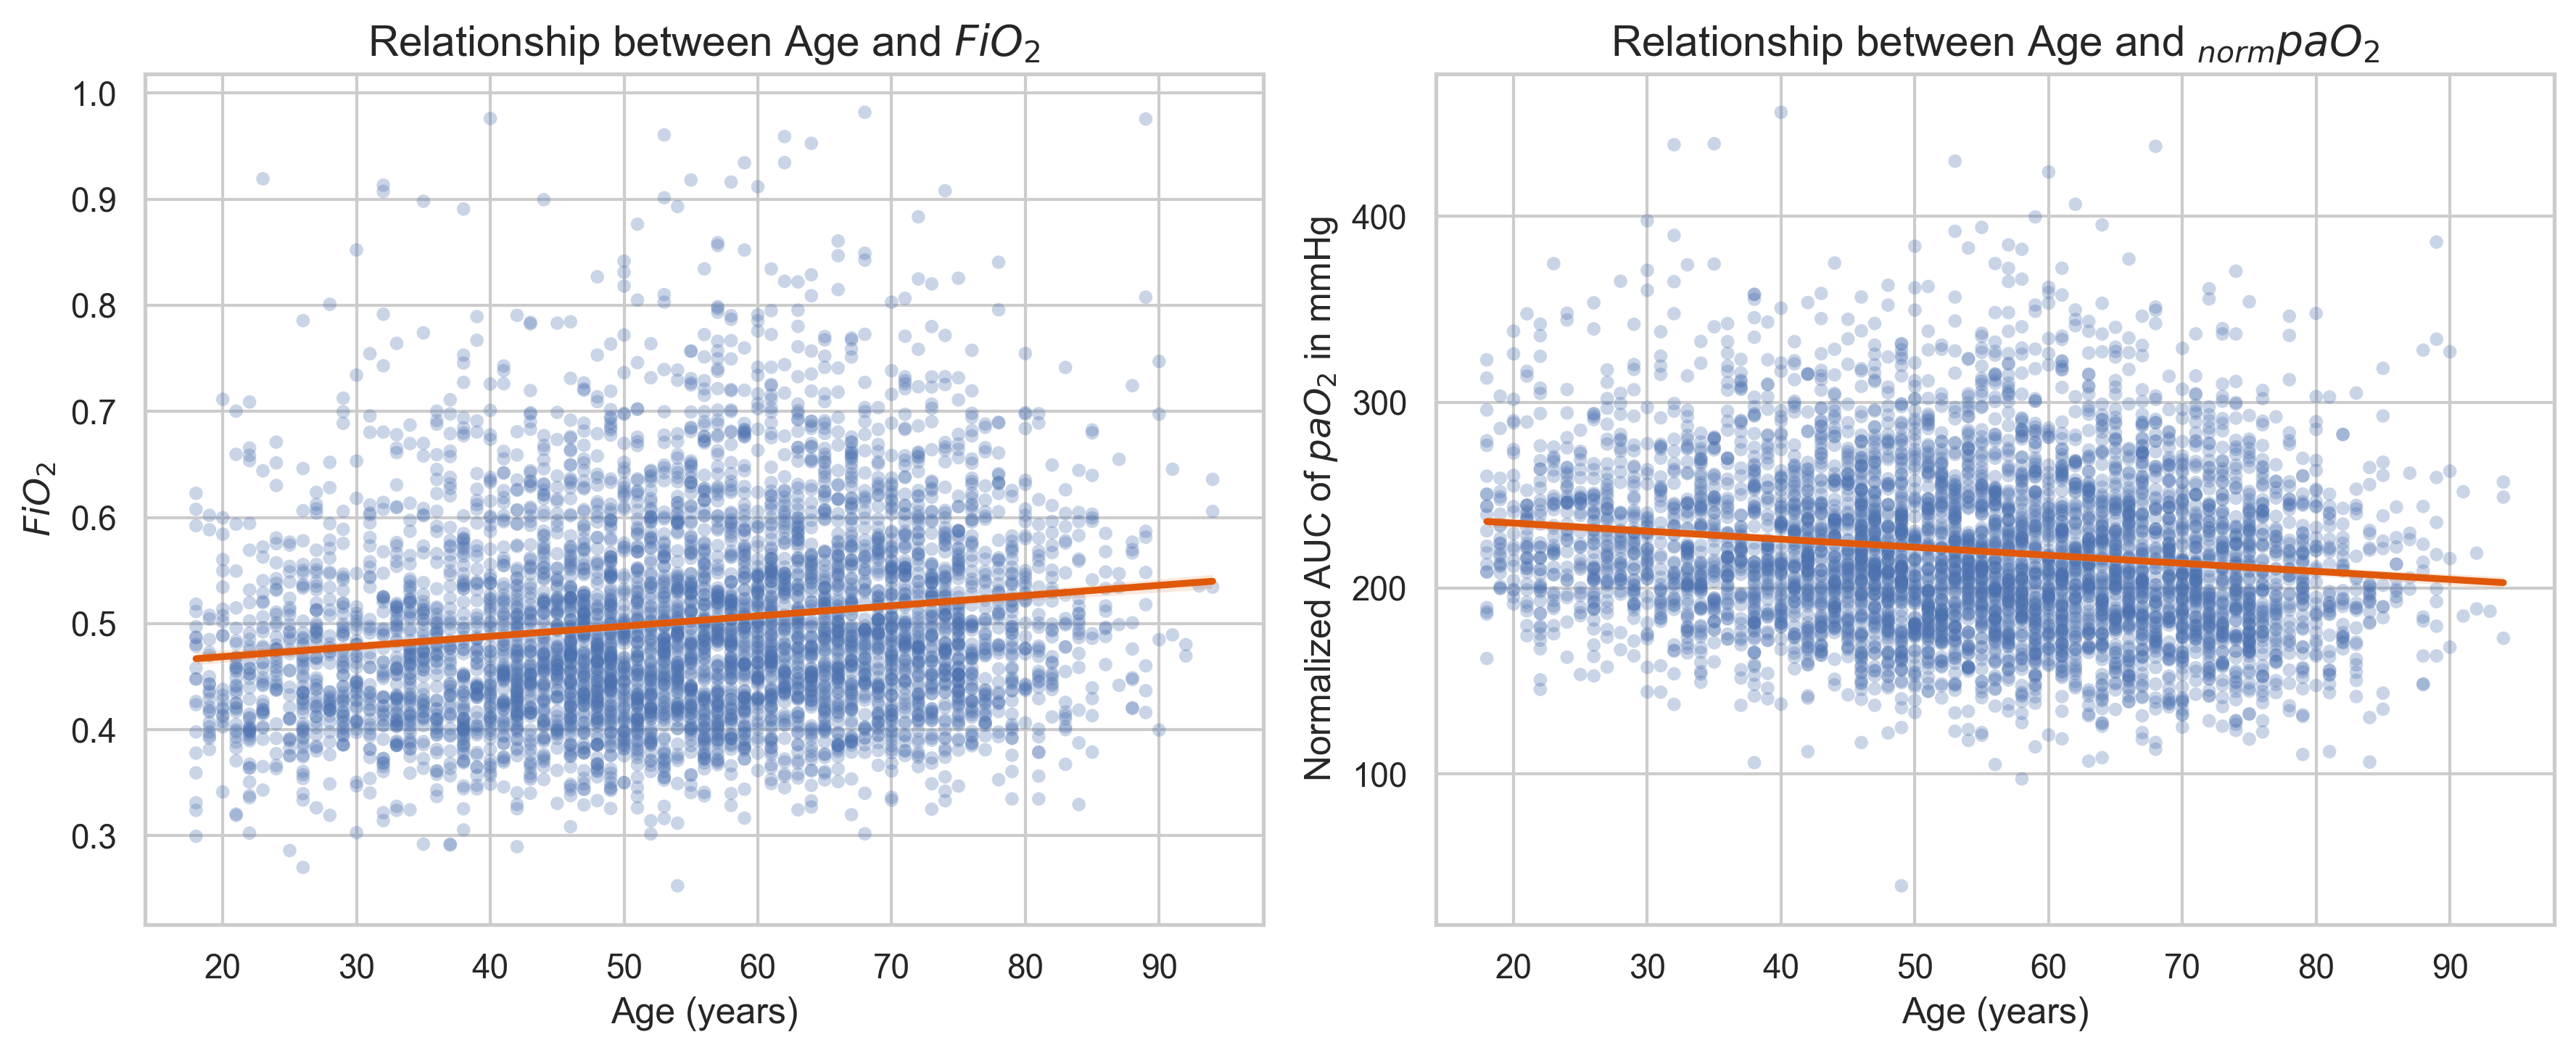

In [27]:
mean_map_df = pd.DataFrame(
    {
        "mean_map": list(
            data[data["delirium"] == True]
            .groupby("identifier")["mean_art_press"]
            .mean()
            .values
        )
        + list(
            data[data["delirium"] == False]
            .groupby("identifier")["mean_art_press"]
            .mean()
            .values
        ),
        "delirium": sum(analysis_df["delirium"] == True) * [True]
        + sum(analysis_df["delirium"] == False) * [False],
    }
)
compare_median("mean_map", mean_map_df, "delirium")


median_map_df = pd.DataFrame(
    {
        "median_map": list(
            data[data["delirium"] == True]
            .groupby("identifier")["mean_art_press"]
            .median()
            .values
        )
        + list(
            data[data["delirium"] == False]
            .groupby("identifier")["mean_art_press"]
            .median()
            .values
        ),
        "delirium": sum(analysis_df["delirium"] == True) * [True]
        + sum(analysis_df["delirium"] == False) * [False],
    }
)
compare_median("median_map", median_map_df, "delirium")


min_map_df = pd.DataFrame(
    {
        "min_map": list(
            data[data["delirium"] == True]
            .groupby("identifier")["mean_art_press"]
            .min()
            .values
        )
        + list(
            data[data["delirium"] == False]
            .groupby("identifier")["mean_art_press"]
            .min()
            .values
        ),
        "delirium": sum(analysis_df["delirium"] == True) * [True]
        + sum(analysis_df["delirium"] == False) * [False],
    }
)
compare_median("min_map", min_map_df, "delirium")

compare_median("mv_time", analysis_df, "delirium", True)

compare_median("age", analysis_df, "delirium", True)

cont_table = pd.crosstab(analysis_df["los_prolonged"], analysis_df["delirium"])
print(cont_table)
oddsratio, pvalue = stats.fisher_exact(cont_table)

print(f"Odds ratio: {round(oddsratio,2)}, p-value: {round(pvalue,4)} (Fisher's Exact Test)")

print(stats.spearmanr(analysis_df["norm_auc_paO2"], analysis_df["age"]))
print(stats.spearmanr(data.groupby('identifier')["fio2"].mean(), data.groupby('identifier')["age"].mean()))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Age vs FiO2 ---
sns.regplot(
    x=data.groupby('identifier')["age"].mean(),
    y=data.groupby('identifier')["fio2"].mean(),
    ax=axes[0],
    scatter_kws={'alpha': 0.3, 'edgecolor': 'none', 's': 20},
    line_kws={'color': '#e0580aff'}
)
axes[0].set_xlabel("Age (years)", fontsize=12)
axes[0].set_ylabel("$FiO_2$", fontsize=12)

# --- Plot 2: Age vs norm_auc_paO2 ---
sns.regplot(
    x="age",
    y="norm_auc_paO2",
    data=analysis_df,
    ax=axes[1],
    scatter_kws={'alpha': 0.3, 'edgecolor': 'none', 's': 20},
    line_kws={'color': '#e0580aff'}
)
axes[1].set_xlabel("Age (years)", fontsize=12)
axes[1].set_ylabel("Normalized AUC of $paO_2$ in mmHg", fontsize=12)

axes[0].set_title("Relationship between Age and $FiO_2$", fontsize=14)
axes[1].set_title("Relationship between Age and $_{norm}paO_2$", fontsize=14)

plt.tight_layout()
plt.savefig('plots/age_fio2_pao2.png', dpi=300, bbox_inches="tight")

plt.show()

#### 3.4.7.2 Pulmonary embolism

In [28]:
cont_table = pd.crosstab(analysis_df["los_prolonged"], analysis_df["pulmonary_embolism"])
print(cont_table)
oddsratio, pvalue = stats.fisher_exact(cont_table)

print(f"Odds ratio: {round(oddsratio,2)}, p-value: {round(pvalue,4)} (Fisher's Exact Test)")


compare_median("bmi", analysis_df, "pulmonary_embolism", True)
compare_median("age", analysis_df, "pulmonary_embolism", True)

mean_map_df = pd.DataFrame(
    {
        "mean_map": list(
            data[data["pulmonary_embolism"] == True]
            .groupby("identifier")["mean_art_press"]
            .mean()
            .values
        )
        + list(
            data[data["pulmonary_embolism"] == False]
            .groupby("identifier")["mean_art_press"]
            .mean()
            .values
        ),
        "pulmonary_embolism": sum(analysis_df["pulmonary_embolism"] == True) * [True]
        + sum(analysis_df["pulmonary_embolism"] == False) * [False],
    }
)
compare_median("mean_map", mean_map_df, "pulmonary_embolism")

pulmonary_embolism  False  True 
los_prolonged                   
False                3535     49
True                 1317    119
Odds ratio: 6.52, p-value: 0.0 (Fisher's Exact Test)
                       bmi              
                    median    mean count
pulmonary_embolism                      
False              24.5750 25.1128  4852
True               25.8300 26.7717   168
p-value: 0.0

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.38 (small)
                       age              
                    median    mean count
pulmonary_embolism                      
False              54.0000 53.7053  4852
True               60.5000 59.5000   168
p-value: 0.0

... Post hoc test...
     1    2
1    -  ***
2  ***    -
       1      2
1 1.0000 0.0000
2 0.0000 1.0000

1, 2: Effect size: Hedges' g: 0.36 (small)
                   mean_map              
                     median    mean c

np.float64(0.8232557226051618)

#### 3.4.7.3 Cerebral Vasospasm

In [29]:
cont_table = pd.crosstab(analysis_df["los_prolonged"], analysis_df["cerebral_vasospasm"])
print(cont_table)
oddsratio, pvalue = stats.fisher_exact(cont_table)

print(f"Odds ratio: {round(oddsratio,2)}, p-value: {round(pvalue,4)} (Fisher's Exact Test)")

compare_median("bmi", analysis_df, "cerebral_vasospasm", True)
compare_median("age", analysis_df, "cerebral_vasospasm", True)
compare_median("mv_time", analysis_df, "cerebral_vasospasm", True)

mean_map_df = pd.DataFrame(
    {
        "mean_map": list(
            data[data["cerebral_vasospasm"] == True]
            .groupby("identifier")["mean_art_press"]
            .mean()
            .values
        )
        + list(
            data[data["cerebral_vasospasm"] == False]
            .groupby("identifier")["mean_art_press"]
            .mean()
            .values
        ),
        "cerebral_vasospasm": sum(analysis_df["cerebral_vasospasm"] == True) * [True]
        + sum(analysis_df["cerebral_vasospasm"] == False) * [False],
    }
)
compare_median("mean_map", mean_map_df, "cerebral_vasospasm")


median_map_df = pd.DataFrame(
    {
        "median_map": list(
            data[data["cerebral_vasospasm"] == True]
            .groupby("identifier")["mean_art_press"]
            .median()
            .values
        )
        + list(
            data[data["cerebral_vasospasm"] == False]
            .groupby("identifier")["mean_art_press"]
            .median()
            .values
        ),
        "cerebral_vasospasm": sum(analysis_df["cerebral_vasospasm"] == True) * [True]
        + sum(analysis_df["cerebral_vasospasm"] == False) * [False],
    }
)
compare_median("median_map", median_map_df, "cerebral_vasospasm")


min_map_df = pd.DataFrame(
    {
        "min_map": list(
            data[data["cerebral_vasospasm"] == True]
            .groupby("identifier")["mean_art_press"]
            .min()
            .values
        )
        + list(
            data[data["cerebral_vasospasm"] == False]
            .groupby("identifier")["mean_art_press"]
            .min()
            .values
        ),
        "cerebral_vasospasm": sum(analysis_df["cerebral_vasospasm"] == True) * [True]
        + sum(analysis_df["cerebral_vasospasm"] == False) * [False],
    }
)
compare_median("min_map", min_map_df, "cerebral_vasospasm")

cerebral_vasospasm  False  True 
los_prolonged                   
False                3553     31
True                 1341     95
Odds ratio: 8.12, p-value: 0.0 (Fisher's Exact Test)
                       bmi              
                    median    mean count
cerebral_vasospasm                      
False              24.6200 25.1824  4894
True               24.4900 24.6231   126
p-value: 0.2017
No significance found.

1, 2: Effect size: Hedges' g: 0.13 (very small)
                       age              
                    median    mean count
cerebral_vasospasm                      
False              55.0000 53.9420  4894
True               52.0000 52.2381   126
p-value: 0.1609
No significance found.

1, 2: Effect size: Hedges' g: 0.11 (very small)
                    mv_time               
                     median     mean count
cerebral_vasospasm                        
False              343.1250 350.1202  4894
True               295.1250 294.7493   126
p-value: 0.0



np.float64(6.01740515268331e-07)

#### 3.4.7.4 Hypoxia ssessment

In [30]:
grouped = (
    data.groupby("identifier")
    .agg(
        mean_fio2=("fio2", "mean"),
        mean_horowitz=("horowitz", "mean"),
        # mean_paO2=('paO2_combined', 'mean'),
        n_observations=("idx", "count"),
        n_hypoxic_obs=("paO2_combined", lambda s: (s < 120).sum()),
        n_low_pf_obs=("horowitz", lambda s: (s < 300).sum()),
    )
    .reset_index()
)
grouped["perc_hypoxic"] = grouped.apply(
    lambda x: round(100 / x["n_observations"] * x["n_hypoxic_obs"]), axis=1
)
grouped["perc_low_pf"] = grouped.apply(
    lambda x: round(100 / x["n_observations"] * x["n_low_pf_obs"]), axis=1
)


result_df = grouped.merge(
    analysis_df[["identifier", "norm_auc_paO2"] + list(complications) + diagnoses],
    on="identifier",
    how="left",
)
display(result_df.sort_values("n_hypoxic_obs", ascending=False))


print(
    f"Number of patients with normpaO2 < 120 mmHg: {result_df.loc[result_df.norm_auc_paO2 < 120].shape[0]} ({min(result_df.loc[result_df.norm_auc_paO2 < 120].perc_hypoxic.values)} - {max(result_df.loc[result_df.norm_auc_paO2 < 120].perc_hypoxic.values)} % of their total observations)."
)

print(
    f"\tMean FiO2: {round(result_df.loc[result_df.norm_auc_paO2 < 120].mean().mean_fio2,3)} and mean p/F ratio: {round(result_df.loc[result_df.norm_auc_paO2 < 120].mean().mean_horowitz,2)}."
)


print(
    f"Number of patients with mean p/F ratio < 300: {result_df.loc[result_df.mean_horowitz < 300].shape[0]} ({min(result_df.loc[result_df.mean_horowitz < 300].perc_low_pf.values)} - {max(result_df.loc[result_df.mean_horowitz < 300].perc_low_pf.values)} % of their total observations)."
)
print(
    f"\tMean FiO2: {round(result_df.loc[result_df.mean_horowitz < 300].mean().mean_fio2,3)} and mean normpaO2: {round(result_df.loc[result_df.mean_horowitz < 300].mean().norm_auc_paO2,2)}."
)
print(
    f"Number of patients with normpaO2 < 120 and mean p/F ratio < 300: {result_df.loc[(result_df.norm_auc_paO2 < 120) & (result_df.mean_horowitz < 300)].shape[0]}."
)


for c in complications:
    print(f"{c}: {int(result_df.loc[result_df.norm_auc_paO2 < 120].sum()[c])}")

for d in diagnoses:
    print(f"{d}: {int(result_df.loc[result_df.norm_auc_paO2 < 120].sum()[d])}")

5020 rows × 29 columns

Number of patients with normpaO2 < 120 mmHg: 18 (57 - 94 % of their total observations).
    Mean FiO2: 0.363 and mean p/F ratio: 355.94.
Number of patients with mean p/F ratio < 300: 108 (19 - 97 % of their total observations).
    Mean FiO2: 0.543 and mean normpaO2: 196.78.
Number of patients with normpaO2 < 120 and mean p/F ratio < 300: 2.
cerebral_vasospasm: 2
delirium: 1
liver_failure: 0
myocardial_infarction: 1
pneumonia: 1
pulmonary_embolism: 1
renal_failure: 0
sepsis: 1
stroke: 1
benign_neoplasm: 9
cerebral_aneurysm: 0
epilepsy: 0
intracranial_hemorrhage: 2
malignant_neoplasm: 3
neoplasm: 0
SAH: 1
TBI: 1
trigeminus: 0
other_aneurysm_dissection: 0
other: 3